<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-18 19:48:56.338247: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 19:48:56.370424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-18 19:48:56.370446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-18 19:48:56.371492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-18 19:48:56.377003: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 19:48:56.377850: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-18 19:48:57.097462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-18 19:48:59.438422: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 92ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

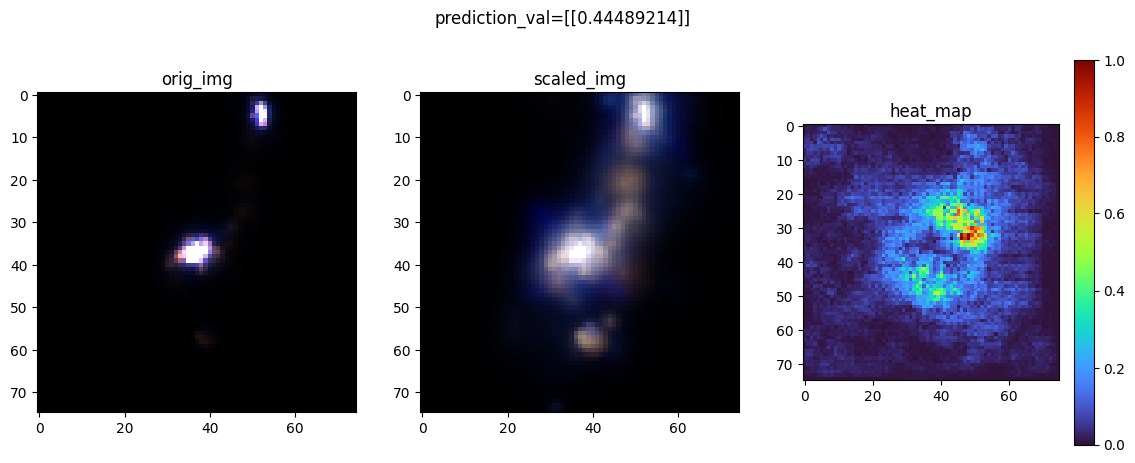

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

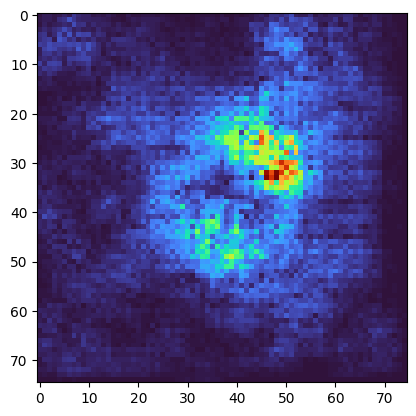

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-18 19:49:02.416300: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-18 19:49:03.252982: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-18 19:49:03.324679: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-18 19:49:03.364606: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-18 19:49:04.827364: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

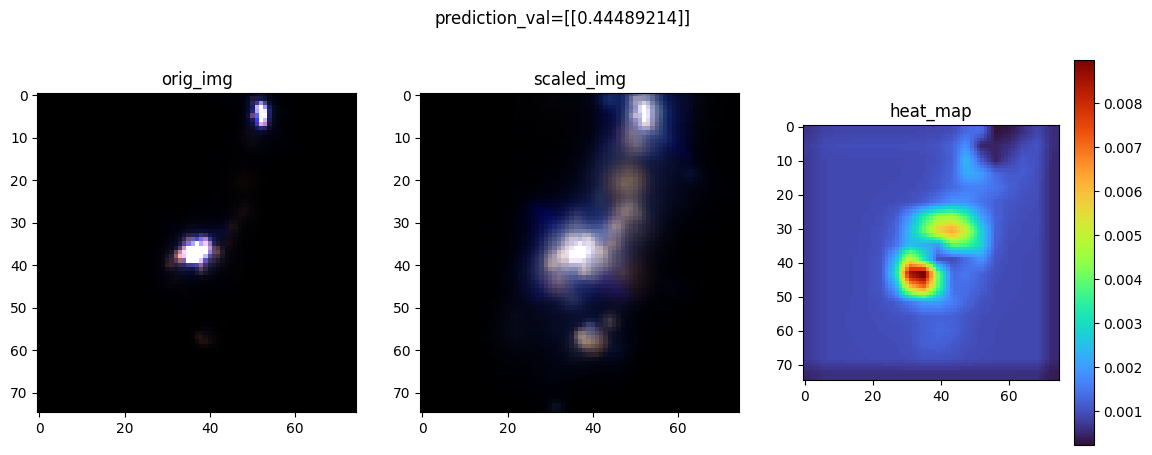

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 5/32 [===>..........................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 1s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

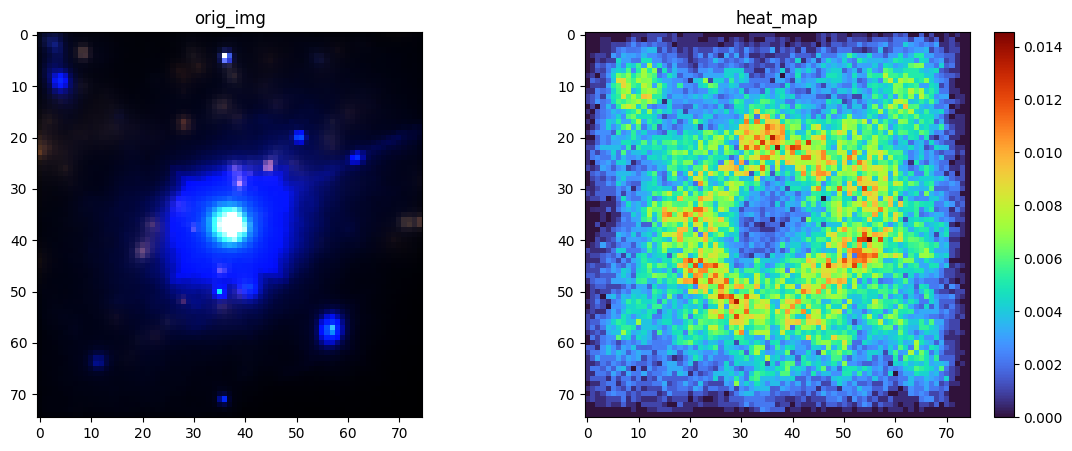

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:18 - loss: 0.7119 - accuracy: 0.4688

  2/338 [..............................] - ETA: 19s - loss: 0.7085 - accuracy: 0.5312 

  3/338 [..............................] - ETA: 19s - loss: 0.7098 - accuracy: 0.5000

  4/338 [..............................] - ETA: 19s - loss: 0.7091 - accuracy: 0.5078

  5/338 [..............................] - ETA: 19s - loss: 0.7065 - accuracy: 0.5562

  6/338 [..............................] - ETA: 19s - loss: 0.7061 - accuracy: 0.5573

  7/338 [..............................] - ETA: 19s - loss: 0.7055 - accuracy: 0.5625

  8/338 [..............................] - ETA: 19s - loss: 0.7055 - accuracy: 0.5586

  9/338 [..............................] - ETA: 19s - loss: 0.7053 - accuracy: 0.5556

 10/338 [..............................] - ETA: 19s - loss: 0.7048 - accuracy: 0.5594

 11/338 [..............................] - ETA: 18s - loss: 0.7039 - accuracy: 0.5710

 12/338 [>.............................] - ETA: 18s - loss: 0.7038 - accuracy: 0.5677

 13/338 [>.............................] - ETA: 18s - loss: 0.7034 - accuracy: 0.5697

 14/338 [>.............................] - ETA: 18s - loss: 0.7035 - accuracy: 0.5647

 15/338 [>.............................] - ETA: 18s - loss: 0.7032 - accuracy: 0.5646

 16/338 [>.............................] - ETA: 18s - loss: 0.7028 - accuracy: 0.5664

 17/338 [>.............................] - ETA: 18s - loss: 0.7028 - accuracy: 0.5625

 18/338 [>.............................] - ETA: 18s - loss: 0.7024 - accuracy: 0.5642

 19/338 [>.............................] - ETA: 18s - loss: 0.7027 - accuracy: 0.5559

 20/338 [>.............................] - ETA: 18s - loss: 0.7028 - accuracy: 0.5516

 21/338 [>.............................] - ETA: 18s - loss: 0.7028 - accuracy: 0.5491

 22/338 [>.............................] - ETA: 18s - loss: 0.7022 - accuracy: 0.5540

 23/338 [=>............................] - ETA: 17s - loss: 0.7015 - accuracy: 0.5598

 24/338 [=>............................] - ETA: 17s - loss: 0.7012 - accuracy: 0.5612

 25/338 [=>............................] - ETA: 17s - loss: 0.7012 - accuracy: 0.5587

 26/338 [=>............................] - ETA: 17s - loss: 0.7011 - accuracy: 0.5577

 27/338 [=>............................] - ETA: 17s - loss: 0.7007 - accuracy: 0.5590

 28/338 [=>............................] - ETA: 17s - loss: 0.7007 - accuracy: 0.5569

 29/338 [=>............................] - ETA: 17s - loss: 0.7005 - accuracy: 0.5571

 30/338 [=>............................] - ETA: 17s - loss: 0.7002 - accuracy: 0.5583

 31/338 [=>............................] - ETA: 17s - loss: 0.7004 - accuracy: 0.5544

 32/338 [=>............................] - ETA: 17s - loss: 0.7003 - accuracy: 0.5527

 33/338 [=>............................] - ETA: 17s - loss: 0.7010 - accuracy: 0.5436

 34/338 [==>...........................] - ETA: 17s - loss: 0.7006 - accuracy: 0.5460

 35/338 [==>...........................] - ETA: 17s - loss: 0.7007 - accuracy: 0.5429

 36/338 [==>...........................] - ETA: 17s - loss: 0.7002 - accuracy: 0.5460

 37/338 [==>...........................] - ETA: 17s - loss: 0.7003 - accuracy: 0.5439

 38/338 [==>...........................] - ETA: 17s - loss: 0.7002 - accuracy: 0.5428

 39/338 [==>...........................] - ETA: 16s - loss: 0.7001 - accuracy: 0.5425

 40/338 [==>...........................] - ETA: 16s - loss: 0.6999 - accuracy: 0.5430

 41/338 [==>...........................] - ETA: 16s - loss: 0.7000 - accuracy: 0.5404

 42/338 [==>...........................] - ETA: 16s - loss: 0.6998 - accuracy: 0.5409

 43/338 [==>...........................] - ETA: 16s - loss: 0.7000 - accuracy: 0.5378

 44/338 [==>...........................] - ETA: 16s - loss: 0.7001 - accuracy: 0.5348

 45/338 [==>...........................] - ETA: 16s - loss: 0.6999 - accuracy: 0.5361

 46/338 [===>..........................] - ETA: 16s - loss: 0.6999 - accuracy: 0.5340

 47/338 [===>..........................] - ETA: 16s - loss: 0.6994 - accuracy: 0.5386

 48/338 [===>..........................] - ETA: 16s - loss: 0.6993 - accuracy: 0.5384

 49/338 [===>..........................] - ETA: 16s - loss: 0.6994 - accuracy: 0.5364

 50/338 [===>..........................] - ETA: 16s - loss: 0.6995 - accuracy: 0.5337

 51/338 [===>..........................] - ETA: 16s - loss: 0.6996 - accuracy: 0.5319

 52/338 [===>..........................] - ETA: 16s - loss: 0.6994 - accuracy: 0.5337

 53/338 [===>..........................] - ETA: 16s - loss: 0.6989 - accuracy: 0.5377

 54/338 [===>..........................] - ETA: 16s - loss: 0.6991 - accuracy: 0.5341

 55/338 [===>..........................] - ETA: 16s - loss: 0.6991 - accuracy: 0.5335

 56/338 [===>..........................] - ETA: 15s - loss: 0.6990 - accuracy: 0.5335

 57/338 [====>.........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5340

 58/338 [====>.........................] - ETA: 15s - loss: 0.6988 - accuracy: 0.5339

 59/338 [====>.........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5323

 60/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5333

 61/338 [====>.........................] - ETA: 15s - loss: 0.6985 - accuracy: 0.5348

 62/338 [====>.........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5328

 63/338 [====>.........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5317

 64/338 [====>.........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5312

 65/338 [====>.........................] - ETA: 15s - loss: 0.6984 - accuracy: 0.5322

 66/338 [====>.........................] - ETA: 15s - loss: 0.6982 - accuracy: 0.5346

 67/338 [====>.........................] - ETA: 15s - loss: 0.6982 - accuracy: 0.5331

 68/338 [=====>........................] - ETA: 15s - loss: 0.6981 - accuracy: 0.5340

 69/338 [=====>........................] - ETA: 15s - loss: 0.6978 - accuracy: 0.5367

 70/338 [=====>........................] - ETA: 15s - loss: 0.6977 - accuracy: 0.5371

 71/338 [=====>........................] - ETA: 15s - loss: 0.6977 - accuracy: 0.5365

 72/338 [=====>........................] - ETA: 15s - loss: 0.6976 - accuracy: 0.5369

 73/338 [=====>........................] - ETA: 14s - loss: 0.6976 - accuracy: 0.5368

 74/338 [=====>........................] - ETA: 14s - loss: 0.6975 - accuracy: 0.5363

 75/338 [=====>........................] - ETA: 14s - loss: 0.6976 - accuracy: 0.5354

 76/338 [=====>........................] - ETA: 14s - loss: 0.6975 - accuracy: 0.5354

 77/338 [=====>........................] - ETA: 14s - loss: 0.6973 - accuracy: 0.5369

 78/338 [=====>........................] - ETA: 14s - loss: 0.6972 - accuracy: 0.5381

 79/338 [======>.......................] - ETA: 14s - loss: 0.6970 - accuracy: 0.5396

 80/338 [======>.......................] - ETA: 14s - loss: 0.6969 - accuracy: 0.5398

 81/338 [======>.......................] - ETA: 14s - loss: 0.6969 - accuracy: 0.5394

 82/338 [======>.......................] - ETA: 14s - loss: 0.6968 - accuracy: 0.5396

 83/338 [======>.......................] - ETA: 14s - loss: 0.6968 - accuracy: 0.5388

 84/338 [======>.......................] - ETA: 14s - loss: 0.6968 - accuracy: 0.5383

 85/338 [======>.......................] - ETA: 14s - loss: 0.6967 - accuracy: 0.5390

 86/338 [======>.......................] - ETA: 14s - loss: 0.6968 - accuracy: 0.5371

 87/338 [======>.......................] - ETA: 14s - loss: 0.6967 - accuracy: 0.5377

 88/338 [======>.......................] - ETA: 14s - loss: 0.6967 - accuracy: 0.5376

 89/338 [======>.......................] - ETA: 14s - loss: 0.6966 - accuracy: 0.5379

 90/338 [======>.......................] - ETA: 13s - loss: 0.6966 - accuracy: 0.5372

 91/338 [=======>......................] - ETA: 13s - loss: 0.6965 - accuracy: 0.5381

 92/338 [=======>......................] - ETA: 13s - loss: 0.6964 - accuracy: 0.5384

 93/338 [=======>......................] - ETA: 13s - loss: 0.6964 - accuracy: 0.5386

 94/338 [=======>......................] - ETA: 13s - loss: 0.6963 - accuracy: 0.5389

 95/338 [=======>......................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5391

 96/338 [=======>......................] - ETA: 13s - loss: 0.6961 - accuracy: 0.5397

 97/338 [=======>......................] - ETA: 13s - loss: 0.6961 - accuracy: 0.5396

 98/338 [=======>......................] - ETA: 13s - loss: 0.6961 - accuracy: 0.5395

 99/338 [=======>......................] - ETA: 13s - loss: 0.6961 - accuracy: 0.5391

100/338 [=======>......................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5406

101/338 [=======>......................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5396

102/338 [========>.....................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5401

103/338 [========>.....................] - ETA: 13s - loss: 0.6958 - accuracy: 0.5400

104/338 [========>.....................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5394

105/338 [========>.....................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5390

106/338 [========>.....................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5380

107/338 [========>.....................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5391

108/338 [========>.....................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5396

109/338 [========>.....................] - ETA: 12s - loss: 0.6955 - accuracy: 0.5416

110/338 [========>.....................] - ETA: 12s - loss: 0.6955 - accuracy: 0.5406

111/338 [========>.....................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5389

112/338 [========>.....................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5388

113/338 [=========>....................] - ETA: 12s - loss: 0.6956 - accuracy: 0.5393

114/338 [=========>....................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5381

115/338 [=========>....................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5378

116/338 [=========>....................] - ETA: 12s - loss: 0.6956 - accuracy: 0.5383

117/338 [=========>....................] - ETA: 12s - loss: 0.6955 - accuracy: 0.5390

118/338 [=========>....................] - ETA: 12s - loss: 0.6955 - accuracy: 0.5387

119/338 [=========>....................] - ETA: 12s - loss: 0.6955 - accuracy: 0.5378

120/338 [=========>....................] - ETA: 12s - loss: 0.6955 - accuracy: 0.5375

121/338 [=========>....................] - ETA: 12s - loss: 0.6956 - accuracy: 0.5369

122/338 [=========>....................] - ETA: 12s - loss: 0.6956 - accuracy: 0.5366

123/338 [=========>....................] - ETA: 12s - loss: 0.6955 - accuracy: 0.5366

124/338 [==========>...................] - ETA: 12s - loss: 0.6955 - accuracy: 0.5363

125/338 [==========>...................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5345

126/338 [==========>...................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5350

127/338 [==========>...................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5354

128/338 [==========>...................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5364

129/338 [==========>...................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5359

130/338 [==========>...................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5365

131/338 [==========>...................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5365

132/338 [==========>...................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5360

133/338 [==========>...................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5364

134/338 [==========>...................] - ETA: 11s - loss: 0.6951 - accuracy: 0.5375

135/338 [==========>...................] - ETA: 11s - loss: 0.6951 - accuracy: 0.5373

136/338 [===========>..................] - ETA: 11s - loss: 0.6951 - accuracy: 0.5370

137/338 [===========>..................] - ETA: 11s - loss: 0.6952 - accuracy: 0.5360

138/338 [===========>..................] - ETA: 11s - loss: 0.6952 - accuracy: 0.5360

139/338 [===========>..................] - ETA: 11s - loss: 0.6951 - accuracy: 0.5362

140/338 [===========>..................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5348

141/338 [===========>..................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5339

142/338 [===========>..................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5335

143/338 [===========>..................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5345

144/338 [===========>..................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5341

145/338 [===========>..................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5328

146/338 [===========>..................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5321

147/338 [============>.................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5315

148/338 [============>.................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5319

149/338 [============>.................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5304

150/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5300

151/338 [============>.................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5300

152/338 [============>.................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5298

153/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5294

154/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5290

155/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5288

156/338 [============>.................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5290

157/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5281

158/338 [=============>................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5281

159/338 [=============>................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5289

160/338 [=============>................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5297

161/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5297 

162/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5285

163/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5280

164/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5276

165/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5273

166/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5267

167/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5262

168/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5259

169/338 [==============>...............] - ETA: 9s - loss: 0.6957 - accuracy: 0.5242

170/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5248

171/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5254

172/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5256

173/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5262

174/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5269

175/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5275

176/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5268

177/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5265

178/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5267

179/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5269

180/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5267

181/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5266

182/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5264

183/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5260

184/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5251

185/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5253

186/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5260

187/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5262

188/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5259

189/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5256

190/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5257

191/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5252

192/338 [================>.............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5256

193/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5261

194/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5264

195/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5261

196/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5268

197/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5260

198/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5254

199/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5251

200/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5252

201/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5252

202/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5255

203/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5257

204/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5259

205/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5259

206/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5261

207/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5260

208/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5261

209/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5262

210/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5262

211/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5264

212/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5262

213/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5258

214/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5260

215/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5256

216/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5258

217/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5255

218/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5252

219/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5253

220/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5256

221/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5255

222/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5259

223/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5265

224/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5266

225/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5264

226/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5267

227/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5266

228/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5263

229/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5262

230/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5260

231/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5260

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5264

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5262

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5260

235/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5259

236/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5258

237/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5256

238/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5257

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5256

240/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5259

241/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5261

242/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5256

243/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5256

244/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5255

245/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5255

246/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5257

247/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5252

248/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5255

249/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5259

250/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5257

251/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5255

252/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5255

253/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5251

254/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5250

255/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5246

256/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5249

257/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5249

258/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5253

259/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5255

260/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5252

261/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5248

262/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5246

263/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5247

264/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5251

265/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5251

266/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5251

267/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5254

268/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5253

269/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5252

270/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5255

271/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5251

272/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5253

273/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5248

274/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5249

275/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5255

276/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5257

277/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5259

278/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5262

279/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5259

280/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5257

281/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5250

282/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5253

283/338 [========================>.....] - ETA: 3s - loss: 0.6941 - accuracy: 0.5247

284/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5254

285/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5260

286/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5258

287/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5258

288/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5258

289/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5263

290/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5265

291/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5272

292/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5269

293/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5270

294/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5269

295/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5274

296/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5274

297/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5276

298/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5275

299/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5277

300/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5276

301/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5278

302/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5278

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5281

304/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5277

305/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5276

306/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5273

307/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5271

308/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5267

309/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5267

310/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5264

311/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5262

312/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5256

313/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5260

314/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5258

315/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5254

316/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5261

317/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5260

318/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5262

319/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5262

320/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5266

321/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5268

322/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5265

323/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5266

324/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5269

325/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5272

326/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5271

327/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5269

328/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5270

329/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5268

330/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5263

331/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5262

332/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5261

333/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5261

334/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5264

335/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5267

336/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5272

337/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5272

338/338 [==============================] - 22s 61ms/step - loss: 0.6934 - accuracy: 0.5271 - val_loss: 0.6907 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6908 - accuracy: 0.4688

  2/338 [..............................] - ETA: 18s - loss: 0.6933 - accuracy: 0.4688

  3/338 [..............................] - ETA: 18s - loss: 0.6877 - accuracy: 0.5312

  4/338 [..............................] - ETA: 18s - loss: 0.6842 - accuracy: 0.5703

  5/338 [..............................] - ETA: 18s - loss: 0.6886 - accuracy: 0.5250

  6/338 [..............................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5156

  7/338 [..............................] - ETA: 18s - loss: 0.6890 - accuracy: 0.5268

  8/338 [..............................] - ETA: 18s - loss: 0.6925 - accuracy: 0.5000

  9/338 [..............................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5000

 10/338 [..............................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5031

 11/338 [..............................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5000

 12/338 [>.............................] - ETA: 18s - loss: 0.6922 - accuracy: 0.5000

 13/338 [>.............................] - ETA: 18s - loss: 0.6922 - accuracy: 0.4976

 14/338 [>.............................] - ETA: 18s - loss: 0.6921 - accuracy: 0.5000

 15/338 [>.............................] - ETA: 18s - loss: 0.6919 - accuracy: 0.5021

 16/338 [>.............................] - ETA: 17s - loss: 0.6916 - accuracy: 0.5078

 17/338 [>.............................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5147

 18/338 [>.............................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5191

 19/338 [>.............................] - ETA: 17s - loss: 0.6897 - accuracy: 0.5280

 20/338 [>.............................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5234

 21/338 [>.............................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5223

 22/338 [>.............................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5241

 23/338 [=>............................] - ETA: 17s - loss: 0.6905 - accuracy: 0.5217

 24/338 [=>............................] - ETA: 17s - loss: 0.6908 - accuracy: 0.5195

 25/338 [=>............................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5175

 26/338 [=>............................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5180

 27/338 [=>............................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5197

 28/338 [=>............................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5246

 29/338 [=>............................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5237

 30/338 [=>............................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5240

 31/338 [=>............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5232

 32/338 [=>............................] - ETA: 17s - loss: 0.6899 - accuracy: 0.5244

 33/338 [=>............................] - ETA: 17s - loss: 0.6899 - accuracy: 0.5246

 34/338 [==>...........................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5193

 35/338 [==>...........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5196

 36/338 [==>...........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5208

 37/338 [==>...........................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5220

 38/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5230

 39/338 [==>...........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5200

 40/338 [==>...........................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5227

 41/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5221

 42/338 [==>...........................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5231

 43/338 [==>...........................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5254

 44/338 [==>...........................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5263

 45/338 [==>...........................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5264

 46/338 [===>..........................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5292

 47/338 [===>..........................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5279

 48/338 [===>..........................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5254

 49/338 [===>..........................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5261

 50/338 [===>..........................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5269

 51/338 [===>..........................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5270

 52/338 [===>..........................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5252

 53/338 [===>..........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5230

 54/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5208

 55/338 [===>..........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5227

 56/338 [===>..........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5223

 57/338 [====>.........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5208

 58/338 [====>.........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5210

 59/338 [====>.........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5212

 60/338 [====>.........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5214

 61/338 [====>.........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5220

 62/338 [====>.........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5227

 63/338 [====>.........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5213

 64/338 [====>.........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5220

 65/338 [====>.........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5207

 66/338 [====>.........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5227

 67/338 [====>.........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5233

 68/338 [=====>........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5225

 69/338 [=====>........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5236

 70/338 [=====>........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5246

 71/338 [=====>........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5233

 72/338 [=====>........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5239

 73/338 [=====>........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5257

 74/338 [=====>........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5258

 75/338 [=====>........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5267

 76/338 [=====>........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5284

 77/338 [=====>........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5288

 78/338 [=====>........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5300

 79/338 [======>.......................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5289

 80/338 [======>.......................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5289

 81/338 [======>.......................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5285

 82/338 [======>.......................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5290

 83/338 [======>.......................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5297

 84/338 [======>.......................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5298

 85/338 [======>.......................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5294

 86/338 [======>.......................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5305

 87/338 [======>.......................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5309

 88/338 [======>.......................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5309

 89/338 [======>.......................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5305

 90/338 [======>.......................] - ETA: 13s - loss: 0.6892 - accuracy: 0.5306

 91/338 [=======>......................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5292

 92/338 [=======>......................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5299

 93/338 [=======>......................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5296

 94/338 [=======>......................] - ETA: 13s - loss: 0.6890 - accuracy: 0.5309

 95/338 [=======>......................] - ETA: 13s - loss: 0.6892 - accuracy: 0.5293

 96/338 [=======>......................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5299

 97/338 [=======>......................] - ETA: 13s - loss: 0.6892 - accuracy: 0.5293

 98/338 [=======>......................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5274

 99/338 [=======>......................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5262

100/338 [=======>......................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5266

101/338 [=======>......................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5266

102/338 [========>.....................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5270

103/338 [========>.....................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5264

104/338 [========>.....................] - ETA: 13s - loss: 0.6892 - accuracy: 0.5273

105/338 [========>.....................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5265

106/338 [========>.....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5271

107/338 [========>.....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5266

108/338 [========>.....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5260

109/338 [========>.....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5255

110/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5247

111/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5245

112/338 [========>.....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5251

113/338 [=========>....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5257

114/338 [=========>....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5255

115/338 [=========>....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5258

116/338 [=========>....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5253

117/338 [=========>....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5270

118/338 [=========>....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5260

119/338 [=========>....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5260

120/338 [=========>....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5266

121/338 [=========>....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5261

122/338 [=========>....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5264

123/338 [=========>....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5272

124/338 [==========>...................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5277

125/338 [==========>...................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5280

126/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5288

127/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5288

128/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5281

129/338 [==========>...................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5269

130/338 [==========>...................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5267

131/338 [==========>...................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5274

132/338 [==========>...................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5268

133/338 [==========>...................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5256

134/338 [==========>...................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5259

135/338 [==========>...................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5257

136/338 [===========>..................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5262

137/338 [===========>..................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5265

138/338 [===========>..................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5263

139/338 [===========>..................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5268

140/338 [===========>..................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5257

141/338 [===========>..................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5255

142/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5260

143/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5262

144/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5260

145/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5254

146/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5255

147/338 [============>.................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5249

148/338 [============>.................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5253

149/338 [============>.................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5256

150/338 [============>.................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5260

151/338 [============>.................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5267

152/338 [============>.................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5263

153/338 [============>.................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5266

154/338 [============>.................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5272

155/338 [============>.................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5278

156/338 [============>.................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5276

157/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5279

158/338 [=============>................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5277

159/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5277 

160/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5277

161/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5281

162/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5285

163/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5278

164/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5271

165/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5271

166/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5269

167/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5268

168/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5268

169/338 [==============>...............] - ETA: 9s - loss: 0.6890 - accuracy: 0.5268

170/338 [==============>...............] - ETA: 9s - loss: 0.6890 - accuracy: 0.5268

171/338 [==============>...............] - ETA: 9s - loss: 0.6889 - accuracy: 0.5280

172/338 [==============>...............] - ETA: 9s - loss: 0.6891 - accuracy: 0.5267

173/338 [==============>...............] - ETA: 9s - loss: 0.6889 - accuracy: 0.5280

174/338 [==============>...............] - ETA: 9s - loss: 0.6889 - accuracy: 0.5286

175/338 [==============>...............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5289

176/338 [==============>...............] - ETA: 9s - loss: 0.6889 - accuracy: 0.5288

177/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5290

178/338 [==============>...............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5293

179/338 [==============>...............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5292

180/338 [==============>...............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5293

181/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5294

182/338 [===============>..............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5288

183/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5290

184/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5294

185/338 [===============>..............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5287

186/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5299

187/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5304

188/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5303

189/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5301

190/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5304

191/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5303

192/338 [================>.............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5301

193/338 [================>.............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5298

194/338 [================>.............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5288

195/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5292

196/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5289

197/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5295

198/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5292

199/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5287

200/338 [================>.............] - ETA: 7s - loss: 0.6888 - accuracy: 0.5281

201/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5285

202/338 [================>.............] - ETA: 7s - loss: 0.6888 - accuracy: 0.5277

203/338 [=================>............] - ETA: 7s - loss: 0.6889 - accuracy: 0.5271

204/338 [=================>............] - ETA: 7s - loss: 0.6888 - accuracy: 0.5273

205/338 [=================>............] - ETA: 7s - loss: 0.6888 - accuracy: 0.5268

206/338 [=================>............] - ETA: 7s - loss: 0.6888 - accuracy: 0.5264

207/338 [=================>............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5269

208/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5273

209/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5275

210/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5274

211/338 [=================>............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5277

212/338 [=================>............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5277

213/338 [=================>............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5274

214/338 [=================>............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5279

215/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5283

216/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5288

217/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5288

218/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5280

219/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5278

220/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5277

221/338 [==================>...........] - ETA: 6s - loss: 0.6885 - accuracy: 0.5276

222/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5282

223/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5283

224/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5287

225/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5281

226/338 [===================>..........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5281

227/338 [===================>..........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5278

228/338 [===================>..........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5278

229/338 [===================>..........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5277

230/338 [===================>..........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5274

231/338 [===================>..........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5273

232/338 [===================>..........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5277

233/338 [===================>..........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5279

234/338 [===================>..........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5279

235/338 [===================>..........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5279

236/338 [===================>..........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5274

237/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5276

238/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5277

239/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5276

240/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5273

241/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5277

242/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5269

243/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5276

244/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5279

245/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5283

246/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5281

247/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5288

248/338 [=====================>........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5286

249/338 [=====================>........] - ETA: 4s - loss: 0.6881 - accuracy: 0.5287

250/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5290

251/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5291

252/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5290

253/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5292

254/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5292

255/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5299

256/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5303

257/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5305

258/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5310

259/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5310

260/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5312

261/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5312

262/338 [======================>.......] - ETA: 4s - loss: 0.6877 - accuracy: 0.5307

263/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5308

264/338 [======================>.......] - ETA: 4s - loss: 0.6878 - accuracy: 0.5299

265/338 [======================>.......] - ETA: 4s - loss: 0.6879 - accuracy: 0.5291

266/338 [======================>.......] - ETA: 4s - loss: 0.6879 - accuracy: 0.5291

267/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5294

268/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5294

269/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5292

270/338 [======================>.......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5285

271/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5285

272/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5280

273/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5276

274/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5274

275/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5276

276/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5274

277/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5271

278/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5274

279/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5274

280/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5270

281/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5269

282/338 [========================>.....] - ETA: 3s - loss: 0.6878 - accuracy: 0.5269

283/338 [========================>.....] - ETA: 3s - loss: 0.6877 - accuracy: 0.5272

284/338 [========================>.....] - ETA: 3s - loss: 0.6877 - accuracy: 0.5274

285/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5279

286/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5281

287/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5281

288/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5285

289/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5289

290/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5295

291/338 [========================>.....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5299

292/338 [========================>.....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5302

293/338 [=========================>....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5305

294/338 [=========================>....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5314

295/338 [=========================>....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5314

296/338 [=========================>....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5322

297/338 [=========================>....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5326

298/338 [=========================>....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5331

299/338 [=========================>....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5330

300/338 [=========================>....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5334

301/338 [=========================>....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5337

302/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5343

303/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5339

304/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5340

305/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5346

306/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5347

307/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5346

308/338 [==========================>...] - ETA: 1s - loss: 0.6873 - accuracy: 0.5353

309/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5350

310/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5353

311/338 [==========================>...] - ETA: 1s - loss: 0.6873 - accuracy: 0.5356

312/338 [==========================>...] - ETA: 1s - loss: 0.6873 - accuracy: 0.5358

313/338 [==========================>...] - ETA: 1s - loss: 0.6873 - accuracy: 0.5361

314/338 [==========================>...] - ETA: 1s - loss: 0.6873 - accuracy: 0.5362

315/338 [==========================>...] - ETA: 1s - loss: 0.6873 - accuracy: 0.5366

316/338 [===========================>..] - ETA: 1s - loss: 0.6873 - accuracy: 0.5368

317/338 [===========================>..] - ETA: 1s - loss: 0.6873 - accuracy: 0.5369

318/338 [===========================>..] - ETA: 1s - loss: 0.6872 - accuracy: 0.5371

319/338 [===========================>..] - ETA: 1s - loss: 0.6872 - accuracy: 0.5376

320/338 [===========================>..] - ETA: 1s - loss: 0.6871 - accuracy: 0.5379

321/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5381

322/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5381

323/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5387

324/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5392

325/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5396

326/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5399

327/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5397

328/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5395

329/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5396

330/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5395

331/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5398

332/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5401

333/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5402

334/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5403

335/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5411

336/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5412

337/338 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5415

338/338 [==============================] - 20s 60ms/step - loss: 0.6869 - accuracy: 0.5415 - val_loss: 0.6900 - val_accuracy: 0.5349


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6788 - accuracy: 0.6875

  2/338 [..............................] - ETA: 18s - loss: 0.6766 - accuracy: 0.6875

  3/338 [..............................] - ETA: 18s - loss: 0.6829 - accuracy: 0.6562

  4/338 [..............................] - ETA: 18s - loss: 0.6799 - accuracy: 0.6875

  5/338 [..............................] - ETA: 18s - loss: 0.6787 - accuracy: 0.6687

  6/338 [..............................] - ETA: 18s - loss: 0.6777 - accuracy: 0.6823

  7/338 [..............................] - ETA: 18s - loss: 0.6768 - accuracy: 0.6920

  8/338 [..............................] - ETA: 18s - loss: 0.6746 - accuracy: 0.6953

  9/338 [..............................] - ETA: 18s - loss: 0.6767 - accuracy: 0.6771

 10/338 [..............................] - ETA: 18s - loss: 0.6773 - accuracy: 0.6719

 11/338 [..............................] - ETA: 18s - loss: 0.6780 - accuracy: 0.6648

 12/338 [>.............................] - ETA: 18s - loss: 0.6775 - accuracy: 0.6641

 13/338 [>.............................] - ETA: 18s - loss: 0.6763 - accuracy: 0.6707

 14/338 [>.............................] - ETA: 18s - loss: 0.6777 - accuracy: 0.6562

 15/338 [>.............................] - ETA: 17s - loss: 0.6776 - accuracy: 0.6542

 16/338 [>.............................] - ETA: 17s - loss: 0.6775 - accuracy: 0.6504

 17/338 [>.............................] - ETA: 17s - loss: 0.6768 - accuracy: 0.6544

 18/338 [>.............................] - ETA: 17s - loss: 0.6761 - accuracy: 0.6545

 19/338 [>.............................] - ETA: 17s - loss: 0.6756 - accuracy: 0.6579

 20/338 [>.............................] - ETA: 17s - loss: 0.6762 - accuracy: 0.6531

 21/338 [>.............................] - ETA: 17s - loss: 0.6776 - accuracy: 0.6429

 22/338 [>.............................] - ETA: 17s - loss: 0.6779 - accuracy: 0.6406

 23/338 [=>............................] - ETA: 17s - loss: 0.6786 - accuracy: 0.6372

 24/338 [=>............................] - ETA: 17s - loss: 0.6785 - accuracy: 0.6354

 25/338 [=>............................] - ETA: 17s - loss: 0.6789 - accuracy: 0.6350

 26/338 [=>............................] - ETA: 17s - loss: 0.6785 - accuracy: 0.6394

 27/338 [=>............................] - ETA: 17s - loss: 0.6786 - accuracy: 0.6343

 28/338 [=>............................] - ETA: 17s - loss: 0.6786 - accuracy: 0.6373

 29/338 [=>............................] - ETA: 17s - loss: 0.6792 - accuracy: 0.6347

 30/338 [=>............................] - ETA: 17s - loss: 0.6801 - accuracy: 0.6323

 31/338 [=>............................] - ETA: 17s - loss: 0.6803 - accuracy: 0.6290

 32/338 [=>............................] - ETA: 17s - loss: 0.6797 - accuracy: 0.6328

 33/338 [=>............................] - ETA: 16s - loss: 0.6793 - accuracy: 0.6345

 34/338 [==>...........................] - ETA: 16s - loss: 0.6793 - accuracy: 0.6342

 35/338 [==>...........................] - ETA: 16s - loss: 0.6797 - accuracy: 0.6321

 36/338 [==>...........................] - ETA: 16s - loss: 0.6804 - accuracy: 0.6267

 37/338 [==>...........................] - ETA: 16s - loss: 0.6806 - accuracy: 0.6258

 38/338 [==>...........................] - ETA: 16s - loss: 0.6811 - accuracy: 0.6209

 39/338 [==>...........................] - ETA: 16s - loss: 0.6812 - accuracy: 0.6242

 40/338 [==>...........................] - ETA: 16s - loss: 0.6819 - accuracy: 0.6195

 41/338 [==>...........................] - ETA: 16s - loss: 0.6818 - accuracy: 0.6212

 42/338 [==>...........................] - ETA: 16s - loss: 0.6817 - accuracy: 0.6205

 43/338 [==>...........................] - ETA: 16s - loss: 0.6815 - accuracy: 0.6214

 44/338 [==>...........................] - ETA: 16s - loss: 0.6817 - accuracy: 0.6193

 45/338 [==>...........................] - ETA: 16s - loss: 0.6815 - accuracy: 0.6201

 46/338 [===>..........................] - ETA: 16s - loss: 0.6816 - accuracy: 0.6202

 47/338 [===>..........................] - ETA: 16s - loss: 0.6814 - accuracy: 0.6203

 48/338 [===>..........................] - ETA: 16s - loss: 0.6816 - accuracy: 0.6198

 49/338 [===>..........................] - ETA: 16s - loss: 0.6817 - accuracy: 0.6180

 50/338 [===>..........................] - ETA: 16s - loss: 0.6818 - accuracy: 0.6181

 51/338 [===>..........................] - ETA: 15s - loss: 0.6819 - accuracy: 0.6189

 52/338 [===>..........................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6184

 53/338 [===>..........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6173

 54/338 [===>..........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.6140

 55/338 [===>..........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6159

 56/338 [===>..........................] - ETA: 15s - loss: 0.6819 - accuracy: 0.6172

 57/338 [====>.........................] - ETA: 15s - loss: 0.6821 - accuracy: 0.6168

 58/338 [====>.........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.6153

 59/338 [====>.........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6160

 60/338 [====>.........................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6187

 61/338 [====>.........................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6178

 62/338 [====>.........................] - ETA: 15s - loss: 0.6819 - accuracy: 0.6164

 63/338 [====>.........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6146

 64/338 [====>.........................] - ETA: 15s - loss: 0.6816 - accuracy: 0.6172

 65/338 [====>.........................] - ETA: 15s - loss: 0.6816 - accuracy: 0.6178

 66/338 [====>.........................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6174

 67/338 [====>.........................] - ETA: 15s - loss: 0.6814 - accuracy: 0.6185

 68/338 [=====>........................] - ETA: 14s - loss: 0.6813 - accuracy: 0.6190

 69/338 [=====>........................] - ETA: 14s - loss: 0.6815 - accuracy: 0.6173

 70/338 [=====>........................] - ETA: 14s - loss: 0.6817 - accuracy: 0.6165

 71/338 [=====>........................] - ETA: 14s - loss: 0.6817 - accuracy: 0.6166

 72/338 [=====>........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6159

 73/338 [=====>........................] - ETA: 14s - loss: 0.6816 - accuracy: 0.6173

 74/338 [=====>........................] - ETA: 14s - loss: 0.6813 - accuracy: 0.6199

 75/338 [=====>........................] - ETA: 14s - loss: 0.6810 - accuracy: 0.6217

 76/338 [=====>........................] - ETA: 14s - loss: 0.6809 - accuracy: 0.6225

 77/338 [=====>........................] - ETA: 14s - loss: 0.6809 - accuracy: 0.6226

 78/338 [=====>........................] - ETA: 14s - loss: 0.6807 - accuracy: 0.6238

 79/338 [======>.......................] - ETA: 14s - loss: 0.6807 - accuracy: 0.6242

 80/338 [======>.......................] - ETA: 14s - loss: 0.6809 - accuracy: 0.6234

 81/338 [======>.......................] - ETA: 14s - loss: 0.6808 - accuracy: 0.6238

 82/338 [======>.......................] - ETA: 14s - loss: 0.6809 - accuracy: 0.6235

 83/338 [======>.......................] - ETA: 14s - loss: 0.6807 - accuracy: 0.6235

 84/338 [======>.......................] - ETA: 14s - loss: 0.6807 - accuracy: 0.6235

 85/338 [======>.......................] - ETA: 14s - loss: 0.6807 - accuracy: 0.6232

 86/338 [======>.......................] - ETA: 13s - loss: 0.6805 - accuracy: 0.6235

 87/338 [======>.......................] - ETA: 13s - loss: 0.6806 - accuracy: 0.6232

 88/338 [======>.......................] - ETA: 13s - loss: 0.6808 - accuracy: 0.6222

 89/338 [======>.......................] - ETA: 13s - loss: 0.6807 - accuracy: 0.6225

 90/338 [======>.......................] - ETA: 13s - loss: 0.6805 - accuracy: 0.6233

 91/338 [=======>......................] - ETA: 13s - loss: 0.6805 - accuracy: 0.6226

 92/338 [=======>......................] - ETA: 13s - loss: 0.6804 - accuracy: 0.6236

 93/338 [=======>......................] - ETA: 13s - loss: 0.6804 - accuracy: 0.6230

 94/338 [=======>......................] - ETA: 13s - loss: 0.6804 - accuracy: 0.6227

 95/338 [=======>......................] - ETA: 13s - loss: 0.6804 - accuracy: 0.6227

 96/338 [=======>......................] - ETA: 13s - loss: 0.6803 - accuracy: 0.6234

 97/338 [=======>......................] - ETA: 13s - loss: 0.6805 - accuracy: 0.6227

 98/338 [=======>......................] - ETA: 13s - loss: 0.6806 - accuracy: 0.6228

 99/338 [=======>......................] - ETA: 13s - loss: 0.6807 - accuracy: 0.6215

100/338 [=======>......................] - ETA: 13s - loss: 0.6808 - accuracy: 0.6212

101/338 [=======>......................] - ETA: 13s - loss: 0.6807 - accuracy: 0.6213

102/338 [========>.....................] - ETA: 13s - loss: 0.6806 - accuracy: 0.6219

103/338 [========>.....................] - ETA: 13s - loss: 0.6804 - accuracy: 0.6226

104/338 [========>.....................] - ETA: 12s - loss: 0.6804 - accuracy: 0.6223

105/338 [========>.....................] - ETA: 12s - loss: 0.6803 - accuracy: 0.6223

106/338 [========>.....................] - ETA: 12s - loss: 0.6803 - accuracy: 0.6223

107/338 [========>.....................] - ETA: 12s - loss: 0.6803 - accuracy: 0.6221

108/338 [========>.....................] - ETA: 12s - loss: 0.6803 - accuracy: 0.6215

109/338 [========>.....................] - ETA: 12s - loss: 0.6800 - accuracy: 0.6227

110/338 [========>.....................] - ETA: 12s - loss: 0.6798 - accuracy: 0.6236

111/338 [========>.....................] - ETA: 12s - loss: 0.6798 - accuracy: 0.6230

112/338 [========>.....................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6233

113/338 [=========>....................] - ETA: 12s - loss: 0.6800 - accuracy: 0.6222

114/338 [=========>....................] - ETA: 12s - loss: 0.6800 - accuracy: 0.6220

115/338 [=========>....................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6228

116/338 [=========>....................] - ETA: 12s - loss: 0.6800 - accuracy: 0.6223

117/338 [=========>....................] - ETA: 12s - loss: 0.6798 - accuracy: 0.6237

118/338 [=========>....................] - ETA: 12s - loss: 0.6798 - accuracy: 0.6237

119/338 [=========>....................] - ETA: 12s - loss: 0.6798 - accuracy: 0.6239

120/338 [=========>....................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6247

121/338 [=========>....................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6247

122/338 [=========>....................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6255

123/338 [=========>....................] - ETA: 11s - loss: 0.6797 - accuracy: 0.6245

124/338 [==========>...................] - ETA: 11s - loss: 0.6797 - accuracy: 0.6245

125/338 [==========>...................] - ETA: 11s - loss: 0.6797 - accuracy: 0.6237

126/338 [==========>...................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6245

127/338 [==========>...................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6250

128/338 [==========>...................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6250

129/338 [==========>...................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6243

130/338 [==========>...................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6250

131/338 [==========>...................] - ETA: 11s - loss: 0.6792 - accuracy: 0.6257

132/338 [==========>...................] - ETA: 11s - loss: 0.6792 - accuracy: 0.6252

133/338 [==========>...................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6250

134/338 [==========>...................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6238

135/338 [==========>...................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6243

136/338 [===========>..................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6243

137/338 [===========>..................] - ETA: 11s - loss: 0.6792 - accuracy: 0.6250

138/338 [===========>..................] - ETA: 11s - loss: 0.6792 - accuracy: 0.6250

139/338 [===========>..................] - ETA: 11s - loss: 0.6791 - accuracy: 0.6257

140/338 [===========>..................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6248

141/338 [===========>..................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6243

142/338 [===========>..................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6246

143/338 [===========>..................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6252

144/338 [===========>..................] - ETA: 10s - loss: 0.6790 - accuracy: 0.6257

145/338 [===========>..................] - ETA: 10s - loss: 0.6790 - accuracy: 0.6256

146/338 [===========>..................] - ETA: 10s - loss: 0.6787 - accuracy: 0.6269

147/338 [============>.................] - ETA: 10s - loss: 0.6785 - accuracy: 0.6278

148/338 [============>.................] - ETA: 10s - loss: 0.6784 - accuracy: 0.6286

149/338 [============>.................] - ETA: 10s - loss: 0.6785 - accuracy: 0.6279

150/338 [============>.................] - ETA: 10s - loss: 0.6786 - accuracy: 0.6279

151/338 [============>.................] - ETA: 10s - loss: 0.6786 - accuracy: 0.6273

152/338 [============>.................] - ETA: 10s - loss: 0.6787 - accuracy: 0.6264

153/338 [============>.................] - ETA: 10s - loss: 0.6789 - accuracy: 0.6252

154/338 [============>.................] - ETA: 10s - loss: 0.6789 - accuracy: 0.6250

155/338 [============>.................] - ETA: 10s - loss: 0.6788 - accuracy: 0.6250

156/338 [============>.................] - ETA: 10s - loss: 0.6787 - accuracy: 0.6258

157/338 [============>.................] - ETA: 10s - loss: 0.6789 - accuracy: 0.6246

158/338 [=============>................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6254 

159/338 [=============>................] - ETA: 9s - loss: 0.6785 - accuracy: 0.6268

160/338 [=============>................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6258

161/338 [=============>................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6258

162/338 [=============>................] - ETA: 9s - loss: 0.6786 - accuracy: 0.6258

163/338 [=============>................] - ETA: 9s - loss: 0.6788 - accuracy: 0.6250

164/338 [=============>................] - ETA: 9s - loss: 0.6785 - accuracy: 0.6260

165/338 [=============>................] - ETA: 9s - loss: 0.6785 - accuracy: 0.6254

166/338 [=============>................] - ETA: 9s - loss: 0.6785 - accuracy: 0.6259

167/338 [=============>................] - ETA: 9s - loss: 0.6785 - accuracy: 0.6259

168/338 [=============>................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6252

169/338 [==============>...............] - ETA: 9s - loss: 0.6785 - accuracy: 0.6257

170/338 [==============>...............] - ETA: 9s - loss: 0.6786 - accuracy: 0.6254

171/338 [==============>...............] - ETA: 9s - loss: 0.6784 - accuracy: 0.6261

172/338 [==============>...............] - ETA: 9s - loss: 0.6785 - accuracy: 0.6259

173/338 [==============>...............] - ETA: 9s - loss: 0.6785 - accuracy: 0.6252

174/338 [==============>...............] - ETA: 9s - loss: 0.6784 - accuracy: 0.6259

175/338 [==============>...............] - ETA: 9s - loss: 0.6786 - accuracy: 0.6252

176/338 [==============>...............] - ETA: 8s - loss: 0.6786 - accuracy: 0.6252

177/338 [==============>...............] - ETA: 8s - loss: 0.6786 - accuracy: 0.6254

178/338 [==============>...............] - ETA: 8s - loss: 0.6786 - accuracy: 0.6254

179/338 [==============>...............] - ETA: 8s - loss: 0.6785 - accuracy: 0.6255

180/338 [==============>...............] - ETA: 8s - loss: 0.6784 - accuracy: 0.6253

181/338 [===============>..............] - ETA: 8s - loss: 0.6783 - accuracy: 0.6257

182/338 [===============>..............] - ETA: 8s - loss: 0.6781 - accuracy: 0.6262

183/338 [===============>..............] - ETA: 8s - loss: 0.6781 - accuracy: 0.6264

184/338 [===============>..............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6269

185/338 [===============>..............] - ETA: 8s - loss: 0.6781 - accuracy: 0.6265

186/338 [===============>..............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6272

187/338 [===============>..............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6272

188/338 [===============>..............] - ETA: 8s - loss: 0.6777 - accuracy: 0.6282

189/338 [===============>..............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6268

190/338 [===============>..............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6275

191/338 [===============>..............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6271

192/338 [================>.............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6271

193/338 [================>.............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6271

194/338 [================>.............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6263

195/338 [================>.............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6268

196/338 [================>.............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6269

197/338 [================>.............] - ETA: 7s - loss: 0.6778 - accuracy: 0.6269

198/338 [================>.............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6267

199/338 [================>.............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6266

200/338 [================>.............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6259

201/338 [================>.............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6258

202/338 [================>.............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6261

203/338 [=================>............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6256

204/338 [=================>............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6255

205/338 [=================>............] - ETA: 7s - loss: 0.6781 - accuracy: 0.6252

206/338 [=================>............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6250

207/338 [=================>............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6250

208/338 [=================>............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6255

209/338 [=================>............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6256

210/338 [=================>............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6257

211/338 [=================>............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6256

212/338 [=================>............] - ETA: 6s - loss: 0.6779 - accuracy: 0.6256

213/338 [=================>............] - ETA: 6s - loss: 0.6782 - accuracy: 0.6244

214/338 [=================>............] - ETA: 6s - loss: 0.6781 - accuracy: 0.6247

215/338 [==================>...........] - ETA: 6s - loss: 0.6781 - accuracy: 0.6247

216/338 [==================>...........] - ETA: 6s - loss: 0.6782 - accuracy: 0.6244

217/338 [==================>...........] - ETA: 6s - loss: 0.6782 - accuracy: 0.6243

218/338 [==================>...........] - ETA: 6s - loss: 0.6781 - accuracy: 0.6247

219/338 [==================>...........] - ETA: 6s - loss: 0.6781 - accuracy: 0.6249

220/338 [==================>...........] - ETA: 6s - loss: 0.6781 - accuracy: 0.6250

221/338 [==================>...........] - ETA: 6s - loss: 0.6782 - accuracy: 0.6246

222/338 [==================>...........] - ETA: 6s - loss: 0.6781 - accuracy: 0.6251

223/338 [==================>...........] - ETA: 6s - loss: 0.6780 - accuracy: 0.6253

224/338 [==================>...........] - ETA: 6s - loss: 0.6780 - accuracy: 0.6250

225/338 [==================>...........] - ETA: 6s - loss: 0.6780 - accuracy: 0.6253

226/338 [===================>..........] - ETA: 6s - loss: 0.6780 - accuracy: 0.6249

227/338 [===================>..........] - ETA: 6s - loss: 0.6780 - accuracy: 0.6249

228/338 [===================>..........] - ETA: 6s - loss: 0.6779 - accuracy: 0.6253

229/338 [===================>..........] - ETA: 6s - loss: 0.6779 - accuracy: 0.6255

230/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6257

231/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6258

232/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6255

233/338 [===================>..........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6259

234/338 [===================>..........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6259

235/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6258

236/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6253

237/338 [====================>.........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6257

238/338 [====================>.........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6259

239/338 [====================>.........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6258

240/338 [====================>.........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6260

241/338 [====================>.........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6258

242/338 [====================>.........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6256

243/338 [====================>.........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6251

244/338 [====================>.........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6254

245/338 [====================>.........] - ETA: 5s - loss: 0.6775 - accuracy: 0.6260

246/338 [====================>.........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6263

247/338 [====================>.........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6266

248/338 [=====================>........] - ETA: 4s - loss: 0.6773 - accuracy: 0.6265

249/338 [=====================>........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6273

250/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6275

251/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6276

252/338 [=====================>........] - ETA: 4s - loss: 0.6769 - accuracy: 0.6279

253/338 [=====================>........] - ETA: 4s - loss: 0.6768 - accuracy: 0.6280

254/338 [=====================>........] - ETA: 4s - loss: 0.6769 - accuracy: 0.6277

255/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6273

256/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6271

257/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6274

258/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6272

259/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6274

260/338 [======================>.......] - ETA: 4s - loss: 0.6770 - accuracy: 0.6272

261/338 [======================>.......] - ETA: 4s - loss: 0.6769 - accuracy: 0.6275

262/338 [======================>.......] - ETA: 4s - loss: 0.6769 - accuracy: 0.6274

263/338 [======================>.......] - ETA: 4s - loss: 0.6770 - accuracy: 0.6270

264/338 [======================>.......] - ETA: 4s - loss: 0.6771 - accuracy: 0.6267

265/338 [======================>.......] - ETA: 4s - loss: 0.6770 - accuracy: 0.6269

266/338 [======================>.......] - ETA: 3s - loss: 0.6769 - accuracy: 0.6272

267/338 [======================>.......] - ETA: 3s - loss: 0.6769 - accuracy: 0.6275

268/338 [======================>.......] - ETA: 3s - loss: 0.6767 - accuracy: 0.6283

269/338 [======================>.......] - ETA: 3s - loss: 0.6767 - accuracy: 0.6285

270/338 [======================>.......] - ETA: 3s - loss: 0.6767 - accuracy: 0.6284

271/338 [=======================>......] - ETA: 3s - loss: 0.6767 - accuracy: 0.6283

272/338 [=======================>......] - ETA: 3s - loss: 0.6767 - accuracy: 0.6282

273/338 [=======================>......] - ETA: 3s - loss: 0.6766 - accuracy: 0.6285

274/338 [=======================>......] - ETA: 3s - loss: 0.6766 - accuracy: 0.6285

275/338 [=======================>......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6289

276/338 [=======================>......] - ETA: 3s - loss: 0.6764 - accuracy: 0.6292

277/338 [=======================>......] - ETA: 3s - loss: 0.6764 - accuracy: 0.6292

278/338 [=======================>......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6287

279/338 [=======================>......] - ETA: 3s - loss: 0.6766 - accuracy: 0.6281

280/338 [=======================>......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6281

281/338 [=======================>......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6281

282/338 [========================>.....] - ETA: 3s - loss: 0.6765 - accuracy: 0.6280

283/338 [========================>.....] - ETA: 3s - loss: 0.6764 - accuracy: 0.6284

284/338 [========================>.....] - ETA: 2s - loss: 0.6763 - accuracy: 0.6290

285/338 [========================>.....] - ETA: 2s - loss: 0.6762 - accuracy: 0.6293

286/338 [========================>.....] - ETA: 2s - loss: 0.6762 - accuracy: 0.6292

287/338 [========================>.....] - ETA: 2s - loss: 0.6762 - accuracy: 0.6292

288/338 [========================>.....] - ETA: 2s - loss: 0.6761 - accuracy: 0.6296

289/338 [========================>.....] - ETA: 2s - loss: 0.6761 - accuracy: 0.6298

290/338 [========================>.....] - ETA: 2s - loss: 0.6760 - accuracy: 0.6303

291/338 [========================>.....] - ETA: 2s - loss: 0.6761 - accuracy: 0.6297

292/338 [========================>.....] - ETA: 2s - loss: 0.6760 - accuracy: 0.6301

293/338 [=========================>....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6304

294/338 [=========================>....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6303

295/338 [=========================>....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6302

296/338 [=========================>....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6301

297/338 [=========================>....] - ETA: 2s - loss: 0.6760 - accuracy: 0.6296

298/338 [=========================>....] - ETA: 2s - loss: 0.6760 - accuracy: 0.6297

299/338 [=========================>....] - ETA: 2s - loss: 0.6760 - accuracy: 0.6296

300/338 [=========================>....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6299

301/338 [=========================>....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6299

302/338 [=========================>....] - ETA: 1s - loss: 0.6760 - accuracy: 0.6298

303/338 [=========================>....] - ETA: 1s - loss: 0.6758 - accuracy: 0.6304

304/338 [=========================>....] - ETA: 1s - loss: 0.6757 - accuracy: 0.6306

305/338 [==========================>...] - ETA: 1s - loss: 0.6758 - accuracy: 0.6302

306/338 [==========================>...] - ETA: 1s - loss: 0.6757 - accuracy: 0.6304

307/338 [==========================>...] - ETA: 1s - loss: 0.6758 - accuracy: 0.6303

308/338 [==========================>...] - ETA: 1s - loss: 0.6757 - accuracy: 0.6306

309/338 [==========================>...] - ETA: 1s - loss: 0.6755 - accuracy: 0.6311

310/338 [==========================>...] - ETA: 1s - loss: 0.6754 - accuracy: 0.6317

311/338 [==========================>...] - ETA: 1s - loss: 0.6753 - accuracy: 0.6320

312/338 [==========================>...] - ETA: 1s - loss: 0.6752 - accuracy: 0.6320

313/338 [==========================>...] - ETA: 1s - loss: 0.6752 - accuracy: 0.6322

314/338 [==========================>...] - ETA: 1s - loss: 0.6751 - accuracy: 0.6324

315/338 [==========================>...] - ETA: 1s - loss: 0.6752 - accuracy: 0.6317

316/338 [===========================>..] - ETA: 1s - loss: 0.6752 - accuracy: 0.6316

317/338 [===========================>..] - ETA: 1s - loss: 0.6754 - accuracy: 0.6311

318/338 [===========================>..] - ETA: 1s - loss: 0.6753 - accuracy: 0.6314

319/338 [===========================>..] - ETA: 1s - loss: 0.6751 - accuracy: 0.6321

320/338 [===========================>..] - ETA: 0s - loss: 0.6751 - accuracy: 0.6319

321/338 [===========================>..] - ETA: 0s - loss: 0.6752 - accuracy: 0.6316

322/338 [===========================>..] - ETA: 0s - loss: 0.6752 - accuracy: 0.6313

323/338 [===========================>..] - ETA: 0s - loss: 0.6753 - accuracy: 0.6310

324/338 [===========================>..] - ETA: 0s - loss: 0.6754 - accuracy: 0.6306

325/338 [===========================>..] - ETA: 0s - loss: 0.6753 - accuracy: 0.6307

326/338 [===========================>..] - ETA: 0s - loss: 0.6752 - accuracy: 0.6310

327/338 [============================>.] - ETA: 0s - loss: 0.6753 - accuracy: 0.6308

328/338 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.6311

329/338 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.6312

330/338 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.6309

331/338 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.6309

332/338 [============================>.] - ETA: 0s - loss: 0.6753 - accuracy: 0.6306

333/338 [============================>.] - ETA: 0s - loss: 0.6753 - accuracy: 0.6303

334/338 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.6306

335/338 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.6305

336/338 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.6308

337/338 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.6308

338/338 [==============================] - 20s 60ms/step - loss: 0.6751 - accuracy: 0.6309 - val_loss: 0.6940 - val_accuracy: 0.5329


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6596 - accuracy: 0.6562

  2/338 [..............................] - ETA: 18s - loss: 0.6542 - accuracy: 0.7031

  3/338 [..............................] - ETA: 18s - loss: 0.6543 - accuracy: 0.6979

  4/338 [..............................] - ETA: 18s - loss: 0.6629 - accuracy: 0.6641

  5/338 [..............................] - ETA: 18s - loss: 0.6520 - accuracy: 0.7063

  6/338 [..............................] - ETA: 18s - loss: 0.6581 - accuracy: 0.6823

  7/338 [..............................] - ETA: 18s - loss: 0.6599 - accuracy: 0.6830

  8/338 [..............................] - ETA: 18s - loss: 0.6671 - accuracy: 0.6562

  9/338 [..............................] - ETA: 18s - loss: 0.6658 - accuracy: 0.6562

 10/338 [..............................] - ETA: 18s - loss: 0.6681 - accuracy: 0.6469

 11/338 [..............................] - ETA: 18s - loss: 0.6652 - accuracy: 0.6562

 12/338 [>.............................] - ETA: 17s - loss: 0.6683 - accuracy: 0.6432

 13/338 [>.............................] - ETA: 17s - loss: 0.6711 - accuracy: 0.6322

 14/338 [>.............................] - ETA: 17s - loss: 0.6718 - accuracy: 0.6295

 15/338 [>.............................] - ETA: 17s - loss: 0.6727 - accuracy: 0.6229

 16/338 [>.............................] - ETA: 17s - loss: 0.6718 - accuracy: 0.6270

 17/338 [>.............................] - ETA: 17s - loss: 0.6695 - accuracy: 0.6360

 18/338 [>.............................] - ETA: 17s - loss: 0.6671 - accuracy: 0.6458

 19/338 [>.............................] - ETA: 17s - loss: 0.6657 - accuracy: 0.6497

 20/338 [>.............................] - ETA: 17s - loss: 0.6648 - accuracy: 0.6531

 21/338 [>.............................] - ETA: 17s - loss: 0.6651 - accuracy: 0.6518

 22/338 [>.............................] - ETA: 17s - loss: 0.6653 - accuracy: 0.6520

 23/338 [=>............................] - ETA: 17s - loss: 0.6660 - accuracy: 0.6481

 24/338 [=>............................] - ETA: 17s - loss: 0.6660 - accuracy: 0.6497

 25/338 [=>............................] - ETA: 17s - loss: 0.6672 - accuracy: 0.6450

 26/338 [=>............................] - ETA: 17s - loss: 0.6661 - accuracy: 0.6490

 27/338 [=>............................] - ETA: 17s - loss: 0.6658 - accuracy: 0.6493

 28/338 [=>............................] - ETA: 17s - loss: 0.6689 - accuracy: 0.6384

 29/338 [=>............................] - ETA: 17s - loss: 0.6695 - accuracy: 0.6358

 30/338 [=>............................] - ETA: 17s - loss: 0.6701 - accuracy: 0.6333

 31/338 [=>............................] - ETA: 16s - loss: 0.6699 - accuracy: 0.6341

 32/338 [=>............................] - ETA: 16s - loss: 0.6711 - accuracy: 0.6279

 33/338 [=>............................] - ETA: 16s - loss: 0.6707 - accuracy: 0.6288

 34/338 [==>...........................] - ETA: 16s - loss: 0.6713 - accuracy: 0.6259

 35/338 [==>...........................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6232

 36/338 [==>...........................] - ETA: 16s - loss: 0.6721 - accuracy: 0.6215

 37/338 [==>...........................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6225

 38/338 [==>...........................] - ETA: 16s - loss: 0.6717 - accuracy: 0.6225

 39/338 [==>...........................] - ETA: 16s - loss: 0.6725 - accuracy: 0.6186

 40/338 [==>...........................] - ETA: 16s - loss: 0.6721 - accuracy: 0.6203

 41/338 [==>...........................] - ETA: 16s - loss: 0.6721 - accuracy: 0.6197

 42/338 [==>...........................] - ETA: 16s - loss: 0.6723 - accuracy: 0.6183

 43/338 [==>...........................] - ETA: 16s - loss: 0.6726 - accuracy: 0.6177

 44/338 [==>...........................] - ETA: 16s - loss: 0.6734 - accuracy: 0.6143

 45/338 [==>...........................] - ETA: 16s - loss: 0.6737 - accuracy: 0.6125

 46/338 [===>..........................] - ETA: 16s - loss: 0.6735 - accuracy: 0.6135

 47/338 [===>..........................] - ETA: 16s - loss: 0.6733 - accuracy: 0.6137

 48/338 [===>..........................] - ETA: 16s - loss: 0.6737 - accuracy: 0.6133

 49/338 [===>..........................] - ETA: 16s - loss: 0.6731 - accuracy: 0.6142

 50/338 [===>..........................] - ETA: 15s - loss: 0.6730 - accuracy: 0.6137

 51/338 [===>..........................] - ETA: 15s - loss: 0.6724 - accuracy: 0.6164

 52/338 [===>..........................] - ETA: 15s - loss: 0.6724 - accuracy: 0.6166

 53/338 [===>..........................] - ETA: 15s - loss: 0.6729 - accuracy: 0.6150

 54/338 [===>..........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6146

 55/338 [===>..........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6165

 56/338 [===>..........................] - ETA: 15s - loss: 0.6716 - accuracy: 0.6200

 57/338 [====>.........................] - ETA: 15s - loss: 0.6716 - accuracy: 0.6206

 58/338 [====>.........................] - ETA: 15s - loss: 0.6714 - accuracy: 0.6218

 59/338 [====>.........................] - ETA: 15s - loss: 0.6704 - accuracy: 0.6250

 60/338 [====>.........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6266

 61/338 [====>.........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6255

 62/338 [====>.........................] - ETA: 15s - loss: 0.6707 - accuracy: 0.6250

 63/338 [====>.........................] - ETA: 15s - loss: 0.6707 - accuracy: 0.6250

 64/338 [====>.........................] - ETA: 15s - loss: 0.6708 - accuracy: 0.6250

 65/338 [====>.........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6264

 66/338 [====>.........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6264

 67/338 [====>.........................] - ETA: 14s - loss: 0.6697 - accuracy: 0.6283

 68/338 [=====>........................] - ETA: 14s - loss: 0.6696 - accuracy: 0.6291

 69/338 [=====>........................] - ETA: 14s - loss: 0.6692 - accuracy: 0.6300

 70/338 [=====>........................] - ETA: 14s - loss: 0.6690 - accuracy: 0.6313

 71/338 [=====>........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6303

 72/338 [=====>........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6311

 73/338 [=====>........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6323

 74/338 [=====>........................] - ETA: 14s - loss: 0.6695 - accuracy: 0.6313

 75/338 [=====>........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6321

 76/338 [=====>........................] - ETA: 14s - loss: 0.6688 - accuracy: 0.6336

 77/338 [=====>........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6331

 78/338 [=====>........................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6334

 79/338 [======>.......................] - ETA: 14s - loss: 0.6688 - accuracy: 0.6333

 80/338 [======>.......................] - ETA: 14s - loss: 0.6688 - accuracy: 0.6328

 81/338 [======>.......................] - ETA: 14s - loss: 0.6692 - accuracy: 0.6319

 82/338 [======>.......................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6330

 83/338 [======>.......................] - ETA: 14s - loss: 0.6685 - accuracy: 0.6348

 84/338 [======>.......................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6373

 85/338 [======>.......................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6371

 86/338 [======>.......................] - ETA: 13s - loss: 0.6678 - accuracy: 0.6366

 87/338 [======>.......................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6372

 88/338 [======>.......................] - ETA: 13s - loss: 0.6669 - accuracy: 0.6392

 89/338 [======>.......................] - ETA: 13s - loss: 0.6673 - accuracy: 0.6373

 90/338 [======>.......................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6365

 91/338 [=======>......................] - ETA: 13s - loss: 0.6672 - accuracy: 0.6374

 92/338 [=======>......................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6362

 93/338 [=======>......................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6361

 94/338 [=======>......................] - ETA: 13s - loss: 0.6677 - accuracy: 0.6353

 95/338 [=======>......................] - ETA: 13s - loss: 0.6673 - accuracy: 0.6368

 96/338 [=======>......................] - ETA: 13s - loss: 0.6667 - accuracy: 0.6390

 97/338 [=======>......................] - ETA: 13s - loss: 0.6664 - accuracy: 0.6395

 98/338 [=======>......................] - ETA: 13s - loss: 0.6666 - accuracy: 0.6390

 99/338 [=======>......................] - ETA: 13s - loss: 0.6664 - accuracy: 0.6395

100/338 [=======>......................] - ETA: 13s - loss: 0.6668 - accuracy: 0.6381

101/338 [=======>......................] - ETA: 13s - loss: 0.6671 - accuracy: 0.6371

102/338 [========>.....................] - ETA: 13s - loss: 0.6669 - accuracy: 0.6376

103/338 [========>.....................] - ETA: 13s - loss: 0.6667 - accuracy: 0.6380

104/338 [========>.....................] - ETA: 12s - loss: 0.6667 - accuracy: 0.6382

105/338 [========>.....................] - ETA: 12s - loss: 0.6665 - accuracy: 0.6387

106/338 [========>.....................] - ETA: 12s - loss: 0.6661 - accuracy: 0.6397

107/338 [========>.....................] - ETA: 12s - loss: 0.6664 - accuracy: 0.6387

108/338 [========>.....................] - ETA: 12s - loss: 0.6666 - accuracy: 0.6380

109/338 [========>.....................] - ETA: 12s - loss: 0.6668 - accuracy: 0.6370

110/338 [========>.....................] - ETA: 12s - loss: 0.6669 - accuracy: 0.6366

111/338 [========>.....................] - ETA: 12s - loss: 0.6669 - accuracy: 0.6363

112/338 [========>.....................] - ETA: 12s - loss: 0.6670 - accuracy: 0.6356

113/338 [=========>....................] - ETA: 12s - loss: 0.6668 - accuracy: 0.6363

114/338 [=========>....................] - ETA: 12s - loss: 0.6673 - accuracy: 0.6351

115/338 [=========>....................] - ETA: 12s - loss: 0.6673 - accuracy: 0.6353

116/338 [=========>....................] - ETA: 12s - loss: 0.6672 - accuracy: 0.6355

117/338 [=========>....................] - ETA: 12s - loss: 0.6670 - accuracy: 0.6362

118/338 [=========>....................] - ETA: 12s - loss: 0.6669 - accuracy: 0.6367

119/338 [=========>....................] - ETA: 12s - loss: 0.6667 - accuracy: 0.6373

120/338 [=========>....................] - ETA: 12s - loss: 0.6664 - accuracy: 0.6380

121/338 [=========>....................] - ETA: 12s - loss: 0.6663 - accuracy: 0.6382

122/338 [=========>....................] - ETA: 11s - loss: 0.6663 - accuracy: 0.6383

123/338 [=========>....................] - ETA: 11s - loss: 0.6663 - accuracy: 0.6380

124/338 [==========>...................] - ETA: 11s - loss: 0.6669 - accuracy: 0.6358

125/338 [==========>...................] - ETA: 11s - loss: 0.6668 - accuracy: 0.6363

126/338 [==========>...................] - ETA: 11s - loss: 0.6668 - accuracy: 0.6364

127/338 [==========>...................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6361

128/338 [==========>...................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6360

129/338 [==========>...................] - ETA: 11s - loss: 0.6669 - accuracy: 0.6361

130/338 [==========>...................] - ETA: 11s - loss: 0.6671 - accuracy: 0.6353

131/338 [==========>...................] - ETA: 11s - loss: 0.6669 - accuracy: 0.6357

132/338 [==========>...................] - ETA: 11s - loss: 0.6668 - accuracy: 0.6359

133/338 [==========>...................] - ETA: 11s - loss: 0.6667 - accuracy: 0.6360

134/338 [==========>...................] - ETA: 11s - loss: 0.6666 - accuracy: 0.6364

135/338 [==========>...................] - ETA: 11s - loss: 0.6665 - accuracy: 0.6366

136/338 [===========>..................] - ETA: 11s - loss: 0.6666 - accuracy: 0.6363

137/338 [===========>..................] - ETA: 11s - loss: 0.6664 - accuracy: 0.6369

138/338 [===========>..................] - ETA: 11s - loss: 0.6663 - accuracy: 0.6375

139/338 [===========>..................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6376

140/338 [===========>..................] - ETA: 10s - loss: 0.6662 - accuracy: 0.6377

141/338 [===========>..................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6379

142/338 [===========>..................] - ETA: 10s - loss: 0.6665 - accuracy: 0.6371

143/338 [===========>..................] - ETA: 10s - loss: 0.6666 - accuracy: 0.6366

144/338 [===========>..................] - ETA: 10s - loss: 0.6667 - accuracy: 0.6363

145/338 [===========>..................] - ETA: 10s - loss: 0.6668 - accuracy: 0.6360

146/338 [===========>..................] - ETA: 10s - loss: 0.6668 - accuracy: 0.6359

147/338 [============>.................] - ETA: 10s - loss: 0.6667 - accuracy: 0.6361

148/338 [============>.................] - ETA: 10s - loss: 0.6665 - accuracy: 0.6364

149/338 [============>.................] - ETA: 10s - loss: 0.6665 - accuracy: 0.6363

150/338 [============>.................] - ETA: 10s - loss: 0.6663 - accuracy: 0.6371

151/338 [============>.................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6378

152/338 [============>.................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6386

153/338 [============>.................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6387

154/338 [============>.................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6380

155/338 [============>.................] - ETA: 10s - loss: 0.6666 - accuracy: 0.6369

156/338 [============>.................] - ETA: 10s - loss: 0.6667 - accuracy: 0.6366

157/338 [============>.................] - ETA: 10s - loss: 0.6670 - accuracy: 0.6357

158/338 [=============>................] - ETA: 9s - loss: 0.6670 - accuracy: 0.6355 

159/338 [=============>................] - ETA: 9s - loss: 0.6670 - accuracy: 0.6354

160/338 [=============>................] - ETA: 9s - loss: 0.6670 - accuracy: 0.6354

161/338 [=============>................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6349

162/338 [=============>................] - ETA: 9s - loss: 0.6670 - accuracy: 0.6350

163/338 [=============>................] - ETA: 9s - loss: 0.6674 - accuracy: 0.6338

164/338 [=============>................] - ETA: 9s - loss: 0.6673 - accuracy: 0.6343

165/338 [=============>................] - ETA: 9s - loss: 0.6670 - accuracy: 0.6352

166/338 [=============>................] - ETA: 9s - loss: 0.6670 - accuracy: 0.6350

167/338 [=============>................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6349

168/338 [=============>................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6349

169/338 [==============>...............] - ETA: 9s - loss: 0.6668 - accuracy: 0.6354

170/338 [==============>...............] - ETA: 9s - loss: 0.6668 - accuracy: 0.6353

171/338 [==============>...............] - ETA: 9s - loss: 0.6668 - accuracy: 0.6354

172/338 [==============>...............] - ETA: 9s - loss: 0.6670 - accuracy: 0.6348

173/338 [==============>...............] - ETA: 9s - loss: 0.6669 - accuracy: 0.6349

174/338 [==============>...............] - ETA: 9s - loss: 0.6671 - accuracy: 0.6345

175/338 [==============>...............] - ETA: 9s - loss: 0.6671 - accuracy: 0.6343

176/338 [==============>...............] - ETA: 8s - loss: 0.6670 - accuracy: 0.6348

177/338 [==============>...............] - ETA: 8s - loss: 0.6669 - accuracy: 0.6351

178/338 [==============>...............] - ETA: 8s - loss: 0.6666 - accuracy: 0.6359

179/338 [==============>...............] - ETA: 8s - loss: 0.6665 - accuracy: 0.6360

180/338 [==============>...............] - ETA: 8s - loss: 0.6663 - accuracy: 0.6366

181/338 [===============>..............] - ETA: 8s - loss: 0.6663 - accuracy: 0.6366

182/338 [===============>..............] - ETA: 8s - loss: 0.6666 - accuracy: 0.6358

183/338 [===============>..............] - ETA: 8s - loss: 0.6664 - accuracy: 0.6359

184/338 [===============>..............] - ETA: 8s - loss: 0.6664 - accuracy: 0.6360

185/338 [===============>..............] - ETA: 8s - loss: 0.6663 - accuracy: 0.6363

186/338 [===============>..............] - ETA: 8s - loss: 0.6663 - accuracy: 0.6363

187/338 [===============>..............] - ETA: 8s - loss: 0.6661 - accuracy: 0.6367

188/338 [===============>..............] - ETA: 8s - loss: 0.6659 - accuracy: 0.6373

189/338 [===============>..............] - ETA: 8s - loss: 0.6659 - accuracy: 0.6376

190/338 [===============>..............] - ETA: 8s - loss: 0.6656 - accuracy: 0.6382

191/338 [===============>..............] - ETA: 8s - loss: 0.6656 - accuracy: 0.6374

192/338 [================>.............] - ETA: 8s - loss: 0.6654 - accuracy: 0.6379

193/338 [================>.............] - ETA: 8s - loss: 0.6654 - accuracy: 0.6380

194/338 [================>.............] - ETA: 7s - loss: 0.6653 - accuracy: 0.6382

195/338 [================>.............] - ETA: 7s - loss: 0.6654 - accuracy: 0.6378

196/338 [================>.............] - ETA: 7s - loss: 0.6652 - accuracy: 0.6381

197/338 [================>.............] - ETA: 7s - loss: 0.6650 - accuracy: 0.6386

198/338 [================>.............] - ETA: 7s - loss: 0.6649 - accuracy: 0.6389

199/338 [================>.............] - ETA: 7s - loss: 0.6646 - accuracy: 0.6396

200/338 [================>.............] - ETA: 7s - loss: 0.6646 - accuracy: 0.6397

201/338 [================>.............] - ETA: 7s - loss: 0.6649 - accuracy: 0.6387

202/338 [================>.............] - ETA: 7s - loss: 0.6650 - accuracy: 0.6385

203/338 [=================>............] - ETA: 7s - loss: 0.6648 - accuracy: 0.6389

204/338 [=================>............] - ETA: 7s - loss: 0.6648 - accuracy: 0.6388

205/338 [=================>............] - ETA: 7s - loss: 0.6645 - accuracy: 0.6395

206/338 [=================>............] - ETA: 7s - loss: 0.6647 - accuracy: 0.6390

207/338 [=================>............] - ETA: 7s - loss: 0.6649 - accuracy: 0.6386

208/338 [=================>............] - ETA: 7s - loss: 0.6650 - accuracy: 0.6384

209/338 [=================>............] - ETA: 7s - loss: 0.6652 - accuracy: 0.6377

210/338 [=================>............] - ETA: 7s - loss: 0.6653 - accuracy: 0.6375

211/338 [=================>............] - ETA: 7s - loss: 0.6651 - accuracy: 0.6379

212/338 [=================>............] - ETA: 6s - loss: 0.6652 - accuracy: 0.6377

213/338 [=================>............] - ETA: 6s - loss: 0.6651 - accuracy: 0.6378

214/338 [=================>............] - ETA: 6s - loss: 0.6651 - accuracy: 0.6377

215/338 [==================>...........] - ETA: 6s - loss: 0.6648 - accuracy: 0.6384

216/338 [==================>...........] - ETA: 6s - loss: 0.6650 - accuracy: 0.6379

217/338 [==================>...........] - ETA: 6s - loss: 0.6649 - accuracy: 0.6382

218/338 [==================>...........] - ETA: 6s - loss: 0.6650 - accuracy: 0.6380

219/338 [==================>...........] - ETA: 6s - loss: 0.6650 - accuracy: 0.6380

220/338 [==================>...........] - ETA: 6s - loss: 0.6648 - accuracy: 0.6386

221/338 [==================>...........] - ETA: 6s - loss: 0.6649 - accuracy: 0.6384

222/338 [==================>...........] - ETA: 6s - loss: 0.6649 - accuracy: 0.6384

223/338 [==================>...........] - ETA: 6s - loss: 0.6647 - accuracy: 0.6387

224/338 [==================>...........] - ETA: 6s - loss: 0.6646 - accuracy: 0.6391

225/338 [==================>...........] - ETA: 6s - loss: 0.6645 - accuracy: 0.6396

226/338 [===================>..........] - ETA: 6s - loss: 0.6645 - accuracy: 0.6395

227/338 [===================>..........] - ETA: 6s - loss: 0.6646 - accuracy: 0.6392

228/338 [===================>..........] - ETA: 6s - loss: 0.6645 - accuracy: 0.6394

229/338 [===================>..........] - ETA: 6s - loss: 0.6645 - accuracy: 0.6395

230/338 [===================>..........] - ETA: 5s - loss: 0.6645 - accuracy: 0.6391

231/338 [===================>..........] - ETA: 5s - loss: 0.6644 - accuracy: 0.6393

232/338 [===================>..........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6401

233/338 [===================>..........] - ETA: 5s - loss: 0.6644 - accuracy: 0.6395

234/338 [===================>..........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6401

235/338 [===================>..........] - ETA: 5s - loss: 0.6644 - accuracy: 0.6396

236/338 [===================>..........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6401

237/338 [====================>.........] - ETA: 5s - loss: 0.6644 - accuracy: 0.6396

238/338 [====================>.........] - ETA: 5s - loss: 0.6644 - accuracy: 0.6397

239/338 [====================>.........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6400

240/338 [====================>.........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6401

241/338 [====================>.........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6403

242/338 [====================>.........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6404

243/338 [====================>.........] - ETA: 5s - loss: 0.6639 - accuracy: 0.6409

244/338 [====================>.........] - ETA: 5s - loss: 0.6640 - accuracy: 0.6409

245/338 [====================>.........] - ETA: 5s - loss: 0.6640 - accuracy: 0.6408

246/338 [====================>.........] - ETA: 5s - loss: 0.6639 - accuracy: 0.6411

247/338 [====================>.........] - ETA: 5s - loss: 0.6637 - accuracy: 0.6414

248/338 [=====================>........] - ETA: 4s - loss: 0.6637 - accuracy: 0.6415

249/338 [=====================>........] - ETA: 4s - loss: 0.6638 - accuracy: 0.6412

250/338 [=====================>........] - ETA: 4s - loss: 0.6640 - accuracy: 0.6406

251/338 [=====================>........] - ETA: 4s - loss: 0.6641 - accuracy: 0.6404

252/338 [=====================>........] - ETA: 4s - loss: 0.6639 - accuracy: 0.6410

253/338 [=====================>........] - ETA: 4s - loss: 0.6638 - accuracy: 0.6411

254/338 [=====================>........] - ETA: 4s - loss: 0.6637 - accuracy: 0.6414

255/338 [=====================>........] - ETA: 4s - loss: 0.6637 - accuracy: 0.6414

256/338 [=====================>........] - ETA: 4s - loss: 0.6637 - accuracy: 0.6411

257/338 [=====================>........] - ETA: 4s - loss: 0.6637 - accuracy: 0.6411

258/338 [=====================>........] - ETA: 4s - loss: 0.6638 - accuracy: 0.6409

259/338 [=====================>........] - ETA: 4s - loss: 0.6637 - accuracy: 0.6412

260/338 [======================>.......] - ETA: 4s - loss: 0.6635 - accuracy: 0.6417

261/338 [======================>.......] - ETA: 4s - loss: 0.6635 - accuracy: 0.6418

262/338 [======================>.......] - ETA: 4s - loss: 0.6634 - accuracy: 0.6421

263/338 [======================>.......] - ETA: 4s - loss: 0.6631 - accuracy: 0.6426

264/338 [======================>.......] - ETA: 4s - loss: 0.6630 - accuracy: 0.6428

265/338 [======================>.......] - ETA: 4s - loss: 0.6629 - accuracy: 0.6430

266/338 [======================>.......] - ETA: 3s - loss: 0.6629 - accuracy: 0.6431

267/338 [======================>.......] - ETA: 3s - loss: 0.6629 - accuracy: 0.6430

268/338 [======================>.......] - ETA: 3s - loss: 0.6630 - accuracy: 0.6427

269/338 [======================>.......] - ETA: 3s - loss: 0.6632 - accuracy: 0.6421

270/338 [======================>.......] - ETA: 3s - loss: 0.6631 - accuracy: 0.6421

271/338 [=======================>......] - ETA: 3s - loss: 0.6632 - accuracy: 0.6418

272/338 [=======================>......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6410

273/338 [=======================>......] - ETA: 3s - loss: 0.6636 - accuracy: 0.6409

274/338 [=======================>......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6412

275/338 [=======================>......] - ETA: 3s - loss: 0.6637 - accuracy: 0.6407

276/338 [=======================>......] - ETA: 3s - loss: 0.6637 - accuracy: 0.6405

277/338 [=======================>......] - ETA: 3s - loss: 0.6637 - accuracy: 0.6407

278/338 [=======================>......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6412

279/338 [=======================>......] - ETA: 3s - loss: 0.6634 - accuracy: 0.6411

280/338 [=======================>......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6411

281/338 [=======================>......] - ETA: 3s - loss: 0.6633 - accuracy: 0.6415

282/338 [========================>.....] - ETA: 3s - loss: 0.6632 - accuracy: 0.6416

283/338 [========================>.....] - ETA: 3s - loss: 0.6632 - accuracy: 0.6417

284/338 [========================>.....] - ETA: 2s - loss: 0.6632 - accuracy: 0.6416

285/338 [========================>.....] - ETA: 2s - loss: 0.6632 - accuracy: 0.6414

286/338 [========================>.....] - ETA: 2s - loss: 0.6634 - accuracy: 0.6412

287/338 [========================>.....] - ETA: 2s - loss: 0.6635 - accuracy: 0.6407

288/338 [========================>.....] - ETA: 2s - loss: 0.6634 - accuracy: 0.6411

289/338 [========================>.....] - ETA: 2s - loss: 0.6635 - accuracy: 0.6408

290/338 [========================>.....] - ETA: 2s - loss: 0.6634 - accuracy: 0.6411

291/338 [========================>.....] - ETA: 2s - loss: 0.6631 - accuracy: 0.6416

292/338 [========================>.....] - ETA: 2s - loss: 0.6632 - accuracy: 0.6415

293/338 [=========================>....] - ETA: 2s - loss: 0.6631 - accuracy: 0.6416

294/338 [=========================>....] - ETA: 2s - loss: 0.6631 - accuracy: 0.6417

295/338 [=========================>....] - ETA: 2s - loss: 0.6632 - accuracy: 0.6415

296/338 [=========================>....] - ETA: 2s - loss: 0.6631 - accuracy: 0.6418

297/338 [=========================>....] - ETA: 2s - loss: 0.6630 - accuracy: 0.6417

298/338 [=========================>....] - ETA: 2s - loss: 0.6629 - accuracy: 0.6420

299/338 [=========================>....] - ETA: 2s - loss: 0.6629 - accuracy: 0.6419

300/338 [=========================>....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6425

301/338 [=========================>....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6424

302/338 [=========================>....] - ETA: 1s - loss: 0.6626 - accuracy: 0.6427

303/338 [=========================>....] - ETA: 1s - loss: 0.6625 - accuracy: 0.6429

304/338 [=========================>....] - ETA: 1s - loss: 0.6624 - accuracy: 0.6433

305/338 [==========================>...] - ETA: 1s - loss: 0.6624 - accuracy: 0.6432

306/338 [==========================>...] - ETA: 1s - loss: 0.6624 - accuracy: 0.6432

307/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6438

308/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6437

309/338 [==========================>...] - ETA: 1s - loss: 0.6623 - accuracy: 0.6434

310/338 [==========================>...] - ETA: 1s - loss: 0.6624 - accuracy: 0.6431

311/338 [==========================>...] - ETA: 1s - loss: 0.6624 - accuracy: 0.6433

312/338 [==========================>...] - ETA: 1s - loss: 0.6623 - accuracy: 0.6434

313/338 [==========================>...] - ETA: 1s - loss: 0.6623 - accuracy: 0.6434

314/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6435

315/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6437

316/338 [===========================>..] - ETA: 1s - loss: 0.6622 - accuracy: 0.6436

317/338 [===========================>..] - ETA: 1s - loss: 0.6622 - accuracy: 0.6436

318/338 [===========================>..] - ETA: 1s - loss: 0.6620 - accuracy: 0.6440

319/338 [===========================>..] - ETA: 1s - loss: 0.6621 - accuracy: 0.6437

320/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6436

321/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6433

322/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6432

323/338 [===========================>..] - ETA: 0s - loss: 0.6623 - accuracy: 0.6430

324/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6433

325/338 [===========================>..] - ETA: 0s - loss: 0.6623 - accuracy: 0.6431

326/338 [===========================>..] - ETA: 0s - loss: 0.6621 - accuracy: 0.6436

327/338 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.6435

328/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6437

329/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6439

330/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6438

331/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6434

332/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6434

333/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6435

334/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6436

335/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6433

336/338 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.6430

337/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6432

338/338 [==============================] - 21s 63ms/step - loss: 0.6621 - accuracy: 0.6434 - val_loss: 0.6724 - val_accuracy: 0.6033


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6407 - accuracy: 0.7188

  2/338 [..............................] - ETA: 18s - loss: 0.6347 - accuracy: 0.7188

  3/338 [..............................] - ETA: 18s - loss: 0.6522 - accuracy: 0.6667

  4/338 [..............................] - ETA: 18s - loss: 0.6585 - accuracy: 0.6484

  5/338 [..............................] - ETA: 18s - loss: 0.6625 - accuracy: 0.6500

  6/338 [..............................] - ETA: 18s - loss: 0.6659 - accuracy: 0.6406

  7/338 [..............................] - ETA: 18s - loss: 0.6647 - accuracy: 0.6339

  8/338 [..............................] - ETA: 18s - loss: 0.6654 - accuracy: 0.6367

  9/338 [..............................] - ETA: 18s - loss: 0.6634 - accuracy: 0.6424

 10/338 [..............................] - ETA: 18s - loss: 0.6644 - accuracy: 0.6406

 11/338 [..............................] - ETA: 18s - loss: 0.6669 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 18s - loss: 0.6659 - accuracy: 0.6328

 13/338 [>.............................] - ETA: 18s - loss: 0.6600 - accuracy: 0.6490

 14/338 [>.............................] - ETA: 18s - loss: 0.6588 - accuracy: 0.6562

 15/338 [>.............................] - ETA: 18s - loss: 0.6628 - accuracy: 0.6438

 16/338 [>.............................] - ETA: 17s - loss: 0.6611 - accuracy: 0.6504

 17/338 [>.............................] - ETA: 17s - loss: 0.6581 - accuracy: 0.6581

 18/338 [>.............................] - ETA: 17s - loss: 0.6578 - accuracy: 0.6580

 19/338 [>.............................] - ETA: 17s - loss: 0.6590 - accuracy: 0.6546

 20/338 [>.............................] - ETA: 17s - loss: 0.6566 - accuracy: 0.6609

 21/338 [>.............................] - ETA: 17s - loss: 0.6587 - accuracy: 0.6592

 22/338 [>.............................] - ETA: 17s - loss: 0.6605 - accuracy: 0.6534

 23/338 [=>............................] - ETA: 17s - loss: 0.6600 - accuracy: 0.6535

 24/338 [=>............................] - ETA: 17s - loss: 0.6601 - accuracy: 0.6523

 25/338 [=>............................] - ETA: 17s - loss: 0.6598 - accuracy: 0.6538

 26/338 [=>............................] - ETA: 17s - loss: 0.6600 - accuracy: 0.6526

 27/338 [=>............................] - ETA: 17s - loss: 0.6597 - accuracy: 0.6539

 28/338 [=>............................] - ETA: 17s - loss: 0.6608 - accuracy: 0.6507

 29/338 [=>............................] - ETA: 17s - loss: 0.6602 - accuracy: 0.6519

 30/338 [=>............................] - ETA: 17s - loss: 0.6604 - accuracy: 0.6521

 31/338 [=>............................] - ETA: 17s - loss: 0.6594 - accuracy: 0.6552

 32/338 [=>............................] - ETA: 16s - loss: 0.6579 - accuracy: 0.6582

 33/338 [=>............................] - ETA: 16s - loss: 0.6566 - accuracy: 0.6610

 34/338 [==>...........................] - ETA: 16s - loss: 0.6557 - accuracy: 0.6636

 35/338 [==>...........................] - ETA: 16s - loss: 0.6562 - accuracy: 0.6616

 36/338 [==>...........................] - ETA: 16s - loss: 0.6568 - accuracy: 0.6589

 37/338 [==>...........................] - ETA: 16s - loss: 0.6562 - accuracy: 0.6596

 38/338 [==>...........................] - ETA: 16s - loss: 0.6555 - accuracy: 0.6612

 39/338 [==>...........................] - ETA: 16s - loss: 0.6551 - accuracy: 0.6627

 40/338 [==>...........................] - ETA: 16s - loss: 0.6552 - accuracy: 0.6625

 41/338 [==>...........................] - ETA: 16s - loss: 0.6559 - accuracy: 0.6601

 42/338 [==>...........................] - ETA: 16s - loss: 0.6556 - accuracy: 0.6600

 43/338 [==>...........................] - ETA: 16s - loss: 0.6570 - accuracy: 0.6570

 44/338 [==>...........................] - ETA: 16s - loss: 0.6558 - accuracy: 0.6598

 45/338 [==>...........................] - ETA: 16s - loss: 0.6549 - accuracy: 0.6618

 46/338 [===>..........................] - ETA: 16s - loss: 0.6536 - accuracy: 0.6644

 47/338 [===>..........................] - ETA: 16s - loss: 0.6532 - accuracy: 0.6649

 48/338 [===>..........................] - ETA: 16s - loss: 0.6545 - accuracy: 0.6615

 49/338 [===>..........................] - ETA: 16s - loss: 0.6553 - accuracy: 0.6594

 50/338 [===>..........................] - ETA: 15s - loss: 0.6559 - accuracy: 0.6587

 51/338 [===>..........................] - ETA: 15s - loss: 0.6561 - accuracy: 0.6575

 52/338 [===>..........................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6587

 53/338 [===>..........................] - ETA: 15s - loss: 0.6559 - accuracy: 0.6580

 54/338 [===>..........................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6591

 55/338 [===>..........................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6585

 56/338 [===>..........................] - ETA: 15s - loss: 0.6567 - accuracy: 0.6557

 57/338 [====>.........................] - ETA: 15s - loss: 0.6568 - accuracy: 0.6552

 58/338 [====>.........................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6568

 59/338 [====>.........................] - ETA: 15s - loss: 0.6565 - accuracy: 0.6557

 60/338 [====>.........................] - ETA: 15s - loss: 0.6567 - accuracy: 0.6557

 61/338 [====>.........................] - ETA: 15s - loss: 0.6573 - accuracy: 0.6542

 62/338 [====>.........................] - ETA: 15s - loss: 0.6578 - accuracy: 0.6532

 63/338 [====>.........................] - ETA: 15s - loss: 0.6584 - accuracy: 0.6518

 64/338 [====>.........................] - ETA: 15s - loss: 0.6580 - accuracy: 0.6528

 65/338 [====>.........................] - ETA: 15s - loss: 0.6579 - accuracy: 0.6529

 66/338 [====>.........................] - ETA: 15s - loss: 0.6577 - accuracy: 0.6534

 67/338 [====>.........................] - ETA: 15s - loss: 0.6574 - accuracy: 0.6544

 68/338 [=====>........................] - ETA: 14s - loss: 0.6571 - accuracy: 0.6544

 69/338 [=====>........................] - ETA: 14s - loss: 0.6587 - accuracy: 0.6504

 70/338 [=====>........................] - ETA: 14s - loss: 0.6574 - accuracy: 0.6531

 71/338 [=====>........................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6514

 72/338 [=====>........................] - ETA: 14s - loss: 0.6587 - accuracy: 0.6502

 73/338 [=====>........................] - ETA: 14s - loss: 0.6578 - accuracy: 0.6520

 74/338 [=====>........................] - ETA: 14s - loss: 0.6574 - accuracy: 0.6529

 75/338 [=====>........................] - ETA: 14s - loss: 0.6578 - accuracy: 0.6521

 76/338 [=====>........................] - ETA: 14s - loss: 0.6578 - accuracy: 0.6521

 77/338 [=====>........................] - ETA: 14s - loss: 0.6575 - accuracy: 0.6526

 78/338 [=====>........................] - ETA: 14s - loss: 0.6580 - accuracy: 0.6514

 79/338 [======>.......................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6507

 80/338 [======>.......................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6500

 81/338 [======>.......................] - ETA: 14s - loss: 0.6583 - accuracy: 0.6501

 82/338 [======>.......................] - ETA: 14s - loss: 0.6582 - accuracy: 0.6505

 83/338 [======>.......................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6506

 84/338 [======>.......................] - ETA: 14s - loss: 0.6575 - accuracy: 0.6518

 85/338 [======>.......................] - ETA: 14s - loss: 0.6583 - accuracy: 0.6496

 86/338 [======>.......................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6497

 87/338 [======>.......................] - ETA: 13s - loss: 0.6584 - accuracy: 0.6487

 88/338 [======>.......................] - ETA: 13s - loss: 0.6588 - accuracy: 0.6474

 89/338 [======>.......................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6464

 90/338 [======>.......................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6486

 91/338 [=======>......................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6477

 92/338 [=======>......................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6484

 93/338 [=======>......................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6482

 94/338 [=======>......................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6473

 95/338 [=======>......................] - ETA: 13s - loss: 0.6577 - accuracy: 0.6480

 96/338 [=======>......................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6488

 97/338 [=======>......................] - ETA: 13s - loss: 0.6576 - accuracy: 0.6479

 98/338 [=======>......................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6483

 99/338 [=======>......................] - ETA: 13s - loss: 0.6569 - accuracy: 0.6493

100/338 [=======>......................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6491

101/338 [=======>......................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6494

102/338 [========>.....................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6501

103/338 [========>.....................] - ETA: 13s - loss: 0.6562 - accuracy: 0.6508

104/338 [========>.....................] - ETA: 12s - loss: 0.6566 - accuracy: 0.6493

105/338 [========>.....................] - ETA: 12s - loss: 0.6566 - accuracy: 0.6491

106/338 [========>.....................] - ETA: 12s - loss: 0.6565 - accuracy: 0.6495

107/338 [========>.....................] - ETA: 12s - loss: 0.6564 - accuracy: 0.6495

108/338 [========>.....................] - ETA: 12s - loss: 0.6564 - accuracy: 0.6490

109/338 [========>.....................] - ETA: 12s - loss: 0.6561 - accuracy: 0.6497

110/338 [========>.....................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6500

111/338 [========>.....................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6495

112/338 [========>.....................] - ETA: 12s - loss: 0.6564 - accuracy: 0.6490

113/338 [=========>....................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6499

114/338 [=========>....................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6499

115/338 [=========>....................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6505

116/338 [=========>....................] - ETA: 12s - loss: 0.6564 - accuracy: 0.6492

117/338 [=========>....................] - ETA: 12s - loss: 0.6561 - accuracy: 0.6498

118/338 [=========>....................] - ETA: 12s - loss: 0.6561 - accuracy: 0.6496

119/338 [=========>....................] - ETA: 12s - loss: 0.6569 - accuracy: 0.6478

120/338 [=========>....................] - ETA: 12s - loss: 0.6571 - accuracy: 0.6474

121/338 [=========>....................] - ETA: 12s - loss: 0.6574 - accuracy: 0.6467

122/338 [=========>....................] - ETA: 11s - loss: 0.6574 - accuracy: 0.6463

123/338 [=========>....................] - ETA: 11s - loss: 0.6580 - accuracy: 0.6453

124/338 [==========>...................] - ETA: 11s - loss: 0.6580 - accuracy: 0.6447

125/338 [==========>...................] - ETA: 11s - loss: 0.6575 - accuracy: 0.6457

126/338 [==========>...................] - ETA: 11s - loss: 0.6576 - accuracy: 0.6456

127/338 [==========>...................] - ETA: 11s - loss: 0.6571 - accuracy: 0.6467

128/338 [==========>...................] - ETA: 11s - loss: 0.6572 - accuracy: 0.6465

129/338 [==========>...................] - ETA: 11s - loss: 0.6575 - accuracy: 0.6456

130/338 [==========>...................] - ETA: 11s - loss: 0.6576 - accuracy: 0.6454

131/338 [==========>...................] - ETA: 11s - loss: 0.6573 - accuracy: 0.6460

132/338 [==========>...................] - ETA: 11s - loss: 0.6569 - accuracy: 0.6468

133/338 [==========>...................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6473

134/338 [==========>...................] - ETA: 11s - loss: 0.6568 - accuracy: 0.6467

135/338 [==========>...................] - ETA: 11s - loss: 0.6567 - accuracy: 0.6472

136/338 [===========>..................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6482

137/338 [===========>..................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6487

138/338 [===========>..................] - ETA: 11s - loss: 0.6558 - accuracy: 0.6490

139/338 [===========>..................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6488

140/338 [===========>..................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6496

141/338 [===========>..................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6489

142/338 [===========>..................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6492

143/338 [===========>..................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6488

144/338 [===========>..................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6482

145/338 [===========>..................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6489

146/338 [===========>..................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6488

147/338 [============>.................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6473

148/338 [============>.................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6472

149/338 [============>.................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6472

150/338 [============>.................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6469

151/338 [============>.................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6467

152/338 [============>.................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6466

153/338 [============>.................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6462

154/338 [============>.................] - ETA: 10s - loss: 0.6567 - accuracy: 0.6459

155/338 [============>.................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6466

156/338 [============>.................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6470

157/338 [============>.................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6477

158/338 [=============>................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6470 

159/338 [=============>................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6466

160/338 [=============>................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6465

161/338 [=============>................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6465

162/338 [=============>................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6464

163/338 [=============>................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6467

164/338 [=============>................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6467

165/338 [=============>................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6470

166/338 [=============>................] - ETA: 9s - loss: 0.6557 - accuracy: 0.6472

167/338 [=============>................] - ETA: 9s - loss: 0.6557 - accuracy: 0.6471

168/338 [=============>................] - ETA: 9s - loss: 0.6557 - accuracy: 0.6471

169/338 [==============>...............] - ETA: 9s - loss: 0.6556 - accuracy: 0.6470

170/338 [==============>...............] - ETA: 9s - loss: 0.6550 - accuracy: 0.6480

171/338 [==============>...............] - ETA: 9s - loss: 0.6548 - accuracy: 0.6482

172/338 [==============>...............] - ETA: 9s - loss: 0.6549 - accuracy: 0.6481

173/338 [==============>...............] - ETA: 9s - loss: 0.6551 - accuracy: 0.6472

174/338 [==============>...............] - ETA: 9s - loss: 0.6551 - accuracy: 0.6474

175/338 [==============>...............] - ETA: 9s - loss: 0.6548 - accuracy: 0.6480

176/338 [==============>...............] - ETA: 8s - loss: 0.6547 - accuracy: 0.6481

177/338 [==============>...............] - ETA: 8s - loss: 0.6550 - accuracy: 0.6476

178/338 [==============>...............] - ETA: 8s - loss: 0.6549 - accuracy: 0.6478

179/338 [==============>...............] - ETA: 8s - loss: 0.6550 - accuracy: 0.6477

180/338 [==============>...............] - ETA: 8s - loss: 0.6552 - accuracy: 0.6472

181/338 [===============>..............] - ETA: 8s - loss: 0.6550 - accuracy: 0.6474

182/338 [===============>..............] - ETA: 8s - loss: 0.6550 - accuracy: 0.6477

183/338 [===============>..............] - ETA: 8s - loss: 0.6549 - accuracy: 0.6477

184/338 [===============>..............] - ETA: 8s - loss: 0.6550 - accuracy: 0.6476

185/338 [===============>..............] - ETA: 8s - loss: 0.6548 - accuracy: 0.6480

186/338 [===============>..............] - ETA: 8s - loss: 0.6546 - accuracy: 0.6484

187/338 [===============>..............] - ETA: 8s - loss: 0.6545 - accuracy: 0.6486

188/338 [===============>..............] - ETA: 8s - loss: 0.6543 - accuracy: 0.6489

189/338 [===============>..............] - ETA: 8s - loss: 0.6543 - accuracy: 0.6488

190/338 [===============>..............] - ETA: 8s - loss: 0.6540 - accuracy: 0.6495

191/338 [===============>..............] - ETA: 8s - loss: 0.6539 - accuracy: 0.6497

192/338 [================>.............] - ETA: 8s - loss: 0.6541 - accuracy: 0.6493

193/338 [================>.............] - ETA: 8s - loss: 0.6537 - accuracy: 0.6501

194/338 [================>.............] - ETA: 7s - loss: 0.6541 - accuracy: 0.6495

195/338 [================>.............] - ETA: 7s - loss: 0.6537 - accuracy: 0.6502

196/338 [================>.............] - ETA: 7s - loss: 0.6538 - accuracy: 0.6500

197/338 [================>.............] - ETA: 7s - loss: 0.6537 - accuracy: 0.6501

198/338 [================>.............] - ETA: 7s - loss: 0.6535 - accuracy: 0.6507

199/338 [================>.............] - ETA: 7s - loss: 0.6536 - accuracy: 0.6504

200/338 [================>.............] - ETA: 7s - loss: 0.6536 - accuracy: 0.6505

201/338 [================>.............] - ETA: 7s - loss: 0.6534 - accuracy: 0.6510

202/338 [================>.............] - ETA: 7s - loss: 0.6531 - accuracy: 0.6518

203/338 [=================>............] - ETA: 7s - loss: 0.6531 - accuracy: 0.6518

204/338 [=================>............] - ETA: 7s - loss: 0.6531 - accuracy: 0.6515

205/338 [=================>............] - ETA: 7s - loss: 0.6532 - accuracy: 0.6511

206/338 [=================>............] - ETA: 7s - loss: 0.6531 - accuracy: 0.6512

207/338 [=================>............] - ETA: 7s - loss: 0.6529 - accuracy: 0.6516

208/338 [=================>............] - ETA: 7s - loss: 0.6526 - accuracy: 0.6523

209/338 [=================>............] - ETA: 7s - loss: 0.6527 - accuracy: 0.6521

210/338 [=================>............] - ETA: 7s - loss: 0.6525 - accuracy: 0.6527

211/338 [=================>............] - ETA: 7s - loss: 0.6526 - accuracy: 0.6524

212/338 [=================>............] - ETA: 6s - loss: 0.6526 - accuracy: 0.6526

213/338 [=================>............] - ETA: 6s - loss: 0.6527 - accuracy: 0.6524

214/338 [=================>............] - ETA: 6s - loss: 0.6525 - accuracy: 0.6529

215/338 [==================>...........] - ETA: 6s - loss: 0.6522 - accuracy: 0.6535

216/338 [==================>...........] - ETA: 6s - loss: 0.6521 - accuracy: 0.6536

217/338 [==================>...........] - ETA: 6s - loss: 0.6517 - accuracy: 0.6547

218/338 [==================>...........] - ETA: 6s - loss: 0.6517 - accuracy: 0.6542

219/338 [==================>...........] - ETA: 6s - loss: 0.6518 - accuracy: 0.6541

220/338 [==================>...........] - ETA: 6s - loss: 0.6518 - accuracy: 0.6540

221/338 [==================>...........] - ETA: 6s - loss: 0.6518 - accuracy: 0.6538

222/338 [==================>...........] - ETA: 6s - loss: 0.6518 - accuracy: 0.6536

223/338 [==================>...........] - ETA: 6s - loss: 0.6513 - accuracy: 0.6547

224/338 [==================>...........] - ETA: 6s - loss: 0.6515 - accuracy: 0.6542

225/338 [==================>...........] - ETA: 6s - loss: 0.6517 - accuracy: 0.6539

226/338 [===================>..........] - ETA: 6s - loss: 0.6515 - accuracy: 0.6540

227/338 [===================>..........] - ETA: 6s - loss: 0.6514 - accuracy: 0.6542

228/338 [===================>..........] - ETA: 6s - loss: 0.6511 - accuracy: 0.6546

229/338 [===================>..........] - ETA: 6s - loss: 0.6511 - accuracy: 0.6546

230/338 [===================>..........] - ETA: 5s - loss: 0.6511 - accuracy: 0.6548

231/338 [===================>..........] - ETA: 5s - loss: 0.6509 - accuracy: 0.6549

232/338 [===================>..........] - ETA: 5s - loss: 0.6509 - accuracy: 0.6550

233/338 [===================>..........] - ETA: 5s - loss: 0.6510 - accuracy: 0.6548

234/338 [===================>..........] - ETA: 5s - loss: 0.6510 - accuracy: 0.6545

235/338 [===================>..........] - ETA: 5s - loss: 0.6510 - accuracy: 0.6548

236/338 [===================>..........] - ETA: 5s - loss: 0.6510 - accuracy: 0.6551

237/338 [====================>.........] - ETA: 5s - loss: 0.6510 - accuracy: 0.6549

238/338 [====================>.........] - ETA: 5s - loss: 0.6510 - accuracy: 0.6547

239/338 [====================>.........] - ETA: 5s - loss: 0.6512 - accuracy: 0.6546

240/338 [====================>.........] - ETA: 5s - loss: 0.6510 - accuracy: 0.6547

241/338 [====================>.........] - ETA: 5s - loss: 0.6512 - accuracy: 0.6542

242/338 [====================>.........] - ETA: 5s - loss: 0.6511 - accuracy: 0.6542

243/338 [====================>.........] - ETA: 5s - loss: 0.6509 - accuracy: 0.6547

244/338 [====================>.........] - ETA: 5s - loss: 0.6507 - accuracy: 0.6551

245/338 [====================>.........] - ETA: 5s - loss: 0.6504 - accuracy: 0.6559

246/338 [====================>.........] - ETA: 5s - loss: 0.6505 - accuracy: 0.6559

247/338 [====================>.........] - ETA: 5s - loss: 0.6505 - accuracy: 0.6557

248/338 [=====================>........] - ETA: 4s - loss: 0.6503 - accuracy: 0.6559

249/338 [=====================>........] - ETA: 4s - loss: 0.6504 - accuracy: 0.6557

250/338 [=====================>........] - ETA: 4s - loss: 0.6503 - accuracy: 0.6560

251/338 [=====================>........] - ETA: 4s - loss: 0.6504 - accuracy: 0.6554

252/338 [=====================>........] - ETA: 4s - loss: 0.6505 - accuracy: 0.6554

253/338 [=====================>........] - ETA: 4s - loss: 0.6505 - accuracy: 0.6554

254/338 [=====================>........] - ETA: 4s - loss: 0.6505 - accuracy: 0.6551

255/338 [=====================>........] - ETA: 4s - loss: 0.6505 - accuracy: 0.6551

256/338 [=====================>........] - ETA: 4s - loss: 0.6503 - accuracy: 0.6556

257/338 [=====================>........] - ETA: 4s - loss: 0.6504 - accuracy: 0.6553

258/338 [=====================>........] - ETA: 4s - loss: 0.6504 - accuracy: 0.6554

259/338 [=====================>........] - ETA: 4s - loss: 0.6505 - accuracy: 0.6552

260/338 [======================>.......] - ETA: 4s - loss: 0.6505 - accuracy: 0.6550

261/338 [======================>.......] - ETA: 4s - loss: 0.6506 - accuracy: 0.6547

262/338 [======================>.......] - ETA: 4s - loss: 0.6505 - accuracy: 0.6548

263/338 [======================>.......] - ETA: 4s - loss: 0.6504 - accuracy: 0.6552

264/338 [======================>.......] - ETA: 4s - loss: 0.6505 - accuracy: 0.6549

265/338 [======================>.......] - ETA: 4s - loss: 0.6506 - accuracy: 0.6550

266/338 [======================>.......] - ETA: 3s - loss: 0.6506 - accuracy: 0.6550

267/338 [======================>.......] - ETA: 3s - loss: 0.6506 - accuracy: 0.6550

268/338 [======================>.......] - ETA: 3s - loss: 0.6504 - accuracy: 0.6554

269/338 [======================>.......] - ETA: 3s - loss: 0.6507 - accuracy: 0.6549

270/338 [======================>.......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6551

271/338 [=======================>......] - ETA: 3s - loss: 0.6507 - accuracy: 0.6548

272/338 [=======================>......] - ETA: 3s - loss: 0.6506 - accuracy: 0.6546

273/338 [=======================>......] - ETA: 3s - loss: 0.6507 - accuracy: 0.6546

274/338 [=======================>......] - ETA: 3s - loss: 0.6506 - accuracy: 0.6548

275/338 [=======================>......] - ETA: 3s - loss: 0.6508 - accuracy: 0.6542

276/338 [=======================>......] - ETA: 3s - loss: 0.6508 - accuracy: 0.6542

277/338 [=======================>......] - ETA: 3s - loss: 0.6508 - accuracy: 0.6543

278/338 [=======================>......] - ETA: 3s - loss: 0.6507 - accuracy: 0.6546

279/338 [=======================>......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6550

280/338 [=======================>......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6550

281/338 [=======================>......] - ETA: 3s - loss: 0.6507 - accuracy: 0.6546

282/338 [========================>.....] - ETA: 3s - loss: 0.6505 - accuracy: 0.6550

283/338 [========================>.....] - ETA: 3s - loss: 0.6508 - accuracy: 0.6545

284/338 [========================>.....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6549

285/338 [========================>.....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6549

286/338 [========================>.....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6548

287/338 [========================>.....] - ETA: 2s - loss: 0.6505 - accuracy: 0.6547

288/338 [========================>.....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6549

289/338 [========================>.....] - ETA: 2s - loss: 0.6503 - accuracy: 0.6552

290/338 [========================>.....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6550

291/338 [========================>.....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6550

292/338 [========================>.....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6550

293/338 [=========================>....] - ETA: 2s - loss: 0.6503 - accuracy: 0.6552

294/338 [=========================>....] - ETA: 2s - loss: 0.6501 - accuracy: 0.6555

295/338 [=========================>....] - ETA: 2s - loss: 0.6501 - accuracy: 0.6555

296/338 [=========================>....] - ETA: 2s - loss: 0.6503 - accuracy: 0.6553

297/338 [=========================>....] - ETA: 2s - loss: 0.6502 - accuracy: 0.6553

298/338 [=========================>....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6550

299/338 [=========================>....] - ETA: 2s - loss: 0.6505 - accuracy: 0.6548

300/338 [=========================>....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6549

301/338 [=========================>....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6549

302/338 [=========================>....] - ETA: 1s - loss: 0.6505 - accuracy: 0.6547

303/338 [=========================>....] - ETA: 1s - loss: 0.6505 - accuracy: 0.6547

304/338 [=========================>....] - ETA: 1s - loss: 0.6505 - accuracy: 0.6546

305/338 [==========================>...] - ETA: 1s - loss: 0.6507 - accuracy: 0.6543

306/338 [==========================>...] - ETA: 1s - loss: 0.6509 - accuracy: 0.6539

307/338 [==========================>...] - ETA: 1s - loss: 0.6508 - accuracy: 0.6541

308/338 [==========================>...] - ETA: 1s - loss: 0.6507 - accuracy: 0.6545

309/338 [==========================>...] - ETA: 1s - loss: 0.6505 - accuracy: 0.6550

310/338 [==========================>...] - ETA: 1s - loss: 0.6505 - accuracy: 0.6550

311/338 [==========================>...] - ETA: 1s - loss: 0.6506 - accuracy: 0.6548

312/338 [==========================>...] - ETA: 1s - loss: 0.6507 - accuracy: 0.6547

313/338 [==========================>...] - ETA: 1s - loss: 0.6508 - accuracy: 0.6543

314/338 [==========================>...] - ETA: 1s - loss: 0.6508 - accuracy: 0.6545

315/338 [==========================>...] - ETA: 1s - loss: 0.6509 - accuracy: 0.6543

316/338 [===========================>..] - ETA: 1s - loss: 0.6507 - accuracy: 0.6544

317/338 [===========================>..] - ETA: 1s - loss: 0.6507 - accuracy: 0.6545

318/338 [===========================>..] - ETA: 1s - loss: 0.6507 - accuracy: 0.6543

319/338 [===========================>..] - ETA: 1s - loss: 0.6506 - accuracy: 0.6545

320/338 [===========================>..] - ETA: 0s - loss: 0.6509 - accuracy: 0.6540

321/338 [===========================>..] - ETA: 0s - loss: 0.6510 - accuracy: 0.6538

322/338 [===========================>..] - ETA: 0s - loss: 0.6511 - accuracy: 0.6536

323/338 [===========================>..] - ETA: 0s - loss: 0.6512 - accuracy: 0.6535

324/338 [===========================>..] - ETA: 0s - loss: 0.6511 - accuracy: 0.6536

325/338 [===========================>..] - ETA: 0s - loss: 0.6510 - accuracy: 0.6539

326/338 [===========================>..] - ETA: 0s - loss: 0.6511 - accuracy: 0.6535

327/338 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.6537

328/338 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.6539

329/338 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.6541

330/338 [============================>.] - ETA: 0s - loss: 0.6508 - accuracy: 0.6544

331/338 [============================>.] - ETA: 0s - loss: 0.6508 - accuracy: 0.6545

332/338 [============================>.] - ETA: 0s - loss: 0.6509 - accuracy: 0.6542

333/338 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.6538

334/338 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.6538

335/338 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.6535

336/338 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6532

337/338 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6532

338/338 [==============================] - 20s 60ms/step - loss: 0.6513 - accuracy: 0.6532 - val_loss: 0.6732 - val_accuracy: 0.6182


 1/97 [..............................] - ETA: 2s - loss: 0.6204 - accuracy: 0.6875

 5/97 [>.............................] - ETA: 1s - loss: 0.6666 - accuracy: 0.6313

 9/97 [=>............................] - ETA: 1s - loss: 0.6878 - accuracy: 0.5868

13/97 [===>..........................] - ETA: 1s - loss: 0.6834 - accuracy: 0.5889

17/97 [====>.........................] - ETA: 1s - loss: 0.6786 - accuracy: 0.6029

21/97 [=====>........................] - ETA: 1s - loss: 0.6810 - accuracy: 0.5952

25/97 [======>.......................] - ETA: 1s - loss: 0.6806 - accuracy: 0.6000

29/97 [=======>......................] - ETA: 1s - loss: 0.6807 - accuracy: 0.6013

33/97 [=========>....................] - ETA: 1s - loss: 0.6750 - accuracy: 0.6117

37/97 [==========>...................] - ETA: 0s - loss: 0.6716 - accuracy: 0.6191

41/97 [===========>..................] - ETA: 0s - loss: 0.6725 - accuracy: 0.6189

45/97 [============>.................] - ETA: 0s - loss: 0.6751 - accuracy: 0.6146

49/97 [==============>...............] - ETA: 0s - loss: 0.6767 - accuracy: 0.6097

53/97 [===============>..............] - ETA: 0s - loss: 0.6757 - accuracy: 0.6108

57/97 [================>.............] - ETA: 0s - loss: 0.6743 - accuracy: 0.6140

61/97 [=================>............] - ETA: 0s - loss: 0.6772 - accuracy: 0.6096

65/97 [===================>..........] - ETA: 0s - loss: 0.6764 - accuracy: 0.6111

69/97 [====================>.........] - ETA: 0s - loss: 0.6765 - accuracy: 0.6119

73/97 [=====================>........] - ETA: 0s - loss: 0.6746 - accuracy: 0.6160

77/97 [======================>.......] - ETA: 0s - loss: 0.6755 - accuracy: 0.6132

81/97 [========================>.....] - ETA: 0s - loss: 0.6736 - accuracy: 0.6161

85/97 [=========================>....] - ETA: 0s - loss: 0.6749 - accuracy: 0.6140

89/97 [==========================>...] - ETA: 0s - loss: 0.6748 - accuracy: 0.6152

93/97 [===========================>..] - ETA: 0s - loss: 0.6746 - accuracy: 0.6153

97/97 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.6182

97/97 [==============================] - 2s 16ms/step - loss: 0.6732 - accuracy: 0.6182


Epoch 1/5


  1/338 [..............................] - ETA: 5:25 - loss: 0.7124 - accuracy: 0.4062

  3/338 [..............................] - ETA: 11s - loss: 0.7111 - accuracy: 0.4271 

  5/338 [..............................] - ETA: 11s - loss: 0.7106 - accuracy: 0.4062

  7/338 [..............................] - ETA: 11s - loss: 0.7098 - accuracy: 0.4196

  9/338 [..............................] - ETA: 11s - loss: 0.7090 - accuracy: 0.4410

 11/338 [..............................] - ETA: 10s - loss: 0.7083 - accuracy: 0.4545

 13/338 [>.............................] - ETA: 10s - loss: 0.7078 - accuracy: 0.4495

 15/338 [>.............................] - ETA: 10s - loss: 0.7072 - accuracy: 0.4646

 17/338 [>.............................] - ETA: 10s - loss: 0.7066 - accuracy: 0.4835

 19/338 [>.............................] - ETA: 10s - loss: 0.7061 - accuracy: 0.4918

 21/338 [>.............................] - ETA: 10s - loss: 0.7056 - accuracy: 0.4866

 23/338 [=>............................] - ETA: 10s - loss: 0.7052 - accuracy: 0.4891

 25/338 [=>............................] - ETA: 10s - loss: 0.7047 - accuracy: 0.4925

 27/338 [=>............................] - ETA: 10s - loss: 0.7044 - accuracy: 0.4942

 29/338 [=>............................] - ETA: 10s - loss: 0.7041 - accuracy: 0.4935

 31/338 [=>............................] - ETA: 10s - loss: 0.7037 - accuracy: 0.4990

 33/338 [=>............................] - ETA: 10s - loss: 0.7034 - accuracy: 0.5009

 35/338 [==>...........................] - ETA: 10s - loss: 0.7031 - accuracy: 0.5000

 37/338 [==>...........................] - ETA: 10s - loss: 0.7028 - accuracy: 0.5008

 39/338 [==>...........................] - ETA: 10s - loss: 0.7025 - accuracy: 0.5072

 41/338 [==>...........................] - ETA: 10s - loss: 0.7021 - accuracy: 0.5107

 43/338 [==>...........................] - ETA: 9s - loss: 0.7018 - accuracy: 0.5153 

 45/338 [==>...........................] - ETA: 9s - loss: 0.7016 - accuracy: 0.5132

 47/338 [===>..........................] - ETA: 9s - loss: 0.7013 - accuracy: 0.5173

 49/338 [===>..........................] - ETA: 9s - loss: 0.7011 - accuracy: 0.5191

 51/338 [===>..........................] - ETA: 9s - loss: 0.7008 - accuracy: 0.5221

 53/338 [===>..........................] - ETA: 9s - loss: 0.7007 - accuracy: 0.5218

 55/338 [===>..........................] - ETA: 9s - loss: 0.7005 - accuracy: 0.5205

 57/338 [====>.........................] - ETA: 9s - loss: 0.7003 - accuracy: 0.5219

 59/338 [====>.........................] - ETA: 9s - loss: 0.7001 - accuracy: 0.5228

 61/338 [====>.........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5220

 63/338 [====>.........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5193

 65/338 [====>.........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5226

 67/338 [====>.........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5233

 69/338 [=====>........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5249

 71/338 [=====>........................] - ETA: 8s - loss: 0.6993 - accuracy: 0.5229

 73/338 [=====>........................] - ETA: 8s - loss: 0.6991 - accuracy: 0.5235

 75/338 [=====>........................] - ETA: 8s - loss: 0.6989 - accuracy: 0.5250

 77/338 [=====>........................] - ETA: 8s - loss: 0.6989 - accuracy: 0.5231

 79/338 [======>.......................] - ETA: 8s - loss: 0.6989 - accuracy: 0.5194

 81/338 [======>.......................] - ETA: 8s - loss: 0.6988 - accuracy: 0.5204

 83/338 [======>.......................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5207

 85/338 [======>.......................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5199

 87/338 [======>.......................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5208

 89/338 [======>.......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5193

 91/338 [=======>......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5209

 93/338 [=======>......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5222

 95/338 [=======>......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5211

 97/338 [=======>......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5238

 99/338 [=======>......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5234

101/338 [=======>......................] - ETA: 7s - loss: 0.6977 - accuracy: 0.5232

103/338 [========>.....................] - ETA: 7s - loss: 0.6976 - accuracy: 0.5225

105/338 [========>.....................] - ETA: 7s - loss: 0.6975 - accuracy: 0.5235

107/338 [========>.....................] - ETA: 7s - loss: 0.6974 - accuracy: 0.5231

109/338 [========>.....................] - ETA: 7s - loss: 0.6974 - accuracy: 0.5226

111/338 [========>.....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5236

113/338 [=========>....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5252

115/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5253

117/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5248

119/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5242

121/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5251

123/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5244

125/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5240

127/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5236

129/338 [==========>...................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5247

131/338 [==========>...................] - ETA: 6s - loss: 0.6966 - accuracy: 0.5234

133/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5244

135/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5238

137/338 [===========>..................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5214

139/338 [===========>..................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5209

141/338 [===========>..................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5211

143/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5212

145/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5220

147/338 [============>.................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5213

149/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5218

151/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5230

153/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5243

155/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5242

157/338 [============>.................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5249

159/338 [=============>................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5261

161/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5252

163/338 [=============>................] - ETA: 5s - loss: 0.6957 - accuracy: 0.5251

165/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5237

167/338 [=============>................] - ETA: 5s - loss: 0.6957 - accuracy: 0.5240

169/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5239

171/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5249

173/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5255

175/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5252

177/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5245

179/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5237

181/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5228

183/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5225

185/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5220

187/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5212

189/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5212

191/338 [===============>..............] - ETA: 4s - loss: 0.6953 - accuracy: 0.5211

193/338 [================>.............] - ETA: 4s - loss: 0.6953 - accuracy: 0.5212

195/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5221

197/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5230

199/338 [================>.............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5226

201/338 [================>.............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5229

203/338 [=================>............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5222

205/338 [=================>............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5227

207/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5232

209/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5232

211/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5233

213/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5238

215/338 [==================>...........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5237

217/338 [==================>...........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5230

219/338 [==================>...........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5227

221/338 [==================>...........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5216

223/338 [==================>...........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5216

225/338 [==================>...........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5219

227/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5218

229/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5217

231/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5214

233/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5212

235/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5210

237/338 [====================>.........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5216

239/338 [====================>.........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5222

241/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5223

243/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5234

245/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5235

247/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5234

249/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5227

251/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5228

253/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5221

255/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5213

257/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5208

259/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5209

261/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5212

263/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5219

265/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5216

267/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5218

269/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5221

271/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5229

273/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5227

275/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5228

277/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5231

279/338 [=======================>......] - ETA: 1s - loss: 0.6937 - accuracy: 0.5236

281/338 [=======================>......] - ETA: 1s - loss: 0.6937 - accuracy: 0.5241

283/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5236

285/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5234

287/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5231

289/338 [========================>.....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5235

291/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5230

293/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5226

295/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5232

297/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5231

299/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5239

301/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5238

303/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5235

305/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5239

307/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5241

309/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5240

311/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5237

313/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5238

315/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5236

317/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5231

319/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5227

321/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5234

323/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5238

325/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5237

327/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5234

329/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5238

331/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5237

333/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5239

335/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5243

337/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5245

338/338 [==============================] - 14s 38ms/step - loss: 0.6929 - accuracy: 0.5244 - val_loss: 0.6899 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6944 - accuracy: 0.4688

  3/338 [..............................] - ETA: 11s - loss: 0.6966 - accuracy: 0.4583

  5/338 [..............................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5250

  7/338 [..............................] - ETA: 11s - loss: 0.6910 - accuracy: 0.5000

  9/338 [..............................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5035

 11/338 [..............................] - ETA: 11s - loss: 0.6915 - accuracy: 0.5085

 13/338 [>.............................] - ETA: 11s - loss: 0.6911 - accuracy: 0.5120

 15/338 [>.............................] - ETA: 10s - loss: 0.6917 - accuracy: 0.5104

 17/338 [>.............................] - ETA: 10s - loss: 0.6918 - accuracy: 0.5037

 19/338 [>.............................] - ETA: 10s - loss: 0.6906 - accuracy: 0.5132

 21/338 [>.............................] - ETA: 10s - loss: 0.6913 - accuracy: 0.5060

 23/338 [=>............................] - ETA: 10s - loss: 0.6913 - accuracy: 0.5041

 25/338 [=>............................] - ETA: 10s - loss: 0.6913 - accuracy: 0.5038

 27/338 [=>............................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5058

 29/338 [=>............................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5054

 31/338 [=>............................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5060

 33/338 [=>............................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5076

 35/338 [==>...........................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5027

 37/338 [==>...........................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5034

 39/338 [==>...........................] - ETA: 10s - loss: 0.6914 - accuracy: 0.4944

 41/338 [==>...........................] - ETA: 10s - loss: 0.6913 - accuracy: 0.4954

 43/338 [==>...........................] - ETA: 9s - loss: 0.6911 - accuracy: 0.4971 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6911 - accuracy: 0.4993

 47/338 [===>..........................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5000

 49/338 [===>..........................] - ETA: 9s - loss: 0.6907 - accuracy: 0.5026

 51/338 [===>..........................] - ETA: 9s - loss: 0.6906 - accuracy: 0.5031

 53/338 [===>..........................] - ETA: 9s - loss: 0.6905 - accuracy: 0.5041

 55/338 [===>..........................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5068

 57/338 [====>.........................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5088

 59/338 [====>.........................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5090

 61/338 [====>.........................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5092

 63/338 [====>.........................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5084

 65/338 [====>.........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5106

 67/338 [====>.........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5103

 69/338 [=====>........................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5109

 71/338 [=====>........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5145

 73/338 [=====>........................] - ETA: 8s - loss: 0.6893 - accuracy: 0.5150

 75/338 [=====>........................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5158

 77/338 [=====>........................] - ETA: 8s - loss: 0.6892 - accuracy: 0.5150

 79/338 [======>.......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5146

 81/338 [======>.......................] - ETA: 8s - loss: 0.6892 - accuracy: 0.5150

 83/338 [======>.......................] - ETA: 8s - loss: 0.6892 - accuracy: 0.5147

 85/338 [======>.......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5169

 87/338 [======>.......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5162

 89/338 [======>.......................] - ETA: 8s - loss: 0.6889 - accuracy: 0.5147

 91/338 [=======>......................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5172

 93/338 [=======>......................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5198

 95/338 [=======>......................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5217

 97/338 [=======>......................] - ETA: 8s - loss: 0.6881 - accuracy: 0.5235

 99/338 [=======>......................] - ETA: 8s - loss: 0.6882 - accuracy: 0.5215

101/338 [=======>......................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5204

103/338 [========>.....................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5197

105/338 [========>.....................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5205

107/338 [========>.....................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5210

109/338 [========>.....................] - ETA: 7s - loss: 0.6884 - accuracy: 0.5198

111/338 [========>.....................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5208

113/338 [=========>....................] - ETA: 7s - loss: 0.6881 - accuracy: 0.5221

115/338 [=========>....................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5204

117/338 [=========>....................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5206

119/338 [=========>....................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5213

121/338 [=========>....................] - ETA: 7s - loss: 0.6881 - accuracy: 0.5220

123/338 [=========>....................] - ETA: 7s - loss: 0.6881 - accuracy: 0.5221

125/338 [==========>...................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5210

127/338 [==========>...................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5214

129/338 [==========>...................] - ETA: 7s - loss: 0.6884 - accuracy: 0.5218

131/338 [==========>...................] - ETA: 6s - loss: 0.6884 - accuracy: 0.5208

133/338 [==========>...................] - ETA: 6s - loss: 0.6883 - accuracy: 0.5209

135/338 [==========>...................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5222

137/338 [===========>..................] - ETA: 6s - loss: 0.6879 - accuracy: 0.5228

139/338 [===========>..................] - ETA: 6s - loss: 0.6878 - accuracy: 0.5234

141/338 [===========>..................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5246

143/338 [===========>..................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5249

145/338 [===========>..................] - ETA: 6s - loss: 0.6875 - accuracy: 0.5265

147/338 [============>.................] - ETA: 6s - loss: 0.6875 - accuracy: 0.5266

149/338 [============>.................] - ETA: 6s - loss: 0.6874 - accuracy: 0.5268

151/338 [============>.................] - ETA: 6s - loss: 0.6874 - accuracy: 0.5273

153/338 [============>.................] - ETA: 6s - loss: 0.6874 - accuracy: 0.5274

155/338 [============>.................] - ETA: 6s - loss: 0.6873 - accuracy: 0.5280

157/338 [============>.................] - ETA: 6s - loss: 0.6874 - accuracy: 0.5279

159/338 [=============>................] - ETA: 6s - loss: 0.6873 - accuracy: 0.5279

161/338 [=============>................] - ETA: 5s - loss: 0.6873 - accuracy: 0.5280

163/338 [=============>................] - ETA: 5s - loss: 0.6873 - accuracy: 0.5274

165/338 [=============>................] - ETA: 5s - loss: 0.6874 - accuracy: 0.5265

167/338 [=============>................] - ETA: 5s - loss: 0.6874 - accuracy: 0.5264

169/338 [==============>...............] - ETA: 5s - loss: 0.6873 - accuracy: 0.5268

171/338 [==============>...............] - ETA: 5s - loss: 0.6872 - accuracy: 0.5274

173/338 [==============>...............] - ETA: 5s - loss: 0.6871 - accuracy: 0.5284

175/338 [==============>...............] - ETA: 5s - loss: 0.6869 - accuracy: 0.5298

177/338 [==============>...............] - ETA: 5s - loss: 0.6870 - accuracy: 0.5295

179/338 [==============>...............] - ETA: 5s - loss: 0.6869 - accuracy: 0.5295

181/338 [===============>..............] - ETA: 5s - loss: 0.6870 - accuracy: 0.5288

183/338 [===============>..............] - ETA: 5s - loss: 0.6870 - accuracy: 0.5294

185/338 [===============>..............] - ETA: 5s - loss: 0.6869 - accuracy: 0.5296

187/338 [===============>..............] - ETA: 5s - loss: 0.6870 - accuracy: 0.5282

189/338 [===============>..............] - ETA: 5s - loss: 0.6872 - accuracy: 0.5271

191/338 [===============>..............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5272

193/338 [================>.............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5267

195/338 [================>.............] - ETA: 4s - loss: 0.6870 - accuracy: 0.5280

197/338 [================>.............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5268

199/338 [================>.............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5267

201/338 [================>.............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5257

203/338 [=================>............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5256

205/338 [=================>............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5259

207/338 [=================>............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5258

209/338 [=================>............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5260

211/338 [=================>............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5264

213/338 [=================>............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5268

215/338 [==================>...........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5275

217/338 [==================>...........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5276

219/338 [==================>...........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5284

221/338 [==================>...........] - ETA: 3s - loss: 0.6872 - accuracy: 0.5281

223/338 [==================>...........] - ETA: 3s - loss: 0.6873 - accuracy: 0.5286

225/338 [==================>...........] - ETA: 3s - loss: 0.6873 - accuracy: 0.5275

227/338 [===================>..........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5279

229/338 [===================>..........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5276

231/338 [===================>..........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5273

233/338 [===================>..........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5275

235/338 [===================>..........] - ETA: 3s - loss: 0.6875 - accuracy: 0.5269

237/338 [====================>.........] - ETA: 3s - loss: 0.6875 - accuracy: 0.5260

239/338 [====================>.........] - ETA: 3s - loss: 0.6875 - accuracy: 0.5264

241/338 [====================>.........] - ETA: 3s - loss: 0.6873 - accuracy: 0.5272

243/338 [====================>.........] - ETA: 3s - loss: 0.6873 - accuracy: 0.5282

245/338 [====================>.........] - ETA: 3s - loss: 0.6872 - accuracy: 0.5286

247/338 [====================>.........] - ETA: 3s - loss: 0.6872 - accuracy: 0.5286

249/338 [=====================>........] - ETA: 3s - loss: 0.6871 - accuracy: 0.5289

251/338 [=====================>........] - ETA: 2s - loss: 0.6872 - accuracy: 0.5283

253/338 [=====================>........] - ETA: 2s - loss: 0.6872 - accuracy: 0.5282

255/338 [=====================>........] - ETA: 2s - loss: 0.6872 - accuracy: 0.5282

257/338 [=====================>........] - ETA: 2s - loss: 0.6869 - accuracy: 0.5292

259/338 [=====================>........] - ETA: 2s - loss: 0.6871 - accuracy: 0.5284

261/338 [======================>.......] - ETA: 2s - loss: 0.6871 - accuracy: 0.5280

263/338 [======================>.......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5279

265/338 [======================>.......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5279

267/338 [======================>.......] - ETA: 2s - loss: 0.6869 - accuracy: 0.5283

269/338 [======================>.......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5283

271/338 [=======================>......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5277

273/338 [=======================>......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5278

275/338 [=======================>......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5282

277/338 [=======================>......] - ETA: 2s - loss: 0.6869 - accuracy: 0.5285

279/338 [=======================>......] - ETA: 1s - loss: 0.6869 - accuracy: 0.5290

281/338 [=======================>......] - ETA: 1s - loss: 0.6869 - accuracy: 0.5294

283/338 [========================>.....] - ETA: 1s - loss: 0.6869 - accuracy: 0.5295

285/338 [========================>.....] - ETA: 1s - loss: 0.6869 - accuracy: 0.5294

287/338 [========================>.....] - ETA: 1s - loss: 0.6868 - accuracy: 0.5298

289/338 [========================>.....] - ETA: 1s - loss: 0.6868 - accuracy: 0.5297

291/338 [========================>.....] - ETA: 1s - loss: 0.6868 - accuracy: 0.5297

293/338 [=========================>....] - ETA: 1s - loss: 0.6867 - accuracy: 0.5301

295/338 [=========================>....] - ETA: 1s - loss: 0.6867 - accuracy: 0.5304

297/338 [=========================>....] - ETA: 1s - loss: 0.6868 - accuracy: 0.5298

299/338 [=========================>....] - ETA: 1s - loss: 0.6867 - accuracy: 0.5305

301/338 [=========================>....] - ETA: 1s - loss: 0.6867 - accuracy: 0.5304

303/338 [=========================>....] - ETA: 1s - loss: 0.6866 - accuracy: 0.5302

305/338 [==========================>...] - ETA: 1s - loss: 0.6866 - accuracy: 0.5305

307/338 [==========================>...] - ETA: 1s - loss: 0.6866 - accuracy: 0.5301

309/338 [==========================>...] - ETA: 0s - loss: 0.6865 - accuracy: 0.5315

311/338 [==========================>...] - ETA: 0s - loss: 0.6865 - accuracy: 0.5317

313/338 [==========================>...] - ETA: 0s - loss: 0.6866 - accuracy: 0.5318

315/338 [==========================>...] - ETA: 0s - loss: 0.6866 - accuracy: 0.5317

317/338 [===========================>..] - ETA: 0s - loss: 0.6865 - accuracy: 0.5322

319/338 [===========================>..] - ETA: 0s - loss: 0.6866 - accuracy: 0.5325

321/338 [===========================>..] - ETA: 0s - loss: 0.6865 - accuracy: 0.5331

323/338 [===========================>..] - ETA: 0s - loss: 0.6865 - accuracy: 0.5331

325/338 [===========================>..] - ETA: 0s - loss: 0.6865 - accuracy: 0.5333

327/338 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5334

329/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5337

331/338 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5342

333/338 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5345

335/338 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5344

337/338 [============================>.] - ETA: 0s - loss: 0.6863 - accuracy: 0.5345

338/338 [==============================] - 12s 36ms/step - loss: 0.6863 - accuracy: 0.5345 - val_loss: 0.6833 - val_accuracy: 0.5365


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6722 - accuracy: 0.5938

  3/338 [..............................] - ETA: 11s - loss: 0.6798 - accuracy: 0.5521

  5/338 [..............................] - ETA: 11s - loss: 0.6833 - accuracy: 0.5375

  7/338 [..............................] - ETA: 11s - loss: 0.6828 - accuracy: 0.5446

  9/338 [..............................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5347

 11/338 [..............................] - ETA: 11s - loss: 0.6841 - accuracy: 0.5483

 13/338 [>.............................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5505

 15/338 [>.............................] - ETA: 10s - loss: 0.6850 - accuracy: 0.5562

 17/338 [>.............................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5533

 19/338 [>.............................] - ETA: 10s - loss: 0.6850 - accuracy: 0.5543

 21/338 [>.............................] - ETA: 10s - loss: 0.6864 - accuracy: 0.5506

 23/338 [=>............................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5408

 25/338 [=>............................] - ETA: 10s - loss: 0.6865 - accuracy: 0.5450

 27/338 [=>............................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5417

 29/338 [=>............................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5356

 31/338 [=>............................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5393

 33/338 [=>............................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5502

 35/338 [==>...........................] - ETA: 10s - loss: 0.6865 - accuracy: 0.5554

 37/338 [==>...........................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5524

 39/338 [==>...........................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5553

 41/338 [==>...........................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5541

 43/338 [==>...........................] - ETA: 9s - loss: 0.6864 - accuracy: 0.5531 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5562

 47/338 [===>..........................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5585

 49/338 [===>..........................] - ETA: 9s - loss: 0.6864 - accuracy: 0.5548

 51/338 [===>..........................] - ETA: 9s - loss: 0.6867 - accuracy: 0.5527

 53/338 [===>..........................] - ETA: 9s - loss: 0.6866 - accuracy: 0.5501

 55/338 [===>..........................] - ETA: 9s - loss: 0.6868 - accuracy: 0.5494

 57/338 [====>.........................] - ETA: 9s - loss: 0.6865 - accuracy: 0.5482

 59/338 [====>.........................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5514

 61/338 [====>.........................] - ETA: 9s - loss: 0.6856 - accuracy: 0.5538

 63/338 [====>.........................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5531

 65/338 [====>.........................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5519

 67/338 [====>.........................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5522

 69/338 [=====>........................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5534

 71/338 [=====>........................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5511

 73/338 [=====>........................] - ETA: 8s - loss: 0.6849 - accuracy: 0.5488

 75/338 [=====>........................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5454

 77/338 [=====>........................] - ETA: 8s - loss: 0.6848 - accuracy: 0.5475

 79/338 [======>.......................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5471

 81/338 [======>.......................] - ETA: 8s - loss: 0.6845 - accuracy: 0.5475

 83/338 [======>.......................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5463

 85/338 [======>.......................] - ETA: 8s - loss: 0.6848 - accuracy: 0.5445

 87/338 [======>.......................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5453

 89/338 [======>.......................] - ETA: 8s - loss: 0.6850 - accuracy: 0.5421

 91/338 [=======>......................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5412

 93/338 [=======>......................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5444

 95/338 [=======>......................] - ETA: 8s - loss: 0.6838 - accuracy: 0.5467

 97/338 [=======>......................] - ETA: 8s - loss: 0.6836 - accuracy: 0.5490

 99/338 [=======>......................] - ETA: 8s - loss: 0.6837 - accuracy: 0.5499

101/338 [=======>......................] - ETA: 8s - loss: 0.6838 - accuracy: 0.5514

103/338 [========>.....................] - ETA: 7s - loss: 0.6835 - accuracy: 0.5528

105/338 [========>.....................] - ETA: 7s - loss: 0.6830 - accuracy: 0.5545

107/338 [========>.....................] - ETA: 7s - loss: 0.6833 - accuracy: 0.5549

109/338 [========>.....................] - ETA: 7s - loss: 0.6832 - accuracy: 0.5559

111/338 [========>.....................] - ETA: 7s - loss: 0.6829 - accuracy: 0.5577

113/338 [=========>....................] - ETA: 7s - loss: 0.6826 - accuracy: 0.5597

115/338 [=========>....................] - ETA: 7s - loss: 0.6821 - accuracy: 0.5620

117/338 [=========>....................] - ETA: 7s - loss: 0.6820 - accuracy: 0.5630

119/338 [=========>....................] - ETA: 7s - loss: 0.6820 - accuracy: 0.5628

121/338 [=========>....................] - ETA: 7s - loss: 0.6816 - accuracy: 0.5648

123/338 [=========>....................] - ETA: 7s - loss: 0.6813 - accuracy: 0.5661

125/338 [==========>...................] - ETA: 7s - loss: 0.6817 - accuracy: 0.5648

127/338 [==========>...................] - ETA: 7s - loss: 0.6819 - accuracy: 0.5640

129/338 [==========>...................] - ETA: 7s - loss: 0.6818 - accuracy: 0.5652

131/338 [==========>...................] - ETA: 7s - loss: 0.6818 - accuracy: 0.5639

133/338 [==========>...................] - ETA: 6s - loss: 0.6816 - accuracy: 0.5656

135/338 [==========>...................] - ETA: 6s - loss: 0.6815 - accuracy: 0.5674

137/338 [===========>..................] - ETA: 6s - loss: 0.6813 - accuracy: 0.5677

139/338 [===========>..................] - ETA: 6s - loss: 0.6814 - accuracy: 0.5683

141/338 [===========>..................] - ETA: 6s - loss: 0.6814 - accuracy: 0.5689

143/338 [===========>..................] - ETA: 6s - loss: 0.6816 - accuracy: 0.5691

145/338 [===========>..................] - ETA: 6s - loss: 0.6814 - accuracy: 0.5705

147/338 [============>.................] - ETA: 6s - loss: 0.6816 - accuracy: 0.5706

149/338 [============>.................] - ETA: 6s - loss: 0.6817 - accuracy: 0.5698

151/338 [============>.................] - ETA: 6s - loss: 0.6817 - accuracy: 0.5704

153/338 [============>.................] - ETA: 6s - loss: 0.6818 - accuracy: 0.5703

155/338 [============>.................] - ETA: 6s - loss: 0.6815 - accuracy: 0.5714

157/338 [============>.................] - ETA: 6s - loss: 0.6813 - accuracy: 0.5727

159/338 [=============>................] - ETA: 6s - loss: 0.6817 - accuracy: 0.5721

161/338 [=============>................] - ETA: 5s - loss: 0.6816 - accuracy: 0.5720

163/338 [=============>................] - ETA: 5s - loss: 0.6815 - accuracy: 0.5727

165/338 [=============>................] - ETA: 5s - loss: 0.6816 - accuracy: 0.5720

167/338 [=============>................] - ETA: 5s - loss: 0.6817 - accuracy: 0.5713

169/338 [==============>...............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5717

171/338 [==============>...............] - ETA: 5s - loss: 0.6816 - accuracy: 0.5718

173/338 [==============>...............] - ETA: 5s - loss: 0.6816 - accuracy: 0.5721

175/338 [==============>...............] - ETA: 5s - loss: 0.6816 - accuracy: 0.5725

177/338 [==============>...............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5724

179/338 [==============>...............] - ETA: 5s - loss: 0.6816 - accuracy: 0.5726

181/338 [===============>..............] - ETA: 5s - loss: 0.6815 - accuracy: 0.5734

183/338 [===============>..............] - ETA: 5s - loss: 0.6815 - accuracy: 0.5734

185/338 [===============>..............] - ETA: 5s - loss: 0.6815 - accuracy: 0.5740

187/338 [===============>..............] - ETA: 5s - loss: 0.6814 - accuracy: 0.5745

189/338 [===============>..............] - ETA: 5s - loss: 0.6813 - accuracy: 0.5752

191/338 [===============>..............] - ETA: 4s - loss: 0.6810 - accuracy: 0.5772

193/338 [================>.............] - ETA: 4s - loss: 0.6810 - accuracy: 0.5784

195/338 [================>.............] - ETA: 4s - loss: 0.6811 - accuracy: 0.5780

197/338 [================>.............] - ETA: 4s - loss: 0.6808 - accuracy: 0.5790

199/338 [================>.............] - ETA: 4s - loss: 0.6808 - accuracy: 0.5802

201/338 [================>.............] - ETA: 4s - loss: 0.6810 - accuracy: 0.5799

203/338 [=================>............] - ETA: 4s - loss: 0.6809 - accuracy: 0.5802

205/338 [=================>............] - ETA: 4s - loss: 0.6812 - accuracy: 0.5784

207/338 [=================>............] - ETA: 4s - loss: 0.6812 - accuracy: 0.5788

209/338 [=================>............] - ETA: 4s - loss: 0.6812 - accuracy: 0.5789

211/338 [=================>............] - ETA: 4s - loss: 0.6809 - accuracy: 0.5801

213/338 [=================>............] - ETA: 4s - loss: 0.6809 - accuracy: 0.5804

215/338 [==================>...........] - ETA: 4s - loss: 0.6808 - accuracy: 0.5810

217/338 [==================>...........] - ETA: 4s - loss: 0.6806 - accuracy: 0.5811

219/338 [==================>...........] - ETA: 4s - loss: 0.6806 - accuracy: 0.5813

221/338 [==================>...........] - ETA: 3s - loss: 0.6805 - accuracy: 0.5817

223/338 [==================>...........] - ETA: 3s - loss: 0.6806 - accuracy: 0.5818

225/338 [==================>...........] - ETA: 3s - loss: 0.6807 - accuracy: 0.5817

227/338 [===================>..........] - ETA: 3s - loss: 0.6807 - accuracy: 0.5814

229/338 [===================>..........] - ETA: 3s - loss: 0.6804 - accuracy: 0.5830

231/338 [===================>..........] - ETA: 3s - loss: 0.6803 - accuracy: 0.5832

233/338 [===================>..........] - ETA: 3s - loss: 0.6806 - accuracy: 0.5822

235/338 [===================>..........] - ETA: 3s - loss: 0.6807 - accuracy: 0.5820

237/338 [====================>.........] - ETA: 3s - loss: 0.6806 - accuracy: 0.5827

239/338 [====================>.........] - ETA: 3s - loss: 0.6807 - accuracy: 0.5828

241/338 [====================>.........] - ETA: 3s - loss: 0.6807 - accuracy: 0.5826

243/338 [====================>.........] - ETA: 3s - loss: 0.6808 - accuracy: 0.5829

245/338 [====================>.........] - ETA: 3s - loss: 0.6808 - accuracy: 0.5829

247/338 [====================>.........] - ETA: 3s - loss: 0.6810 - accuracy: 0.5819

249/338 [=====================>........] - ETA: 3s - loss: 0.6809 - accuracy: 0.5825

251/338 [=====================>........] - ETA: 2s - loss: 0.6810 - accuracy: 0.5822

253/338 [=====================>........] - ETA: 2s - loss: 0.6811 - accuracy: 0.5826

255/338 [=====================>........] - ETA: 2s - loss: 0.6811 - accuracy: 0.5830

257/338 [=====================>........] - ETA: 2s - loss: 0.6811 - accuracy: 0.5838

259/338 [=====================>........] - ETA: 2s - loss: 0.6811 - accuracy: 0.5840

261/338 [======================>.......] - ETA: 2s - loss: 0.6812 - accuracy: 0.5833

263/338 [======================>.......] - ETA: 2s - loss: 0.6813 - accuracy: 0.5831

265/338 [======================>.......] - ETA: 2s - loss: 0.6811 - accuracy: 0.5841

267/338 [======================>.......] - ETA: 2s - loss: 0.6813 - accuracy: 0.5831

269/338 [======================>.......] - ETA: 2s - loss: 0.6811 - accuracy: 0.5838

271/338 [=======================>......] - ETA: 2s - loss: 0.6809 - accuracy: 0.5845

273/338 [=======================>......] - ETA: 2s - loss: 0.6806 - accuracy: 0.5860

275/338 [=======================>......] - ETA: 2s - loss: 0.6804 - accuracy: 0.5859

277/338 [=======================>......] - ETA: 2s - loss: 0.6804 - accuracy: 0.5860

279/338 [=======================>......] - ETA: 1s - loss: 0.6804 - accuracy: 0.5861

281/338 [=======================>......] - ETA: 1s - loss: 0.6805 - accuracy: 0.5861

283/338 [========================>.....] - ETA: 1s - loss: 0.6804 - accuracy: 0.5867

285/338 [========================>.....] - ETA: 1s - loss: 0.6803 - accuracy: 0.5871

287/338 [========================>.....] - ETA: 1s - loss: 0.6802 - accuracy: 0.5874

289/338 [========================>.....] - ETA: 1s - loss: 0.6803 - accuracy: 0.5870

291/338 [========================>.....] - ETA: 1s - loss: 0.6803 - accuracy: 0.5871

293/338 [=========================>....] - ETA: 1s - loss: 0.6804 - accuracy: 0.5867

295/338 [=========================>....] - ETA: 1s - loss: 0.6804 - accuracy: 0.5874

297/338 [=========================>....] - ETA: 1s - loss: 0.6804 - accuracy: 0.5871

299/338 [=========================>....] - ETA: 1s - loss: 0.6803 - accuracy: 0.5876

301/338 [=========================>....] - ETA: 1s - loss: 0.6803 - accuracy: 0.5878

303/338 [=========================>....] - ETA: 1s - loss: 0.6801 - accuracy: 0.5885

305/338 [==========================>...] - ETA: 1s - loss: 0.6801 - accuracy: 0.5891

307/338 [==========================>...] - ETA: 1s - loss: 0.6801 - accuracy: 0.5891

309/338 [==========================>...] - ETA: 0s - loss: 0.6800 - accuracy: 0.5894

311/338 [==========================>...] - ETA: 0s - loss: 0.6803 - accuracy: 0.5885

313/338 [==========================>...] - ETA: 0s - loss: 0.6804 - accuracy: 0.5882

315/338 [==========================>...] - ETA: 0s - loss: 0.6804 - accuracy: 0.5881

317/338 [===========================>..] - ETA: 0s - loss: 0.6803 - accuracy: 0.5884

319/338 [===========================>..] - ETA: 0s - loss: 0.6802 - accuracy: 0.5885

321/338 [===========================>..] - ETA: 0s - loss: 0.6803 - accuracy: 0.5883

323/338 [===========================>..] - ETA: 0s - loss: 0.6801 - accuracy: 0.5891

325/338 [===========================>..] - ETA: 0s - loss: 0.6802 - accuracy: 0.5888

327/338 [============================>.] - ETA: 0s - loss: 0.6801 - accuracy: 0.5892

329/338 [============================>.] - ETA: 0s - loss: 0.6801 - accuracy: 0.5894

331/338 [============================>.] - ETA: 0s - loss: 0.6800 - accuracy: 0.5898

333/338 [============================>.] - ETA: 0s - loss: 0.6800 - accuracy: 0.5900

335/338 [============================>.] - ETA: 0s - loss: 0.6800 - accuracy: 0.5904

337/338 [============================>.] - ETA: 0s - loss: 0.6799 - accuracy: 0.5907

338/338 [==============================] - 12s 36ms/step - loss: 0.6800 - accuracy: 0.5904 - val_loss: 0.6850 - val_accuracy: 0.5657


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6621 - accuracy: 0.7188

  3/338 [..............................] - ETA: 11s - loss: 0.6825 - accuracy: 0.5312

  5/338 [..............................] - ETA: 11s - loss: 0.6789 - accuracy: 0.5625

  7/338 [..............................] - ETA: 11s - loss: 0.6839 - accuracy: 0.5625

  9/338 [..............................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5556

 11/338 [..............................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5568

 13/338 [>.............................] - ETA: 11s - loss: 0.6837 - accuracy: 0.5721

 15/338 [>.............................] - ETA: 10s - loss: 0.6853 - accuracy: 0.5667

 17/338 [>.............................] - ETA: 10s - loss: 0.6850 - accuracy: 0.5717

 19/338 [>.............................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5724

 21/338 [>.............................] - ETA: 10s - loss: 0.6835 - accuracy: 0.5774

 23/338 [=>............................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5842

 25/338 [=>............................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5775

 27/338 [=>............................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5833

 29/338 [=>............................] - ETA: 10s - loss: 0.6822 - accuracy: 0.5830

 31/338 [=>............................] - ETA: 10s - loss: 0.6809 - accuracy: 0.5897

 33/338 [=>............................] - ETA: 10s - loss: 0.6809 - accuracy: 0.5909

 35/338 [==>...........................] - ETA: 10s - loss: 0.6813 - accuracy: 0.5884

 37/338 [==>...........................] - ETA: 10s - loss: 0.6801 - accuracy: 0.5946

 39/338 [==>...........................] - ETA: 10s - loss: 0.6812 - accuracy: 0.5889

 41/338 [==>...........................] - ETA: 10s - loss: 0.6809 - accuracy: 0.5899

 43/338 [==>...........................] - ETA: 9s - loss: 0.6807 - accuracy: 0.5916 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6806 - accuracy: 0.5903

 47/338 [===>..........................] - ETA: 9s - loss: 0.6799 - accuracy: 0.5924

 49/338 [===>..........................] - ETA: 9s - loss: 0.6794 - accuracy: 0.5944

 51/338 [===>..........................] - ETA: 9s - loss: 0.6782 - accuracy: 0.5993

 53/338 [===>..........................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6038

 55/338 [===>..........................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6034

 57/338 [====>.........................] - ETA: 9s - loss: 0.6767 - accuracy: 0.6058

 59/338 [====>.........................] - ETA: 9s - loss: 0.6763 - accuracy: 0.6086

 61/338 [====>.........................] - ETA: 9s - loss: 0.6762 - accuracy: 0.6081

 63/338 [====>.........................] - ETA: 9s - loss: 0.6758 - accuracy: 0.6081

 65/338 [====>.........................] - ETA: 9s - loss: 0.6756 - accuracy: 0.6082

 67/338 [====>.........................] - ETA: 9s - loss: 0.6750 - accuracy: 0.6105

 69/338 [=====>........................] - ETA: 9s - loss: 0.6744 - accuracy: 0.6123

 71/338 [=====>........................] - ETA: 8s - loss: 0.6742 - accuracy: 0.6131

 73/338 [=====>........................] - ETA: 8s - loss: 0.6736 - accuracy: 0.6152

 75/338 [=====>........................] - ETA: 8s - loss: 0.6737 - accuracy: 0.6154

 77/338 [=====>........................] - ETA: 8s - loss: 0.6734 - accuracy: 0.6169

 79/338 [======>.......................] - ETA: 8s - loss: 0.6729 - accuracy: 0.6179

 81/338 [======>.......................] - ETA: 8s - loss: 0.6733 - accuracy: 0.6161

 83/338 [======>.......................] - ETA: 8s - loss: 0.6734 - accuracy: 0.6160

 85/338 [======>.......................] - ETA: 8s - loss: 0.6727 - accuracy: 0.6184

 87/338 [======>.......................] - ETA: 8s - loss: 0.6727 - accuracy: 0.6185

 89/338 [======>.......................] - ETA: 8s - loss: 0.6726 - accuracy: 0.6173

 91/338 [=======>......................] - ETA: 8s - loss: 0.6722 - accuracy: 0.6188

 93/338 [=======>......................] - ETA: 8s - loss: 0.6726 - accuracy: 0.6176

 95/338 [=======>......................] - ETA: 8s - loss: 0.6723 - accuracy: 0.6181

 97/338 [=======>......................] - ETA: 8s - loss: 0.6717 - accuracy: 0.6198

 99/338 [=======>......................] - ETA: 8s - loss: 0.6716 - accuracy: 0.6203

101/338 [=======>......................] - ETA: 8s - loss: 0.6717 - accuracy: 0.6197

103/338 [========>.....................] - ETA: 7s - loss: 0.6715 - accuracy: 0.6204

105/338 [========>.....................] - ETA: 7s - loss: 0.6715 - accuracy: 0.6208

107/338 [========>.....................] - ETA: 7s - loss: 0.6718 - accuracy: 0.6206

109/338 [========>.....................] - ETA: 7s - loss: 0.6721 - accuracy: 0.6193

111/338 [========>.....................] - ETA: 7s - loss: 0.6727 - accuracy: 0.6180

113/338 [=========>....................] - ETA: 7s - loss: 0.6726 - accuracy: 0.6181

115/338 [=========>....................] - ETA: 7s - loss: 0.6729 - accuracy: 0.6168

117/338 [=========>....................] - ETA: 7s - loss: 0.6731 - accuracy: 0.6159

119/338 [=========>....................] - ETA: 7s - loss: 0.6728 - accuracy: 0.6166

121/338 [=========>....................] - ETA: 7s - loss: 0.6727 - accuracy: 0.6170

123/338 [=========>....................] - ETA: 7s - loss: 0.6726 - accuracy: 0.6166

125/338 [==========>...................] - ETA: 7s - loss: 0.6727 - accuracy: 0.6162

127/338 [==========>...................] - ETA: 7s - loss: 0.6730 - accuracy: 0.6147

129/338 [==========>...................] - ETA: 7s - loss: 0.6730 - accuracy: 0.6143

131/338 [==========>...................] - ETA: 6s - loss: 0.6730 - accuracy: 0.6147

133/338 [==========>...................] - ETA: 6s - loss: 0.6730 - accuracy: 0.6147

135/338 [==========>...................] - ETA: 6s - loss: 0.6730 - accuracy: 0.6146

137/338 [===========>..................] - ETA: 6s - loss: 0.6731 - accuracy: 0.6145

139/338 [===========>..................] - ETA: 6s - loss: 0.6731 - accuracy: 0.6151

141/338 [===========>..................] - ETA: 6s - loss: 0.6730 - accuracy: 0.6155

143/338 [===========>..................] - ETA: 6s - loss: 0.6732 - accuracy: 0.6149

145/338 [===========>..................] - ETA: 6s - loss: 0.6732 - accuracy: 0.6147

147/338 [============>.................] - ETA: 6s - loss: 0.6728 - accuracy: 0.6159

149/338 [============>.................] - ETA: 6s - loss: 0.6729 - accuracy: 0.6160

151/338 [============>.................] - ETA: 6s - loss: 0.6728 - accuracy: 0.6161

153/338 [============>.................] - ETA: 6s - loss: 0.6735 - accuracy: 0.6140

155/338 [============>.................] - ETA: 6s - loss: 0.6731 - accuracy: 0.6151

157/338 [============>.................] - ETA: 6s - loss: 0.6736 - accuracy: 0.6137

159/338 [=============>................] - ETA: 6s - loss: 0.6737 - accuracy: 0.6134

161/338 [=============>................] - ETA: 5s - loss: 0.6736 - accuracy: 0.6135

163/338 [=============>................] - ETA: 5s - loss: 0.6735 - accuracy: 0.6137

165/338 [=============>................] - ETA: 5s - loss: 0.6734 - accuracy: 0.6144

167/338 [=============>................] - ETA: 5s - loss: 0.6733 - accuracy: 0.6147

169/338 [==============>...............] - ETA: 5s - loss: 0.6733 - accuracy: 0.6145

171/338 [==============>...............] - ETA: 5s - loss: 0.6735 - accuracy: 0.6140

173/338 [==============>...............] - ETA: 5s - loss: 0.6730 - accuracy: 0.6149

175/338 [==============>...............] - ETA: 5s - loss: 0.6728 - accuracy: 0.6159

177/338 [==============>...............] - ETA: 5s - loss: 0.6730 - accuracy: 0.6151

179/338 [==============>...............] - ETA: 5s - loss: 0.6730 - accuracy: 0.6152

181/338 [===============>..............] - ETA: 5s - loss: 0.6729 - accuracy: 0.6155

183/338 [===============>..............] - ETA: 5s - loss: 0.6730 - accuracy: 0.6153

185/338 [===============>..............] - ETA: 5s - loss: 0.6728 - accuracy: 0.6159

187/338 [===============>..............] - ETA: 5s - loss: 0.6724 - accuracy: 0.6170

189/338 [===============>..............] - ETA: 5s - loss: 0.6726 - accuracy: 0.6162

191/338 [===============>..............] - ETA: 4s - loss: 0.6724 - accuracy: 0.6170

193/338 [================>.............] - ETA: 4s - loss: 0.6727 - accuracy: 0.6159

195/338 [================>.............] - ETA: 4s - loss: 0.6728 - accuracy: 0.6159

197/338 [================>.............] - ETA: 4s - loss: 0.6730 - accuracy: 0.6153

199/338 [================>.............] - ETA: 4s - loss: 0.6727 - accuracy: 0.6162

201/338 [================>.............] - ETA: 4s - loss: 0.6729 - accuracy: 0.6157

203/338 [=================>............] - ETA: 4s - loss: 0.6733 - accuracy: 0.6145

205/338 [=================>............] - ETA: 4s - loss: 0.6734 - accuracy: 0.6140

207/338 [=================>............] - ETA: 4s - loss: 0.6737 - accuracy: 0.6129

209/338 [=================>............] - ETA: 4s - loss: 0.6737 - accuracy: 0.6132

211/338 [=================>............] - ETA: 4s - loss: 0.6734 - accuracy: 0.6139

213/338 [=================>............] - ETA: 4s - loss: 0.6731 - accuracy: 0.6152

215/338 [==================>...........] - ETA: 4s - loss: 0.6732 - accuracy: 0.6145

217/338 [==================>...........] - ETA: 4s - loss: 0.6732 - accuracy: 0.6143

219/338 [==================>...........] - ETA: 4s - loss: 0.6729 - accuracy: 0.6152

221/338 [==================>...........] - ETA: 3s - loss: 0.6731 - accuracy: 0.6145

223/338 [==================>...........] - ETA: 3s - loss: 0.6729 - accuracy: 0.6152

225/338 [==================>...........] - ETA: 3s - loss: 0.6730 - accuracy: 0.6149

227/338 [===================>..........] - ETA: 3s - loss: 0.6732 - accuracy: 0.6145

229/338 [===================>..........] - ETA: 3s - loss: 0.6730 - accuracy: 0.6150

231/338 [===================>..........] - ETA: 3s - loss: 0.6730 - accuracy: 0.6150

233/338 [===================>..........] - ETA: 3s - loss: 0.6730 - accuracy: 0.6152

235/338 [===================>..........] - ETA: 3s - loss: 0.6731 - accuracy: 0.6149

237/338 [====================>.........] - ETA: 3s - loss: 0.6730 - accuracy: 0.6154

239/338 [====================>.........] - ETA: 3s - loss: 0.6728 - accuracy: 0.6160

241/338 [====================>.........] - ETA: 3s - loss: 0.6730 - accuracy: 0.6155

243/338 [====================>.........] - ETA: 3s - loss: 0.6727 - accuracy: 0.6163

245/338 [====================>.........] - ETA: 3s - loss: 0.6727 - accuracy: 0.6162

247/338 [====================>.........] - ETA: 3s - loss: 0.6727 - accuracy: 0.6163

249/338 [=====================>........] - ETA: 3s - loss: 0.6729 - accuracy: 0.6157

251/338 [=====================>........] - ETA: 2s - loss: 0.6730 - accuracy: 0.6154

253/338 [=====================>........] - ETA: 2s - loss: 0.6728 - accuracy: 0.6160

255/338 [=====================>........] - ETA: 2s - loss: 0.6725 - accuracy: 0.6169

257/338 [=====================>........] - ETA: 2s - loss: 0.6724 - accuracy: 0.6172

259/338 [=====================>........] - ETA: 2s - loss: 0.6722 - accuracy: 0.6178

261/338 [======================>.......] - ETA: 2s - loss: 0.6724 - accuracy: 0.6172

263/338 [======================>.......] - ETA: 2s - loss: 0.6722 - accuracy: 0.6179

265/338 [======================>.......] - ETA: 2s - loss: 0.6720 - accuracy: 0.6184

267/338 [======================>.......] - ETA: 2s - loss: 0.6722 - accuracy: 0.6179

269/338 [======================>.......] - ETA: 2s - loss: 0.6723 - accuracy: 0.6176

271/338 [=======================>......] - ETA: 2s - loss: 0.6721 - accuracy: 0.6181

273/338 [=======================>......] - ETA: 2s - loss: 0.6722 - accuracy: 0.6176

275/338 [=======================>......] - ETA: 2s - loss: 0.6722 - accuracy: 0.6170

277/338 [=======================>......] - ETA: 2s - loss: 0.6723 - accuracy: 0.6165

279/338 [=======================>......] - ETA: 1s - loss: 0.6724 - accuracy: 0.6164

281/338 [=======================>......] - ETA: 1s - loss: 0.6722 - accuracy: 0.6170

283/338 [========================>.....] - ETA: 1s - loss: 0.6721 - accuracy: 0.6170

285/338 [========================>.....] - ETA: 1s - loss: 0.6722 - accuracy: 0.6169

287/338 [========================>.....] - ETA: 1s - loss: 0.6719 - accuracy: 0.6175

289/338 [========================>.....] - ETA: 1s - loss: 0.6719 - accuracy: 0.6176

291/338 [========================>.....] - ETA: 1s - loss: 0.6718 - accuracy: 0.6178

293/338 [=========================>....] - ETA: 1s - loss: 0.6718 - accuracy: 0.6180

295/338 [=========================>....] - ETA: 1s - loss: 0.6715 - accuracy: 0.6184

297/338 [=========================>....] - ETA: 1s - loss: 0.6714 - accuracy: 0.6188

299/338 [=========================>....] - ETA: 1s - loss: 0.6712 - accuracy: 0.6193

301/338 [=========================>....] - ETA: 1s - loss: 0.6713 - accuracy: 0.6193

303/338 [=========================>....] - ETA: 1s - loss: 0.6713 - accuracy: 0.6193

305/338 [==========================>...] - ETA: 1s - loss: 0.6712 - accuracy: 0.6196

307/338 [==========================>...] - ETA: 1s - loss: 0.6712 - accuracy: 0.6197

309/338 [==========================>...] - ETA: 0s - loss: 0.6712 - accuracy: 0.6195

311/338 [==========================>...] - ETA: 0s - loss: 0.6709 - accuracy: 0.6204

313/338 [==========================>...] - ETA: 0s - loss: 0.6711 - accuracy: 0.6198

315/338 [==========================>...] - ETA: 0s - loss: 0.6709 - accuracy: 0.6202

317/338 [===========================>..] - ETA: 0s - loss: 0.6709 - accuracy: 0.6204

319/338 [===========================>..] - ETA: 0s - loss: 0.6708 - accuracy: 0.6204

321/338 [===========================>..] - ETA: 0s - loss: 0.6709 - accuracy: 0.6202

323/338 [===========================>..] - ETA: 0s - loss: 0.6708 - accuracy: 0.6205

325/338 [===========================>..] - ETA: 0s - loss: 0.6708 - accuracy: 0.6205

327/338 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.6210

329/338 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.6221

331/338 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.6220

333/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6224

335/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6228

337/338 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.6228

338/338 [==============================] - 12s 36ms/step - loss: 0.6698 - accuracy: 0.6231 - val_loss: 0.6617 - val_accuracy: 0.6403


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.7338 - accuracy: 0.4688

  3/338 [..............................] - ETA: 11s - loss: 0.7088 - accuracy: 0.5104

  5/338 [..............................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5375

  7/338 [..............................] - ETA: 11s - loss: 0.6906 - accuracy: 0.5580

  9/338 [..............................] - ETA: 11s - loss: 0.6799 - accuracy: 0.5833

 11/338 [..............................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6023

 13/338 [>.............................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6034

 15/338 [>.............................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6062

 17/338 [>.............................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6066

 19/338 [>.............................] - ETA: 10s - loss: 0.6763 - accuracy: 0.5987

 21/338 [>.............................] - ETA: 10s - loss: 0.6770 - accuracy: 0.5997

 23/338 [=>............................] - ETA: 10s - loss: 0.6752 - accuracy: 0.6060

 25/338 [=>............................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6100

 27/338 [=>............................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6123

 29/338 [=>............................] - ETA: 10s - loss: 0.6702 - accuracy: 0.6207

 31/338 [=>............................] - ETA: 10s - loss: 0.6702 - accuracy: 0.6200

 33/338 [=>............................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6184

 35/338 [==>...........................] - ETA: 10s - loss: 0.6688 - accuracy: 0.6232

 37/338 [==>...........................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6258

 39/338 [==>...........................] - ETA: 10s - loss: 0.6664 - accuracy: 0.6282

 41/338 [==>...........................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6296

 43/338 [==>...........................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6330 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6658 - accuracy: 0.6313

 47/338 [===>..........................] - ETA: 9s - loss: 0.6656 - accuracy: 0.6310

 49/338 [===>..........................] - ETA: 9s - loss: 0.6651 - accuracy: 0.6327

 51/338 [===>..........................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6324

 53/338 [===>..........................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6333

 55/338 [===>..........................] - ETA: 9s - loss: 0.6651 - accuracy: 0.6341

 57/338 [====>.........................] - ETA: 9s - loss: 0.6652 - accuracy: 0.6332

 59/338 [====>.........................] - ETA: 9s - loss: 0.6644 - accuracy: 0.6345

 61/338 [====>.........................] - ETA: 9s - loss: 0.6644 - accuracy: 0.6342

 63/338 [====>.........................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6349

 65/338 [====>.........................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6361

 67/338 [====>.........................] - ETA: 9s - loss: 0.6633 - accuracy: 0.6367

 69/338 [=====>........................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6372

 71/338 [=====>........................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6347

 73/338 [=====>........................] - ETA: 8s - loss: 0.6633 - accuracy: 0.6361

 75/338 [=====>........................] - ETA: 8s - loss: 0.6634 - accuracy: 0.6358

 77/338 [=====>........................] - ETA: 8s - loss: 0.6633 - accuracy: 0.6364

 79/338 [======>.......................] - ETA: 8s - loss: 0.6644 - accuracy: 0.6329

 81/338 [======>.......................] - ETA: 8s - loss: 0.6638 - accuracy: 0.6335

 83/338 [======>.......................] - ETA: 8s - loss: 0.6641 - accuracy: 0.6333

 85/338 [======>.......................] - ETA: 8s - loss: 0.6642 - accuracy: 0.6324

 87/338 [======>.......................] - ETA: 8s - loss: 0.6650 - accuracy: 0.6304

 89/338 [======>.......................] - ETA: 8s - loss: 0.6653 - accuracy: 0.6299

 91/338 [=======>......................] - ETA: 8s - loss: 0.6651 - accuracy: 0.6305

 93/338 [=======>......................] - ETA: 8s - loss: 0.6646 - accuracy: 0.6317

 95/338 [=======>......................] - ETA: 8s - loss: 0.6643 - accuracy: 0.6329

 97/338 [=======>......................] - ETA: 8s - loss: 0.6650 - accuracy: 0.6311

 99/338 [=======>......................] - ETA: 8s - loss: 0.6647 - accuracy: 0.6319

101/338 [=======>......................] - ETA: 8s - loss: 0.6643 - accuracy: 0.6330

103/338 [========>.....................] - ETA: 7s - loss: 0.6647 - accuracy: 0.6317

105/338 [========>.....................] - ETA: 7s - loss: 0.6648 - accuracy: 0.6313

107/338 [========>.....................] - ETA: 7s - loss: 0.6645 - accuracy: 0.6320

109/338 [========>.....................] - ETA: 7s - loss: 0.6647 - accuracy: 0.6316

111/338 [========>.....................] - ETA: 7s - loss: 0.6632 - accuracy: 0.6354

113/338 [=========>....................] - ETA: 7s - loss: 0.6630 - accuracy: 0.6363

115/338 [=========>....................] - ETA: 7s - loss: 0.6629 - accuracy: 0.6367

117/338 [=========>....................] - ETA: 7s - loss: 0.6630 - accuracy: 0.6362

119/338 [=========>....................] - ETA: 7s - loss: 0.6627 - accuracy: 0.6360

121/338 [=========>....................] - ETA: 7s - loss: 0.6627 - accuracy: 0.6358

123/338 [=========>....................] - ETA: 7s - loss: 0.6626 - accuracy: 0.6362

125/338 [==========>...................] - ETA: 7s - loss: 0.6626 - accuracy: 0.6352

127/338 [==========>...................] - ETA: 7s - loss: 0.6628 - accuracy: 0.6344

129/338 [==========>...................] - ETA: 7s - loss: 0.6627 - accuracy: 0.6347

131/338 [==========>...................] - ETA: 6s - loss: 0.6632 - accuracy: 0.6333

133/338 [==========>...................] - ETA: 6s - loss: 0.6632 - accuracy: 0.6332

135/338 [==========>...................] - ETA: 6s - loss: 0.6627 - accuracy: 0.6343

137/338 [===========>..................] - ETA: 6s - loss: 0.6618 - accuracy: 0.6364

139/338 [===========>..................] - ETA: 6s - loss: 0.6620 - accuracy: 0.6358

141/338 [===========>..................] - ETA: 6s - loss: 0.6623 - accuracy: 0.6354

143/338 [===========>..................] - ETA: 6s - loss: 0.6620 - accuracy: 0.6359

145/338 [===========>..................] - ETA: 6s - loss: 0.6616 - accuracy: 0.6369

147/338 [============>.................] - ETA: 6s - loss: 0.6612 - accuracy: 0.6380

149/338 [============>.................] - ETA: 6s - loss: 0.6613 - accuracy: 0.6378

151/338 [============>.................] - ETA: 6s - loss: 0.6613 - accuracy: 0.6380

153/338 [============>.................] - ETA: 6s - loss: 0.6606 - accuracy: 0.6401

155/338 [============>.................] - ETA: 6s - loss: 0.6605 - accuracy: 0.6401

157/338 [============>.................] - ETA: 6s - loss: 0.6602 - accuracy: 0.6411

159/338 [=============>................] - ETA: 6s - loss: 0.6601 - accuracy: 0.6411

161/338 [=============>................] - ETA: 5s - loss: 0.6598 - accuracy: 0.6417

163/338 [=============>................] - ETA: 5s - loss: 0.6594 - accuracy: 0.6428

165/338 [=============>................] - ETA: 5s - loss: 0.6595 - accuracy: 0.6428

167/338 [=============>................] - ETA: 5s - loss: 0.6599 - accuracy: 0.6417

169/338 [==============>...............] - ETA: 5s - loss: 0.6598 - accuracy: 0.6418

171/338 [==============>...............] - ETA: 5s - loss: 0.6602 - accuracy: 0.6409

173/338 [==============>...............] - ETA: 5s - loss: 0.6605 - accuracy: 0.6398

175/338 [==============>...............] - ETA: 5s - loss: 0.6607 - accuracy: 0.6395

177/338 [==============>...............] - ETA: 5s - loss: 0.6607 - accuracy: 0.6397

179/338 [==============>...............] - ETA: 5s - loss: 0.6607 - accuracy: 0.6395

181/338 [===============>..............] - ETA: 5s - loss: 0.6606 - accuracy: 0.6395

183/338 [===============>..............] - ETA: 5s - loss: 0.6607 - accuracy: 0.6393

185/338 [===============>..............] - ETA: 5s - loss: 0.6609 - accuracy: 0.6385

187/338 [===============>..............] - ETA: 5s - loss: 0.6612 - accuracy: 0.6377

189/338 [===============>..............] - ETA: 5s - loss: 0.6612 - accuracy: 0.6377

191/338 [===============>..............] - ETA: 4s - loss: 0.6617 - accuracy: 0.6365

193/338 [================>.............] - ETA: 4s - loss: 0.6614 - accuracy: 0.6367

195/338 [================>.............] - ETA: 4s - loss: 0.6612 - accuracy: 0.6375

197/338 [================>.............] - ETA: 4s - loss: 0.6609 - accuracy: 0.6378

199/338 [================>.............] - ETA: 4s - loss: 0.6604 - accuracy: 0.6391

201/338 [================>.............] - ETA: 4s - loss: 0.6605 - accuracy: 0.6390

203/338 [=================>............] - ETA: 4s - loss: 0.6607 - accuracy: 0.6385

205/338 [=================>............] - ETA: 4s - loss: 0.6605 - accuracy: 0.6387

207/338 [=================>............] - ETA: 4s - loss: 0.6606 - accuracy: 0.6384

209/338 [=================>............] - ETA: 4s - loss: 0.6607 - accuracy: 0.6380

211/338 [=================>............] - ETA: 4s - loss: 0.6609 - accuracy: 0.6373

213/338 [=================>............] - ETA: 4s - loss: 0.6608 - accuracy: 0.6373

215/338 [==================>...........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6369

217/338 [==================>...........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6371

219/338 [==================>...........] - ETA: 4s - loss: 0.6611 - accuracy: 0.6364

221/338 [==================>...........] - ETA: 3s - loss: 0.6610 - accuracy: 0.6372

223/338 [==================>...........] - ETA: 3s - loss: 0.6611 - accuracy: 0.6365

225/338 [==================>...........] - ETA: 3s - loss: 0.6611 - accuracy: 0.6367

227/338 [===================>..........] - ETA: 3s - loss: 0.6611 - accuracy: 0.6371

229/338 [===================>..........] - ETA: 3s - loss: 0.6610 - accuracy: 0.6376

231/338 [===================>..........] - ETA: 3s - loss: 0.6607 - accuracy: 0.6385

233/338 [===================>..........] - ETA: 3s - loss: 0.6607 - accuracy: 0.6387

235/338 [===================>..........] - ETA: 3s - loss: 0.6605 - accuracy: 0.6395

237/338 [====================>.........] - ETA: 3s - loss: 0.6604 - accuracy: 0.6394

239/338 [====================>.........] - ETA: 3s - loss: 0.6603 - accuracy: 0.6398

241/338 [====================>.........] - ETA: 3s - loss: 0.6603 - accuracy: 0.6400

243/338 [====================>.........] - ETA: 3s - loss: 0.6603 - accuracy: 0.6400

245/338 [====================>.........] - ETA: 3s - loss: 0.6602 - accuracy: 0.6399

247/338 [====================>.........] - ETA: 3s - loss: 0.6603 - accuracy: 0.6401

249/338 [=====================>........] - ETA: 2s - loss: 0.6603 - accuracy: 0.6398

251/338 [=====================>........] - ETA: 2s - loss: 0.6604 - accuracy: 0.6396

253/338 [=====================>........] - ETA: 2s - loss: 0.6606 - accuracy: 0.6390

255/338 [=====================>........] - ETA: 2s - loss: 0.6608 - accuracy: 0.6386

257/338 [=====================>........] - ETA: 2s - loss: 0.6613 - accuracy: 0.6373

259/338 [=====================>........] - ETA: 2s - loss: 0.6613 - accuracy: 0.6373

261/338 [======================>.......] - ETA: 2s - loss: 0.6614 - accuracy: 0.6371

263/338 [======================>.......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6372

265/338 [======================>.......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6370

267/338 [======================>.......] - ETA: 2s - loss: 0.6616 - accuracy: 0.6360

269/338 [======================>.......] - ETA: 2s - loss: 0.6614 - accuracy: 0.6366

271/338 [=======================>......] - ETA: 2s - loss: 0.6616 - accuracy: 0.6356

273/338 [=======================>......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6364

275/338 [=======================>......] - ETA: 2s - loss: 0.6611 - accuracy: 0.6367

277/338 [=======================>......] - ETA: 2s - loss: 0.6610 - accuracy: 0.6366

279/338 [=======================>......] - ETA: 1s - loss: 0.6608 - accuracy: 0.6371

281/338 [=======================>......] - ETA: 1s - loss: 0.6610 - accuracy: 0.6367

283/338 [========================>.....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6366

285/338 [========================>.....] - ETA: 1s - loss: 0.6606 - accuracy: 0.6375

287/338 [========================>.....] - ETA: 1s - loss: 0.6604 - accuracy: 0.6381

289/338 [========================>.....] - ETA: 1s - loss: 0.6603 - accuracy: 0.6386

291/338 [========================>.....] - ETA: 1s - loss: 0.6600 - accuracy: 0.6392

293/338 [=========================>....] - ETA: 1s - loss: 0.6597 - accuracy: 0.6399

295/338 [=========================>....] - ETA: 1s - loss: 0.6597 - accuracy: 0.6401

297/338 [=========================>....] - ETA: 1s - loss: 0.6595 - accuracy: 0.6403

299/338 [=========================>....] - ETA: 1s - loss: 0.6593 - accuracy: 0.6408

301/338 [=========================>....] - ETA: 1s - loss: 0.6594 - accuracy: 0.6406

303/338 [=========================>....] - ETA: 1s - loss: 0.6594 - accuracy: 0.6405

305/338 [==========================>...] - ETA: 1s - loss: 0.6593 - accuracy: 0.6408

307/338 [==========================>...] - ETA: 1s - loss: 0.6592 - accuracy: 0.6411

309/338 [==========================>...] - ETA: 0s - loss: 0.6591 - accuracy: 0.6411

311/338 [==========================>...] - ETA: 0s - loss: 0.6592 - accuracy: 0.6410

313/338 [==========================>...] - ETA: 0s - loss: 0.6591 - accuracy: 0.6411

315/338 [==========================>...] - ETA: 0s - loss: 0.6591 - accuracy: 0.6409

317/338 [===========================>..] - ETA: 0s - loss: 0.6592 - accuracy: 0.6409

319/338 [===========================>..] - ETA: 0s - loss: 0.6592 - accuracy: 0.6408

321/338 [===========================>..] - ETA: 0s - loss: 0.6592 - accuracy: 0.6405

323/338 [===========================>..] - ETA: 0s - loss: 0.6591 - accuracy: 0.6408

325/338 [===========================>..] - ETA: 0s - loss: 0.6589 - accuracy: 0.6413

327/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6409

329/338 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.6410

331/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6408

333/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6407

335/338 [============================>.] - ETA: 0s - loss: 0.6588 - accuracy: 0.6412

337/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6416

338/338 [==============================] - 12s 36ms/step - loss: 0.6587 - accuracy: 0.6415 - val_loss: 0.7104 - val_accuracy: 0.5307


 1/97 [..............................] - ETA: 1s - loss: 0.8207 - accuracy: 0.3125

 9/97 [=>............................] - ETA: 0s - loss: 0.7296 - accuracy: 0.5035

17/97 [====>.........................] - ETA: 0s - loss: 0.7189 - accuracy: 0.5184

25/97 [======>.......................] - ETA: 0s - loss: 0.7071 - accuracy: 0.5337

33/97 [=========>....................] - ETA: 0s - loss: 0.7103 - accuracy: 0.5284

41/97 [===========>..................] - ETA: 0s - loss: 0.7132 - accuracy: 0.5244

49/97 [==============>...............] - ETA: 0s - loss: 0.7081 - accuracy: 0.5344

57/97 [================>.............] - ETA: 0s - loss: 0.7122 - accuracy: 0.5269

65/97 [===================>..........] - ETA: 0s - loss: 0.7083 - accuracy: 0.5356

73/97 [=====================>........] - ETA: 0s - loss: 0.7097 - accuracy: 0.5321

81/97 [========================>.....] - ETA: 0s - loss: 0.7102 - accuracy: 0.5312

89/97 [==========================>...] - ETA: 0s - loss: 0.7103 - accuracy: 0.5302

97/97 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.5307

97/97 [==============================] - 1s 7ms/step - loss: 0.7104 - accuracy: 0.5307


Performance drop after ablating c0: 0.0875769853591919


Epoch 1/5


  1/338 [..............................] - ETA: 5:32 - loss: 0.7069 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.7113 - accuracy: 0.4844 

  3/338 [..............................] - ETA: 17s - loss: 0.7118 - accuracy: 0.4688

  5/338 [..............................] - ETA: 16s - loss: 0.7125 - accuracy: 0.4437

  7/338 [..............................] - ETA: 16s - loss: 0.7115 - accuracy: 0.4509

  9/338 [..............................] - ETA: 16s - loss: 0.7113 - accuracy: 0.4410

 11/338 [..............................] - ETA: 16s - loss: 0.7108 - accuracy: 0.4375

 12/338 [>.............................] - ETA: 16s - loss: 0.7107 - accuracy: 0.4323

 14/338 [>.............................] - ETA: 16s - loss: 0.7103 - accuracy: 0.4263

 16/338 [>.............................] - ETA: 15s - loss: 0.7092 - accuracy: 0.4395

 18/338 [>.............................] - ETA: 15s - loss: 0.7082 - accuracy: 0.4514

 19/338 [>.............................] - ETA: 15s - loss: 0.7079 - accuracy: 0.4523

 21/338 [>.............................] - ETA: 15s - loss: 0.7073 - accuracy: 0.4539

 23/338 [=>............................] - ETA: 15s - loss: 0.7068 - accuracy: 0.4524

 25/338 [=>............................] - ETA: 15s - loss: 0.7064 - accuracy: 0.4512

 26/338 [=>............................] - ETA: 15s - loss: 0.7060 - accuracy: 0.4555

 27/338 [=>............................] - ETA: 15s - loss: 0.7059 - accuracy: 0.4502

 29/338 [=>............................] - ETA: 15s - loss: 0.7053 - accuracy: 0.4623

 30/338 [=>............................] - ETA: 15s - loss: 0.7051 - accuracy: 0.4625

 32/338 [=>............................] - ETA: 15s - loss: 0.7046 - accuracy: 0.4648

 33/338 [=>............................] - ETA: 15s - loss: 0.7045 - accuracy: 0.4659

 34/338 [==>...........................] - ETA: 14s - loss: 0.7043 - accuracy: 0.4651

 36/338 [==>...........................] - ETA: 14s - loss: 0.7040 - accuracy: 0.4653

 38/338 [==>...........................] - ETA: 14s - loss: 0.7036 - accuracy: 0.4655

 40/338 [==>...........................] - ETA: 14s - loss: 0.7033 - accuracy: 0.4672

 42/338 [==>...........................] - ETA: 14s - loss: 0.7030 - accuracy: 0.4673

 44/338 [==>...........................] - ETA: 14s - loss: 0.7027 - accuracy: 0.4744

 45/338 [==>...........................] - ETA: 14s - loss: 0.7025 - accuracy: 0.4771

 47/338 [===>..........................] - ETA: 14s - loss: 0.7022 - accuracy: 0.4834

 49/338 [===>..........................] - ETA: 14s - loss: 0.7020 - accuracy: 0.4872

 51/338 [===>..........................] - ETA: 14s - loss: 0.7018 - accuracy: 0.4896

 53/338 [===>..........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.4923

 55/338 [===>..........................] - ETA: 13s - loss: 0.7014 - accuracy: 0.4920

 56/338 [===>..........................] - ETA: 13s - loss: 0.7013 - accuracy: 0.4927

 57/338 [====>.........................] - ETA: 13s - loss: 0.7012 - accuracy: 0.4934

 58/338 [====>.........................] - ETA: 13s - loss: 0.7011 - accuracy: 0.4962

 59/338 [====>.........................] - ETA: 13s - loss: 0.7010 - accuracy: 0.4968

 60/338 [====>.........................] - ETA: 13s - loss: 0.7009 - accuracy: 0.5000

 61/338 [====>.........................] - ETA: 13s - loss: 0.7008 - accuracy: 0.5000

 62/338 [====>.........................] - ETA: 13s - loss: 0.7007 - accuracy: 0.5010

 64/338 [====>.........................] - ETA: 13s - loss: 0.7005 - accuracy: 0.5054

 66/338 [====>.........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.5057

 67/338 [====>.........................] - ETA: 13s - loss: 0.7003 - accuracy: 0.5075

 68/338 [=====>........................] - ETA: 13s - loss: 0.7002 - accuracy: 0.5115

 70/338 [=====>........................] - ETA: 13s - loss: 0.7001 - accuracy: 0.5098

 72/338 [=====>........................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5122

 74/338 [=====>........................] - ETA: 13s - loss: 0.6998 - accuracy: 0.5152

 76/338 [=====>........................] - ETA: 12s - loss: 0.6997 - accuracy: 0.5144

 77/338 [=====>........................] - ETA: 12s - loss: 0.6996 - accuracy: 0.5154

 79/338 [======>.......................] - ETA: 12s - loss: 0.6995 - accuracy: 0.5166

 80/338 [======>.......................] - ETA: 12s - loss: 0.6994 - accuracy: 0.5176

 81/338 [======>.......................] - ETA: 12s - loss: 0.6994 - accuracy: 0.5177

 83/338 [======>.......................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5169

 85/338 [======>.......................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5169

 87/338 [======>.......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5169

 89/338 [======>.......................] - ETA: 12s - loss: 0.6990 - accuracy: 0.5147

 91/338 [=======>......................] - ETA: 12s - loss: 0.6989 - accuracy: 0.5155

 93/338 [=======>......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5151

 95/338 [=======>......................] - ETA: 11s - loss: 0.6987 - accuracy: 0.5135

 97/338 [=======>......................] - ETA: 11s - loss: 0.6986 - accuracy: 0.5129

 98/338 [=======>......................] - ETA: 11s - loss: 0.6985 - accuracy: 0.5134

 99/338 [=======>......................] - ETA: 11s - loss: 0.6985 - accuracy: 0.5114

101/338 [=======>......................] - ETA: 11s - loss: 0.6984 - accuracy: 0.5145

103/338 [========>.....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5137

104/338 [========>.....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5144

106/338 [========>.....................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5142

107/338 [========>.....................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5143

108/338 [========>.....................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5145

110/338 [========>.....................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5128

111/338 [========>.....................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5118

112/338 [========>.....................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5126

114/338 [=========>....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5118

116/338 [=========>....................] - ETA: 10s - loss: 0.6979 - accuracy: 0.5105

118/338 [=========>....................] - ETA: 10s - loss: 0.6978 - accuracy: 0.5119

120/338 [=========>....................] - ETA: 10s - loss: 0.6977 - accuracy: 0.5133

122/338 [=========>....................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5128

124/338 [==========>...................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5139

126/338 [==========>...................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5134

128/338 [==========>...................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5125

130/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5125

132/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5140

134/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5140

136/338 [===========>..................] - ETA: 9s - loss: 0.6972 - accuracy: 0.5152 

138/338 [===========>..................] - ETA: 9s - loss: 0.6971 - accuracy: 0.5152

139/338 [===========>..................] - ETA: 9s - loss: 0.6971 - accuracy: 0.5160

141/338 [===========>..................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5160

143/338 [===========>..................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5153

145/338 [===========>..................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5162

146/338 [===========>..................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5163

147/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5162

149/338 [============>.................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5174

150/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5175

151/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5174

153/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5180

155/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5183

156/338 [============>.................] - ETA: 8s - loss: 0.6966 - accuracy: 0.5180

157/338 [============>.................] - ETA: 8s - loss: 0.6965 - accuracy: 0.5187

158/338 [=============>................] - ETA: 8s - loss: 0.6965 - accuracy: 0.5190

159/338 [=============>................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5191

160/338 [=============>................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5191

161/338 [=============>................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5196

163/338 [=============>................] - ETA: 8s - loss: 0.6963 - accuracy: 0.5194

165/338 [=============>................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5199

167/338 [=============>................] - ETA: 8s - loss: 0.6961 - accuracy: 0.5206

169/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5202

170/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5206

171/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5194

172/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5196

174/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5196

176/338 [==============>...............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5186

177/338 [==============>...............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5187

178/338 [==============>...............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5191

180/338 [==============>...............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5188

182/338 [===============>..............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5194

183/338 [===============>..............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5191

185/338 [===============>..............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5199

186/338 [===============>..............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5203

188/338 [===============>..............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5206

190/338 [===============>..............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5201

192/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5213

194/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5219

195/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5215

196/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5217

198/338 [================>.............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5215

200/338 [================>.............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5208

202/338 [================>.............] - ETA: 6s - loss: 0.6956 - accuracy: 0.5192

204/338 [=================>............] - ETA: 6s - loss: 0.6956 - accuracy: 0.5190

206/338 [=================>............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5196

208/338 [=================>............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5195

210/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5201

212/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5200

214/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5202

215/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5206

217/338 [==================>...........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5206

218/338 [==================>...........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5205

219/338 [==================>...........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5204

221/338 [==================>...........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5206

222/338 [==================>...........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5207

224/338 [==================>...........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5206

226/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5202

227/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5201

229/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5201

230/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5209

232/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5207

234/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5203

236/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5205

237/338 [====================>.........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5203

239/338 [====================>.........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5197

240/338 [====================>.........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5197

241/338 [====================>.........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5204

242/338 [====================>.........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5201

243/338 [====================>.........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5204

244/338 [====================>.........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5205

246/338 [====================>.........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5212

247/338 [====================>.........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5214

249/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5210

250/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5207

252/338 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5217

253/338 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5214

255/338 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5216

257/338 [=====================>........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5214

259/338 [=====================>........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5212

260/338 [======================>.......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5215

261/338 [======================>.......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5210

262/338 [======================>.......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5216

264/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5225

266/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5222

267/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5219

268/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5217

270/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5218

271/338 [=======================>......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5219

273/338 [=======================>......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5223

274/338 [=======================>......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5226

275/338 [=======================>......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5223

277/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5228

279/338 [=======================>......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5230

281/338 [=======================>......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5235

282/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5228

283/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5226

285/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5228

286/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5226

287/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5222

289/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5225

290/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5224

292/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5229

293/338 [=========================>....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5229

294/338 [=========================>....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5230

296/338 [=========================>....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5228

298/338 [=========================>....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5225

300/338 [=========================>....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5227

301/338 [=========================>....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5227

302/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5229

304/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5233

305/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5232

307/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5230

309/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5238

311/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5237

313/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5239

315/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5244

317/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5243

318/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5251

319/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5253

321/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5247

323/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5245

325/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5245

327/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5250

329/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5244

331/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5249

332/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5250

333/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5250

335/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5254

336/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5251

338/338 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5251

338/338 [==============================] - 19s 54ms/step - loss: 0.6934 - accuracy: 0.5251 - val_loss: 0.6901 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6919 - accuracy: 0.4688

  2/338 [..............................] - ETA: 17s - loss: 0.6947 - accuracy: 0.4531

  4/338 [..............................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5469

  6/338 [..............................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5365

  8/338 [..............................] - ETA: 16s - loss: 0.6852 - accuracy: 0.5586

 10/338 [..............................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5406

 12/338 [>.............................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5365

 14/338 [>.............................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5379

 16/338 [>.............................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5391

 18/338 [>.............................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5469

 20/338 [>.............................] - ETA: 15s - loss: 0.6856 - accuracy: 0.5516

 21/338 [>.............................] - ETA: 15s - loss: 0.6857 - accuracy: 0.5506

 23/338 [=>............................] - ETA: 15s - loss: 0.6856 - accuracy: 0.5543

 25/338 [=>............................] - ETA: 15s - loss: 0.6857 - accuracy: 0.5537

 27/338 [=>............................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5486

 28/338 [=>............................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5458

 30/338 [=>............................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5469

 32/338 [=>............................] - ETA: 15s - loss: 0.6854 - accuracy: 0.5518

 34/338 [==>...........................] - ETA: 14s - loss: 0.6854 - accuracy: 0.5533

 36/338 [==>...........................] - ETA: 14s - loss: 0.6859 - accuracy: 0.5503

 38/338 [==>...........................] - ETA: 14s - loss: 0.6864 - accuracy: 0.5452

 40/338 [==>...........................] - ETA: 14s - loss: 0.6859 - accuracy: 0.5484

 41/338 [==>...........................] - ETA: 14s - loss: 0.6856 - accuracy: 0.5511

 43/338 [==>...........................] - ETA: 14s - loss: 0.6853 - accuracy: 0.5516

 45/338 [==>...........................] - ETA: 14s - loss: 0.6857 - accuracy: 0.5472

 47/338 [===>..........................] - ETA: 14s - loss: 0.6856 - accuracy: 0.5472

 48/338 [===>..........................] - ETA: 14s - loss: 0.6854 - accuracy: 0.5488

 50/338 [===>..........................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5475

 51/338 [===>..........................] - ETA: 14s - loss: 0.6853 - accuracy: 0.5496

 53/338 [===>..........................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5466

 54/338 [===>..........................] - ETA: 13s - loss: 0.6856 - accuracy: 0.5451

 56/338 [===>..........................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5469

 57/338 [====>.........................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5471

 59/338 [====>.........................] - ETA: 13s - loss: 0.6846 - accuracy: 0.5514

 61/338 [====>.........................] - ETA: 13s - loss: 0.6848 - accuracy: 0.5502

 63/338 [====>.........................] - ETA: 13s - loss: 0.6854 - accuracy: 0.5466

 64/338 [====>.........................] - ETA: 13s - loss: 0.6855 - accuracy: 0.5464

 65/338 [====>.........................] - ETA: 13s - loss: 0.6855 - accuracy: 0.5466

 67/338 [====>.........................] - ETA: 13s - loss: 0.6856 - accuracy: 0.5443

 69/338 [=====>........................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5408

 71/338 [=====>........................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5379

 73/338 [=====>........................] - ETA: 13s - loss: 0.6868 - accuracy: 0.5355

 75/338 [=====>........................] - ETA: 12s - loss: 0.6871 - accuracy: 0.5337

 76/338 [=====>........................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5345

 78/338 [=====>........................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5333

 80/338 [======>.......................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5324

 82/338 [======>.......................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5301

 84/338 [======>.......................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5305

 86/338 [======>.......................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5320

 87/338 [======>.......................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5334

 88/338 [======>.......................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5334

 90/338 [======>.......................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5347

 92/338 [=======>......................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5343

 93/338 [=======>......................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5349

 94/338 [=======>......................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5349

 96/338 [=======>......................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5345

 98/338 [=======>......................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5348

 99/338 [=======>......................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5347

101/338 [=======>......................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5343

103/338 [========>.....................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5352

105/338 [========>.....................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5357

106/338 [========>.....................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5360

108/338 [========>.....................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5359

110/338 [========>.....................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5355

111/338 [========>.....................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5369

113/338 [=========>....................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5357

115/338 [=========>....................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5342

117/338 [=========>....................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5353

118/338 [=========>....................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5350

119/338 [=========>....................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5362

121/338 [=========>....................] - ETA: 10s - loss: 0.6866 - accuracy: 0.5369

123/338 [=========>....................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5366

125/338 [==========>...................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5353

127/338 [==========>...................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5349

129/338 [==========>...................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5344

131/338 [==========>...................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5341

132/338 [==========>...................] - ETA: 10s - loss: 0.6866 - accuracy: 0.5348

134/338 [==========>...................] - ETA: 10s - loss: 0.6866 - accuracy: 0.5352

136/338 [===========>..................] - ETA: 9s - loss: 0.6866 - accuracy: 0.5354 

138/338 [===========>..................] - ETA: 9s - loss: 0.6865 - accuracy: 0.5353

140/338 [===========>..................] - ETA: 9s - loss: 0.6864 - accuracy: 0.5353

141/338 [===========>..................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5363

142/338 [===========>..................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5365

144/338 [===========>..................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5369

146/338 [===========>..................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5368

148/338 [============>.................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5355

149/338 [============>.................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5359

150/338 [============>.................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5356

152/338 [============>.................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5358

154/338 [============>.................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5357

156/338 [============>.................] - ETA: 8s - loss: 0.6866 - accuracy: 0.5341

158/338 [=============>................] - ETA: 8s - loss: 0.6866 - accuracy: 0.5342

160/338 [=============>................] - ETA: 8s - loss: 0.6867 - accuracy: 0.5336

162/338 [=============>................] - ETA: 8s - loss: 0.6868 - accuracy: 0.5326

163/338 [=============>................] - ETA: 8s - loss: 0.6868 - accuracy: 0.5328

165/338 [=============>................] - ETA: 8s - loss: 0.6869 - accuracy: 0.5311

167/338 [=============>................] - ETA: 8s - loss: 0.6868 - accuracy: 0.5322

168/338 [=============>................] - ETA: 8s - loss: 0.6867 - accuracy: 0.5324

169/338 [==============>...............] - ETA: 8s - loss: 0.6867 - accuracy: 0.5324

170/338 [==============>...............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5335

171/338 [==============>...............] - ETA: 8s - loss: 0.6866 - accuracy: 0.5333

173/338 [==============>...............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5331

175/338 [==============>...............] - ETA: 8s - loss: 0.6867 - accuracy: 0.5311

176/338 [==============>...............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5314

178/338 [==============>...............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5316

180/338 [==============>...............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5328

182/338 [===============>..............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5328

184/338 [===============>..............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5326

186/338 [===============>..............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5328

187/338 [===============>..............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5328

189/338 [===============>..............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5322

191/338 [===============>..............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5321

193/338 [================>.............] - ETA: 7s - loss: 0.6865 - accuracy: 0.5316

195/338 [================>.............] - ETA: 7s - loss: 0.6863 - accuracy: 0.5324

196/338 [================>.............] - ETA: 6s - loss: 0.6863 - accuracy: 0.5325

198/338 [================>.............] - ETA: 6s - loss: 0.6863 - accuracy: 0.5320

200/338 [================>.............] - ETA: 6s - loss: 0.6864 - accuracy: 0.5319

202/338 [================>.............] - ETA: 6s - loss: 0.6862 - accuracy: 0.5325

204/338 [=================>............] - ETA: 6s - loss: 0.6863 - accuracy: 0.5328

206/338 [=================>............] - ETA: 6s - loss: 0.6862 - accuracy: 0.5329

208/338 [=================>............] - ETA: 6s - loss: 0.6862 - accuracy: 0.5329

210/338 [=================>............] - ETA: 6s - loss: 0.6861 - accuracy: 0.5330

212/338 [=================>............] - ETA: 6s - loss: 0.6860 - accuracy: 0.5332

213/338 [=================>............] - ETA: 6s - loss: 0.6860 - accuracy: 0.5337

214/338 [=================>............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5342

216/338 [==================>...........] - ETA: 6s - loss: 0.6859 - accuracy: 0.5341

218/338 [==================>...........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5335

220/338 [==================>...........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5341

222/338 [==================>...........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5348

224/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5346

225/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5347

227/338 [===================>..........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5340

229/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5347

231/338 [===================>..........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5352

232/338 [===================>..........] - ETA: 5s - loss: 0.6854 - accuracy: 0.5349

234/338 [===================>..........] - ETA: 5s - loss: 0.6854 - accuracy: 0.5341

236/338 [===================>..........] - ETA: 5s - loss: 0.6854 - accuracy: 0.5342

237/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5343

239/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5340

241/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5333

243/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5329

245/338 [====================>.........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5333

247/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5331

249/338 [=====================>........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5326

250/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5328

251/338 [=====================>........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5326

253/338 [=====================>........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5326

254/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5328

256/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5320

257/338 [=====================>........] - ETA: 3s - loss: 0.6853 - accuracy: 0.5321

259/338 [=====================>........] - ETA: 3s - loss: 0.6854 - accuracy: 0.5319

261/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5320

263/338 [======================>.......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5314

264/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5312

266/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5316

268/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5309

269/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5310

271/338 [=======================>......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5319

272/338 [=======================>......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5323

273/338 [=======================>......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5330

275/338 [=======================>......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5335

277/338 [=======================>......] - ETA: 2s - loss: 0.6850 - accuracy: 0.5340

279/338 [=======================>......] - ETA: 2s - loss: 0.6851 - accuracy: 0.5343

281/338 [=======================>......] - ETA: 2s - loss: 0.6852 - accuracy: 0.5339

282/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5339

284/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5348

286/338 [========================>.....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5358

288/338 [========================>.....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5359

290/338 [========================>.....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5360

292/338 [========================>.....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5366

293/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5367

295/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5372

296/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5374

298/338 [=========================>....] - ETA: 1s - loss: 0.6852 - accuracy: 0.5373

300/338 [=========================>....] - ETA: 1s - loss: 0.6852 - accuracy: 0.5374

302/338 [=========================>....] - ETA: 1s - loss: 0.6852 - accuracy: 0.5378

304/338 [=========================>....] - ETA: 1s - loss: 0.6852 - accuracy: 0.5379

306/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5388

308/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5391

310/338 [==========================>...] - ETA: 1s - loss: 0.6853 - accuracy: 0.5384

311/338 [==========================>...] - ETA: 1s - loss: 0.6854 - accuracy: 0.5383

312/338 [==========================>...] - ETA: 1s - loss: 0.6854 - accuracy: 0.5385

314/338 [==========================>...] - ETA: 1s - loss: 0.6854 - accuracy: 0.5389

315/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5388

316/338 [===========================>..] - ETA: 1s - loss: 0.6855 - accuracy: 0.5388

318/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5397

319/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5399

321/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5408

323/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5412

324/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5411

326/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5405

328/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5402

330/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5407

331/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5403

333/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5408

335/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5416

337/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5413

338/338 [==============================] - 19s 57ms/step - loss: 0.6854 - accuracy: 0.5415 - val_loss: 0.6904 - val_accuracy: 0.5336


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6932 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6786 - accuracy: 0.5938

  5/338 [..............................] - ETA: 16s - loss: 0.6709 - accuracy: 0.6438

  7/338 [..............................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6205

  8/338 [..............................] - ETA: 16s - loss: 0.6761 - accuracy: 0.6367

 10/338 [..............................] - ETA: 15s - loss: 0.6790 - accuracy: 0.6156

 12/338 [>.............................] - ETA: 15s - loss: 0.6784 - accuracy: 0.6198

 13/338 [>.............................] - ETA: 15s - loss: 0.6793 - accuracy: 0.6058

 15/338 [>.............................] - ETA: 15s - loss: 0.6792 - accuracy: 0.6083

 17/338 [>.............................] - ETA: 15s - loss: 0.6784 - accuracy: 0.6121

 18/338 [>.............................] - ETA: 15s - loss: 0.6782 - accuracy: 0.6128

 20/338 [>.............................] - ETA: 15s - loss: 0.6787 - accuracy: 0.6094

 22/338 [>.............................] - ETA: 15s - loss: 0.6799 - accuracy: 0.6080

 24/338 [=>............................] - ETA: 15s - loss: 0.6802 - accuracy: 0.6120

 25/338 [=>............................] - ETA: 15s - loss: 0.6806 - accuracy: 0.6075

 27/338 [=>............................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6030

 29/338 [=>............................] - ETA: 15s - loss: 0.6814 - accuracy: 0.6024

 31/338 [=>............................] - ETA: 15s - loss: 0.6806 - accuracy: 0.6058

 33/338 [=>............................] - ETA: 14s - loss: 0.6806 - accuracy: 0.6089

 34/338 [==>...........................] - ETA: 14s - loss: 0.6806 - accuracy: 0.6085

 35/338 [==>...........................] - ETA: 14s - loss: 0.6805 - accuracy: 0.6080

 37/338 [==>...........................] - ETA: 14s - loss: 0.6814 - accuracy: 0.5988

 38/338 [==>...........................] - ETA: 14s - loss: 0.6815 - accuracy: 0.5987

 40/338 [==>...........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.5969

 42/338 [==>...........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.5975

 43/338 [==>...........................] - ETA: 14s - loss: 0.6819 - accuracy: 0.5988

 45/338 [==>...........................] - ETA: 14s - loss: 0.6823 - accuracy: 0.5993

 47/338 [===>..........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.6004

 48/338 [===>..........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.6009

 49/338 [===>..........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.6014

 51/338 [===>..........................] - ETA: 14s - loss: 0.6826 - accuracy: 0.6005

 53/338 [===>..........................] - ETA: 13s - loss: 0.6825 - accuracy: 0.6002

 55/338 [===>..........................] - ETA: 13s - loss: 0.6821 - accuracy: 0.6045

 56/338 [===>..........................] - ETA: 13s - loss: 0.6818 - accuracy: 0.6071

 58/338 [====>.........................] - ETA: 13s - loss: 0.6809 - accuracy: 0.6121

 59/338 [====>.........................] - ETA: 13s - loss: 0.6810 - accuracy: 0.6118

 61/338 [====>.........................] - ETA: 13s - loss: 0.6818 - accuracy: 0.6076

 63/338 [====>.........................] - ETA: 13s - loss: 0.6820 - accuracy: 0.6062

 65/338 [====>.........................] - ETA: 13s - loss: 0.6814 - accuracy: 0.6091

 67/338 [====>.........................] - ETA: 13s - loss: 0.6815 - accuracy: 0.6091

 69/338 [=====>........................] - ETA: 13s - loss: 0.6813 - accuracy: 0.6101

 70/338 [=====>........................] - ETA: 13s - loss: 0.6814 - accuracy: 0.6089

 71/338 [=====>........................] - ETA: 13s - loss: 0.6814 - accuracy: 0.6087

 73/338 [=====>........................] - ETA: 13s - loss: 0.6814 - accuracy: 0.6092

 75/338 [=====>........................] - ETA: 12s - loss: 0.6818 - accuracy: 0.6075

 76/338 [=====>........................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6086

 78/338 [=====>........................] - ETA: 12s - loss: 0.6812 - accuracy: 0.6098

 79/338 [======>.......................] - ETA: 12s - loss: 0.6810 - accuracy: 0.6112

 81/338 [======>.......................] - ETA: 12s - loss: 0.6812 - accuracy: 0.6100

 82/338 [======>.......................] - ETA: 12s - loss: 0.6813 - accuracy: 0.6098

 84/338 [======>.......................] - ETA: 12s - loss: 0.6812 - accuracy: 0.6101

 86/338 [======>.......................] - ETA: 12s - loss: 0.6812 - accuracy: 0.6094

 88/338 [======>.......................] - ETA: 12s - loss: 0.6810 - accuracy: 0.6101

 89/338 [======>.......................] - ETA: 12s - loss: 0.6811 - accuracy: 0.6092

 90/338 [======>.......................] - ETA: 12s - loss: 0.6811 - accuracy: 0.6101

 91/338 [=======>......................] - ETA: 12s - loss: 0.6810 - accuracy: 0.6106

 92/338 [=======>......................] - ETA: 12s - loss: 0.6812 - accuracy: 0.6090

 94/338 [=======>......................] - ETA: 12s - loss: 0.6808 - accuracy: 0.6114

 96/338 [=======>......................] - ETA: 11s - loss: 0.6808 - accuracy: 0.6110

 98/338 [=======>......................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6094

100/338 [=======>......................] - ETA: 11s - loss: 0.6810 - accuracy: 0.6100

101/338 [=======>......................] - ETA: 11s - loss: 0.6808 - accuracy: 0.6111

103/338 [========>.....................] - ETA: 11s - loss: 0.6807 - accuracy: 0.6107

105/338 [========>.....................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6104

106/338 [========>.....................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6106

108/338 [========>.....................] - ETA: 11s - loss: 0.6807 - accuracy: 0.6100

109/338 [========>.....................] - ETA: 11s - loss: 0.6807 - accuracy: 0.6098

111/338 [========>.....................] - ETA: 11s - loss: 0.6801 - accuracy: 0.6129

112/338 [========>.....................] - ETA: 11s - loss: 0.6802 - accuracy: 0.6127

114/338 [=========>....................] - ETA: 11s - loss: 0.6800 - accuracy: 0.6124

115/338 [=========>....................] - ETA: 10s - loss: 0.6801 - accuracy: 0.6122

117/338 [=========>....................] - ETA: 10s - loss: 0.6798 - accuracy: 0.6127

119/338 [=========>....................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6134

121/338 [=========>....................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6147

122/338 [=========>....................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6148

124/338 [==========>...................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6152

126/338 [==========>...................] - ETA: 10s - loss: 0.6791 - accuracy: 0.6158

128/338 [==========>...................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6152

129/338 [==========>...................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6168

130/338 [==========>...................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6166

132/338 [==========>...................] - ETA: 10s - loss: 0.6796 - accuracy: 0.6151

134/338 [==========>...................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6152

135/338 [==========>...................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6148 

137/338 [===========>..................] - ETA: 9s - loss: 0.6795 - accuracy: 0.6154

139/338 [===========>..................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6149

140/338 [===========>..................] - ETA: 9s - loss: 0.6799 - accuracy: 0.6141

142/338 [===========>..................] - ETA: 9s - loss: 0.6799 - accuracy: 0.6138

143/338 [===========>..................] - ETA: 9s - loss: 0.6800 - accuracy: 0.6132

144/338 [===========>..................] - ETA: 9s - loss: 0.6800 - accuracy: 0.6133

146/338 [===========>..................] - ETA: 9s - loss: 0.6802 - accuracy: 0.6117

147/338 [============>.................] - ETA: 9s - loss: 0.6802 - accuracy: 0.6114

148/338 [============>.................] - ETA: 9s - loss: 0.6803 - accuracy: 0.6106

150/338 [============>.................] - ETA: 9s - loss: 0.6802 - accuracy: 0.6112

152/338 [============>.................] - ETA: 9s - loss: 0.6802 - accuracy: 0.6106

153/338 [============>.................] - ETA: 9s - loss: 0.6801 - accuracy: 0.6109

155/338 [============>.................] - ETA: 9s - loss: 0.6801 - accuracy: 0.6107

157/338 [============>.................] - ETA: 8s - loss: 0.6801 - accuracy: 0.6105

159/338 [=============>................] - ETA: 8s - loss: 0.6800 - accuracy: 0.6112

161/338 [=============>................] - ETA: 8s - loss: 0.6799 - accuracy: 0.6114

162/338 [=============>................] - ETA: 8s - loss: 0.6800 - accuracy: 0.6109

164/338 [=============>................] - ETA: 8s - loss: 0.6799 - accuracy: 0.6109

166/338 [=============>................] - ETA: 8s - loss: 0.6799 - accuracy: 0.6107

167/338 [=============>................] - ETA: 8s - loss: 0.6798 - accuracy: 0.6110

168/338 [=============>................] - ETA: 8s - loss: 0.6799 - accuracy: 0.6105

170/338 [==============>...............] - ETA: 8s - loss: 0.6799 - accuracy: 0.6103

172/338 [==============>...............] - ETA: 8s - loss: 0.6799 - accuracy: 0.6096

173/338 [==============>...............] - ETA: 8s - loss: 0.6798 - accuracy: 0.6102

175/338 [==============>...............] - ETA: 8s - loss: 0.6798 - accuracy: 0.6096

177/338 [==============>...............] - ETA: 7s - loss: 0.6800 - accuracy: 0.6091

179/338 [==============>...............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6096

180/338 [==============>...............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6102

182/338 [===============>..............] - ETA: 7s - loss: 0.6797 - accuracy: 0.6104

184/338 [===============>..............] - ETA: 7s - loss: 0.6797 - accuracy: 0.6104

185/338 [===============>..............] - ETA: 7s - loss: 0.6797 - accuracy: 0.6101

187/338 [===============>..............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6093

189/338 [===============>..............] - ETA: 7s - loss: 0.6797 - accuracy: 0.6098

190/338 [===============>..............] - ETA: 7s - loss: 0.6796 - accuracy: 0.6099

192/338 [================>.............] - ETA: 7s - loss: 0.6796 - accuracy: 0.6095

193/338 [================>.............] - ETA: 7s - loss: 0.6795 - accuracy: 0.6098

195/338 [================>.............] - ETA: 7s - loss: 0.6795 - accuracy: 0.6099

196/338 [================>.............] - ETA: 6s - loss: 0.6797 - accuracy: 0.6087

198/338 [================>.............] - ETA: 6s - loss: 0.6794 - accuracy: 0.6098

200/338 [================>.............] - ETA: 6s - loss: 0.6794 - accuracy: 0.6100

202/338 [================>.............] - ETA: 6s - loss: 0.6793 - accuracy: 0.6098

204/338 [=================>............] - ETA: 6s - loss: 0.6794 - accuracy: 0.6106

206/338 [=================>............] - ETA: 6s - loss: 0.6794 - accuracy: 0.6100

208/338 [=================>............] - ETA: 6s - loss: 0.6793 - accuracy: 0.6095

210/338 [=================>............] - ETA: 6s - loss: 0.6792 - accuracy: 0.6103

212/338 [=================>............] - ETA: 6s - loss: 0.6792 - accuracy: 0.6106

214/338 [=================>............] - ETA: 6s - loss: 0.6794 - accuracy: 0.6101

216/338 [==================>...........] - ETA: 5s - loss: 0.6793 - accuracy: 0.6098

218/338 [==================>...........] - ETA: 5s - loss: 0.6791 - accuracy: 0.6107

219/338 [==================>...........] - ETA: 5s - loss: 0.6792 - accuracy: 0.6104

221/338 [==================>...........] - ETA: 5s - loss: 0.6792 - accuracy: 0.6099

223/338 [==================>...........] - ETA: 5s - loss: 0.6792 - accuracy: 0.6101

224/338 [==================>...........] - ETA: 5s - loss: 0.6793 - accuracy: 0.6098

226/338 [===================>..........] - ETA: 5s - loss: 0.6791 - accuracy: 0.6103

227/338 [===================>..........] - ETA: 5s - loss: 0.6790 - accuracy: 0.6105

229/338 [===================>..........] - ETA: 5s - loss: 0.6789 - accuracy: 0.6111

230/338 [===================>..........] - ETA: 5s - loss: 0.6790 - accuracy: 0.6107

231/338 [===================>..........] - ETA: 5s - loss: 0.6790 - accuracy: 0.6103

233/338 [===================>..........] - ETA: 5s - loss: 0.6790 - accuracy: 0.6102

234/338 [===================>..........] - ETA: 5s - loss: 0.6789 - accuracy: 0.6103

236/338 [===================>..........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6106

238/338 [====================>.........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6106

240/338 [====================>.........] - ETA: 4s - loss: 0.6788 - accuracy: 0.6108

241/338 [====================>.........] - ETA: 4s - loss: 0.6788 - accuracy: 0.6107

242/338 [====================>.........] - ETA: 4s - loss: 0.6788 - accuracy: 0.6104

244/338 [====================>.........] - ETA: 4s - loss: 0.6786 - accuracy: 0.6108

246/338 [====================>.........] - ETA: 4s - loss: 0.6786 - accuracy: 0.6109

248/338 [=====================>........] - ETA: 4s - loss: 0.6786 - accuracy: 0.6100

250/338 [=====================>........] - ETA: 4s - loss: 0.6787 - accuracy: 0.6091

252/338 [=====================>........] - ETA: 4s - loss: 0.6786 - accuracy: 0.6086

253/338 [=====================>........] - ETA: 4s - loss: 0.6787 - accuracy: 0.6082

255/338 [=====================>........] - ETA: 4s - loss: 0.6788 - accuracy: 0.6076

257/338 [=====================>........] - ETA: 3s - loss: 0.6789 - accuracy: 0.6072

259/338 [=====================>........] - ETA: 3s - loss: 0.6788 - accuracy: 0.6073

260/338 [======================>.......] - ETA: 3s - loss: 0.6788 - accuracy: 0.6073

261/338 [======================>.......] - ETA: 3s - loss: 0.6788 - accuracy: 0.6074

263/338 [======================>.......] - ETA: 3s - loss: 0.6787 - accuracy: 0.6074

265/338 [======================>.......] - ETA: 3s - loss: 0.6788 - accuracy: 0.6064

266/338 [======================>.......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6061

267/338 [======================>.......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6058

269/338 [======================>.......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6058

270/338 [======================>.......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6057

272/338 [=======================>......] - ETA: 3s - loss: 0.6791 - accuracy: 0.6052

273/338 [=======================>......] - ETA: 3s - loss: 0.6791 - accuracy: 0.6052

274/338 [=======================>......] - ETA: 3s - loss: 0.6791 - accuracy: 0.6054

276/338 [=======================>......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6059

277/338 [=======================>......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6062

279/338 [=======================>......] - ETA: 2s - loss: 0.6789 - accuracy: 0.6065

281/338 [=======================>......] - ETA: 2s - loss: 0.6789 - accuracy: 0.6063

282/338 [========================>.....] - ETA: 2s - loss: 0.6790 - accuracy: 0.6063

284/338 [========================>.....] - ETA: 2s - loss: 0.6789 - accuracy: 0.6066

286/338 [========================>.....] - ETA: 2s - loss: 0.6789 - accuracy: 0.6063

288/338 [========================>.....] - ETA: 2s - loss: 0.6789 - accuracy: 0.6068

290/338 [========================>.....] - ETA: 2s - loss: 0.6788 - accuracy: 0.6072

291/338 [========================>.....] - ETA: 2s - loss: 0.6787 - accuracy: 0.6074

292/338 [========================>.....] - ETA: 2s - loss: 0.6787 - accuracy: 0.6077

294/338 [=========================>....] - ETA: 2s - loss: 0.6788 - accuracy: 0.6077

296/338 [=========================>....] - ETA: 2s - loss: 0.6788 - accuracy: 0.6078

298/338 [=========================>....] - ETA: 1s - loss: 0.6788 - accuracy: 0.6078

300/338 [=========================>....] - ETA: 1s - loss: 0.6787 - accuracy: 0.6078

302/338 [=========================>....] - ETA: 1s - loss: 0.6788 - accuracy: 0.6069

304/338 [=========================>....] - ETA: 1s - loss: 0.6790 - accuracy: 0.6064

305/338 [==========================>...] - ETA: 1s - loss: 0.6791 - accuracy: 0.6061

306/338 [==========================>...] - ETA: 1s - loss: 0.6789 - accuracy: 0.6065

308/338 [==========================>...] - ETA: 1s - loss: 0.6790 - accuracy: 0.6063

310/338 [==========================>...] - ETA: 1s - loss: 0.6791 - accuracy: 0.6059

312/338 [==========================>...] - ETA: 1s - loss: 0.6789 - accuracy: 0.6064

314/338 [==========================>...] - ETA: 1s - loss: 0.6788 - accuracy: 0.6069

315/338 [==========================>...] - ETA: 1s - loss: 0.6787 - accuracy: 0.6071

317/338 [===========================>..] - ETA: 1s - loss: 0.6787 - accuracy: 0.6072

319/338 [===========================>..] - ETA: 0s - loss: 0.6787 - accuracy: 0.6072

320/338 [===========================>..] - ETA: 0s - loss: 0.6787 - accuracy: 0.6074

322/338 [===========================>..] - ETA: 0s - loss: 0.6787 - accuracy: 0.6074

324/338 [===========================>..] - ETA: 0s - loss: 0.6783 - accuracy: 0.6083

326/338 [===========================>..] - ETA: 0s - loss: 0.6782 - accuracy: 0.6086

327/338 [============================>.] - ETA: 0s - loss: 0.6782 - accuracy: 0.6086

328/338 [============================>.] - ETA: 0s - loss: 0.6781 - accuracy: 0.6087

330/338 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.6093

331/338 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.6090

333/338 [============================>.] - ETA: 0s - loss: 0.6782 - accuracy: 0.6083

335/338 [============================>.] - ETA: 0s - loss: 0.6782 - accuracy: 0.6080

337/338 [============================>.] - ETA: 0s - loss: 0.6781 - accuracy: 0.6080

338/338 [==============================] - 18s 53ms/step - loss: 0.6781 - accuracy: 0.6083 - val_loss: 0.6765 - val_accuracy: 0.5968


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6615 - accuracy: 0.6562

  3/338 [..............................] - ETA: 16s - loss: 0.6779 - accuracy: 0.6250

  5/338 [..............................] - ETA: 16s - loss: 0.6801 - accuracy: 0.6000

  7/338 [..............................] - ETA: 16s - loss: 0.6820 - accuracy: 0.6071

  9/338 [..............................] - ETA: 16s - loss: 0.6762 - accuracy: 0.6181

 11/338 [..............................] - ETA: 16s - loss: 0.6720 - accuracy: 0.6364

 12/338 [>.............................] - ETA: 16s - loss: 0.6764 - accuracy: 0.6250

 14/338 [>.............................] - ETA: 15s - loss: 0.6731 - accuracy: 0.6295

 15/338 [>.............................] - ETA: 15s - loss: 0.6743 - accuracy: 0.6229

 17/338 [>.............................] - ETA: 15s - loss: 0.6771 - accuracy: 0.6140

 19/338 [>.............................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6102

 21/338 [>.............................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6176

 23/338 [=>............................] - ETA: 15s - loss: 0.6735 - accuracy: 0.6223

 25/338 [=>............................] - ETA: 15s - loss: 0.6729 - accuracy: 0.6225

 26/338 [=>............................] - ETA: 15s - loss: 0.6740 - accuracy: 0.6202

 28/338 [=>............................] - ETA: 15s - loss: 0.6729 - accuracy: 0.6239

 30/338 [=>............................] - ETA: 15s - loss: 0.6729 - accuracy: 0.6240

 32/338 [=>............................] - ETA: 14s - loss: 0.6719 - accuracy: 0.6279

 34/338 [==>...........................] - ETA: 14s - loss: 0.6735 - accuracy: 0.6213

 36/338 [==>...........................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6137

 38/338 [==>...........................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6110

 40/338 [==>...........................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6031

 42/338 [==>...........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6034

 43/338 [==>...........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6032

 45/338 [==>...........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6042

 46/338 [===>..........................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6033

 47/338 [===>..........................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6031

 49/338 [===>..........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6040

 51/338 [===>..........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6048

 53/338 [===>..........................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6067

 55/338 [===>..........................] - ETA: 13s - loss: 0.6746 - accuracy: 0.6080

 57/338 [====>.........................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6064

 58/338 [====>.........................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6056

 59/338 [====>.........................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6070

 61/338 [====>.........................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6091

 63/338 [====>.........................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6096

 65/338 [====>.........................] - ETA: 13s - loss: 0.6725 - accuracy: 0.6144

 66/338 [====>.........................] - ETA: 13s - loss: 0.6724 - accuracy: 0.6136

 67/338 [====>.........................] - ETA: 13s - loss: 0.6722 - accuracy: 0.6143

 69/338 [=====>........................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6178

 71/338 [=====>........................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6180

 73/338 [=====>........................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6164

 74/338 [=====>........................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6153

 76/338 [=====>........................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6131

 78/338 [=====>........................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6114

 80/338 [======>.......................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6137

 82/338 [======>.......................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6159

 84/338 [======>.......................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6179

 86/338 [======>.......................] - ETA: 12s - loss: 0.6721 - accuracy: 0.6156

 88/338 [======>.......................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6158

 89/338 [======>.......................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6155

 91/338 [=======>......................] - ETA: 12s - loss: 0.6729 - accuracy: 0.6120

 93/338 [=======>......................] - ETA: 11s - loss: 0.6724 - accuracy: 0.6142

 95/338 [=======>......................] - ETA: 11s - loss: 0.6720 - accuracy: 0.6155

 97/338 [=======>......................] - ETA: 11s - loss: 0.6726 - accuracy: 0.6137

 99/338 [=======>......................] - ETA: 11s - loss: 0.6725 - accuracy: 0.6140

101/338 [=======>......................] - ETA: 11s - loss: 0.6724 - accuracy: 0.6139

103/338 [========>.....................] - ETA: 11s - loss: 0.6723 - accuracy: 0.6138

105/338 [========>.....................] - ETA: 11s - loss: 0.6725 - accuracy: 0.6128

107/338 [========>.....................] - ETA: 11s - loss: 0.6720 - accuracy: 0.6145

109/338 [========>.....................] - ETA: 11s - loss: 0.6723 - accuracy: 0.6132

110/338 [========>.....................] - ETA: 11s - loss: 0.6726 - accuracy: 0.6128

111/338 [========>.....................] - ETA: 11s - loss: 0.6727 - accuracy: 0.6126

112/338 [========>.....................] - ETA: 11s - loss: 0.6725 - accuracy: 0.6133

114/338 [=========>....................] - ETA: 10s - loss: 0.6726 - accuracy: 0.6127

116/338 [=========>....................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6123

118/338 [=========>....................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6128

119/338 [=========>....................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6132

120/338 [=========>....................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6130

121/338 [=========>....................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6134

123/338 [=========>....................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6128

125/338 [==========>...................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6122

127/338 [==========>...................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6115

128/338 [==========>...................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6125

130/338 [==========>...................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6130

132/338 [==========>...................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6134

134/338 [==========>...................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6143 

136/338 [===========>..................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6147

138/338 [===========>..................] - ETA: 9s - loss: 0.6724 - accuracy: 0.6135

140/338 [===========>..................] - ETA: 9s - loss: 0.6724 - accuracy: 0.6132

142/338 [===========>..................] - ETA: 9s - loss: 0.6727 - accuracy: 0.6116

143/338 [===========>..................] - ETA: 9s - loss: 0.6727 - accuracy: 0.6115

144/338 [===========>..................] - ETA: 9s - loss: 0.6727 - accuracy: 0.6118

146/338 [===========>..................] - ETA: 9s - loss: 0.6728 - accuracy: 0.6113

147/338 [============>.................] - ETA: 9s - loss: 0.6728 - accuracy: 0.6112

148/338 [============>.................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6123

149/338 [============>.................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6124

151/338 [============>.................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6130

153/338 [============>.................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6138

155/338 [============>.................] - ETA: 8s - loss: 0.6723 - accuracy: 0.6135

156/338 [============>.................] - ETA: 8s - loss: 0.6723 - accuracy: 0.6140

158/338 [=============>................] - ETA: 8s - loss: 0.6718 - accuracy: 0.6153

160/338 [=============>................] - ETA: 8s - loss: 0.6715 - accuracy: 0.6160

162/338 [=============>................] - ETA: 8s - loss: 0.6714 - accuracy: 0.6165

164/338 [=============>................] - ETA: 8s - loss: 0.6715 - accuracy: 0.6164

166/338 [=============>................] - ETA: 8s - loss: 0.6718 - accuracy: 0.6158

168/338 [=============>................] - ETA: 8s - loss: 0.6718 - accuracy: 0.6157

170/338 [==============>...............] - ETA: 8s - loss: 0.6720 - accuracy: 0.6154

172/338 [==============>...............] - ETA: 8s - loss: 0.6719 - accuracy: 0.6157

173/338 [==============>...............] - ETA: 8s - loss: 0.6719 - accuracy: 0.6160

175/338 [==============>...............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6161

177/338 [==============>...............] - ETA: 7s - loss: 0.6721 - accuracy: 0.6156

178/338 [==============>...............] - ETA: 7s - loss: 0.6723 - accuracy: 0.6145

179/338 [==============>...............] - ETA: 7s - loss: 0.6721 - accuracy: 0.6150

181/338 [===============>..............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6150

183/338 [===============>..............] - ETA: 7s - loss: 0.6717 - accuracy: 0.6159

184/338 [===============>..............] - ETA: 7s - loss: 0.6719 - accuracy: 0.6153

186/338 [===============>..............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6153

188/338 [===============>..............] - ETA: 7s - loss: 0.6719 - accuracy: 0.6157

190/338 [===============>..............] - ETA: 7s - loss: 0.6716 - accuracy: 0.6163

191/338 [===============>..............] - ETA: 7s - loss: 0.6716 - accuracy: 0.6167

193/338 [================>.............] - ETA: 7s - loss: 0.6715 - accuracy: 0.6171

195/338 [================>.............] - ETA: 7s - loss: 0.6719 - accuracy: 0.6159

196/338 [================>.............] - ETA: 6s - loss: 0.6719 - accuracy: 0.6161

198/338 [================>.............] - ETA: 6s - loss: 0.6718 - accuracy: 0.6160

199/338 [================>.............] - ETA: 6s - loss: 0.6718 - accuracy: 0.6162

200/338 [================>.............] - ETA: 6s - loss: 0.6716 - accuracy: 0.6167

201/338 [================>.............] - ETA: 6s - loss: 0.6715 - accuracy: 0.6172

203/338 [=================>............] - ETA: 6s - loss: 0.6714 - accuracy: 0.6173

205/338 [=================>............] - ETA: 6s - loss: 0.6710 - accuracy: 0.6187

206/338 [=================>............] - ETA: 6s - loss: 0.6712 - accuracy: 0.6185

207/338 [=================>............] - ETA: 6s - loss: 0.6713 - accuracy: 0.6181

208/338 [=================>............] - ETA: 6s - loss: 0.6711 - accuracy: 0.6185

209/338 [=================>............] - ETA: 6s - loss: 0.6711 - accuracy: 0.6186

211/338 [=================>............] - ETA: 6s - loss: 0.6713 - accuracy: 0.6179

213/338 [=================>............] - ETA: 6s - loss: 0.6713 - accuracy: 0.6181

215/338 [==================>...........] - ETA: 6s - loss: 0.6714 - accuracy: 0.6180

217/338 [==================>...........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6190

219/338 [==================>...........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6186

221/338 [==================>...........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6191

223/338 [==================>...........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6186

224/338 [==================>...........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6189

226/338 [===================>..........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6181

227/338 [===================>..........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6180

229/338 [===================>..........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6180

231/338 [===================>..........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6181

232/338 [===================>..........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6184

234/338 [===================>..........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6177

236/338 [===================>..........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6173

238/338 [====================>.........] - ETA: 4s - loss: 0.6708 - accuracy: 0.6180

240/338 [====================>.........] - ETA: 4s - loss: 0.6710 - accuracy: 0.6177

242/338 [====================>.........] - ETA: 4s - loss: 0.6707 - accuracy: 0.6183

244/338 [====================>.........] - ETA: 4s - loss: 0.6708 - accuracy: 0.6181

246/338 [====================>.........] - ETA: 4s - loss: 0.6706 - accuracy: 0.6184

248/338 [=====================>........] - ETA: 4s - loss: 0.6706 - accuracy: 0.6183

249/338 [=====================>........] - ETA: 4s - loss: 0.6706 - accuracy: 0.6185

251/338 [=====================>........] - ETA: 4s - loss: 0.6704 - accuracy: 0.6188

253/338 [=====================>........] - ETA: 4s - loss: 0.6703 - accuracy: 0.6192

254/338 [=====================>........] - ETA: 4s - loss: 0.6702 - accuracy: 0.6193

256/338 [=====================>........] - ETA: 4s - loss: 0.6700 - accuracy: 0.6199

257/338 [=====================>........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6198

259/338 [=====================>........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6197

261/338 [======================>.......] - ETA: 3s - loss: 0.6698 - accuracy: 0.6201

263/338 [======================>.......] - ETA: 3s - loss: 0.6701 - accuracy: 0.6197

265/338 [======================>.......] - ETA: 3s - loss: 0.6701 - accuracy: 0.6196

267/338 [======================>.......] - ETA: 3s - loss: 0.6702 - accuracy: 0.6191

269/338 [======================>.......] - ETA: 3s - loss: 0.6703 - accuracy: 0.6192

271/338 [=======================>......] - ETA: 3s - loss: 0.6700 - accuracy: 0.6200

272/338 [=======================>......] - ETA: 3s - loss: 0.6701 - accuracy: 0.6197

273/338 [=======================>......] - ETA: 3s - loss: 0.6698 - accuracy: 0.6205

274/338 [=======================>......] - ETA: 3s - loss: 0.6695 - accuracy: 0.6215

276/338 [=======================>......] - ETA: 3s - loss: 0.6694 - accuracy: 0.6217

278/338 [=======================>......] - ETA: 2s - loss: 0.6692 - accuracy: 0.6219

280/338 [=======================>......] - ETA: 2s - loss: 0.6694 - accuracy: 0.6211

281/338 [=======================>......] - ETA: 2s - loss: 0.6693 - accuracy: 0.6216

283/338 [========================>.....] - ETA: 2s - loss: 0.6693 - accuracy: 0.6212

285/338 [========================>.....] - ETA: 2s - loss: 0.6692 - accuracy: 0.6215

287/338 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6220

288/338 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6221

289/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6224

291/338 [========================>.....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6226

293/338 [=========================>....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6234

294/338 [=========================>....] - ETA: 2s - loss: 0.6684 - accuracy: 0.6234

295/338 [=========================>....] - ETA: 2s - loss: 0.6684 - accuracy: 0.6234

296/338 [=========================>....] - ETA: 2s - loss: 0.6683 - accuracy: 0.6237

297/338 [=========================>....] - ETA: 2s - loss: 0.6683 - accuracy: 0.6238

299/338 [=========================>....] - ETA: 1s - loss: 0.6681 - accuracy: 0.6245

301/338 [=========================>....] - ETA: 1s - loss: 0.6682 - accuracy: 0.6246

303/338 [=========================>....] - ETA: 1s - loss: 0.6682 - accuracy: 0.6244

305/338 [==========================>...] - ETA: 1s - loss: 0.6681 - accuracy: 0.6248

307/338 [==========================>...] - ETA: 1s - loss: 0.6681 - accuracy: 0.6251

309/338 [==========================>...] - ETA: 1s - loss: 0.6678 - accuracy: 0.6256

311/338 [==========================>...] - ETA: 1s - loss: 0.6678 - accuracy: 0.6257

313/338 [==========================>...] - ETA: 1s - loss: 0.6679 - accuracy: 0.6257

314/338 [==========================>...] - ETA: 1s - loss: 0.6678 - accuracy: 0.6259

316/338 [===========================>..] - ETA: 1s - loss: 0.6675 - accuracy: 0.6269

317/338 [===========================>..] - ETA: 1s - loss: 0.6674 - accuracy: 0.6270

319/338 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.6273

321/338 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.6269

323/338 [===========================>..] - ETA: 0s - loss: 0.6675 - accuracy: 0.6265

325/338 [===========================>..] - ETA: 0s - loss: 0.6674 - accuracy: 0.6266

326/338 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.6268

328/338 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6269

330/338 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.6270

331/338 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6272

333/338 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6271

334/338 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.6275

335/338 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.6277

337/338 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.6275

338/338 [==============================] - 18s 53ms/step - loss: 0.6668 - accuracy: 0.6275 - val_loss: 0.6734 - val_accuracy: 0.5965


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6457 - accuracy: 0.6562

  3/338 [..............................] - ETA: 16s - loss: 0.6441 - accuracy: 0.6875

  4/338 [..............................] - ETA: 16s - loss: 0.6365 - accuracy: 0.7031

  6/338 [..............................] - ETA: 16s - loss: 0.6399 - accuracy: 0.6875

  7/338 [..............................] - ETA: 16s - loss: 0.6423 - accuracy: 0.6741

  9/338 [..............................] - ETA: 16s - loss: 0.6458 - accuracy: 0.6771

 10/338 [..............................] - ETA: 16s - loss: 0.6465 - accuracy: 0.6719

 12/338 [>.............................] - ETA: 16s - loss: 0.6494 - accuracy: 0.6589

 14/338 [>.............................] - ETA: 16s - loss: 0.6525 - accuracy: 0.6496

 15/338 [>.............................] - ETA: 16s - loss: 0.6522 - accuracy: 0.6521

 17/338 [>.............................] - ETA: 15s - loss: 0.6558 - accuracy: 0.6471

 19/338 [>.............................] - ETA: 15s - loss: 0.6567 - accuracy: 0.6464

 21/338 [>.............................] - ETA: 15s - loss: 0.6600 - accuracy: 0.6414

 23/338 [=>............................] - ETA: 15s - loss: 0.6598 - accuracy: 0.6454

 25/338 [=>............................] - ETA: 15s - loss: 0.6616 - accuracy: 0.6388

 27/338 [=>............................] - ETA: 15s - loss: 0.6610 - accuracy: 0.6412

 29/338 [=>............................] - ETA: 15s - loss: 0.6595 - accuracy: 0.6444

 31/338 [=>............................] - ETA: 15s - loss: 0.6596 - accuracy: 0.6442

 33/338 [=>............................] - ETA: 15s - loss: 0.6590 - accuracy: 0.6449

 35/338 [==>...........................] - ETA: 14s - loss: 0.6587 - accuracy: 0.6446

 37/338 [==>...........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6427

 39/338 [==>...........................] - ETA: 14s - loss: 0.6600 - accuracy: 0.6402

 41/338 [==>...........................] - ETA: 14s - loss: 0.6614 - accuracy: 0.6364

 42/338 [==>...........................] - ETA: 14s - loss: 0.6616 - accuracy: 0.6354

 44/338 [==>...........................] - ETA: 14s - loss: 0.6619 - accuracy: 0.6335

 45/338 [==>...........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6313

 47/338 [===>..........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6323

 49/338 [===>..........................] - ETA: 14s - loss: 0.6615 - accuracy: 0.6339

 51/338 [===>..........................] - ETA: 14s - loss: 0.6626 - accuracy: 0.6311

 52/338 [===>..........................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6316

 54/338 [===>..........................] - ETA: 13s - loss: 0.6635 - accuracy: 0.6285

 56/338 [===>..........................] - ETA: 13s - loss: 0.6651 - accuracy: 0.6233

 58/338 [====>.........................] - ETA: 13s - loss: 0.6666 - accuracy: 0.6180

 59/338 [====>.........................] - ETA: 13s - loss: 0.6671 - accuracy: 0.6171

 60/338 [====>.........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6167

 61/338 [====>.........................] - ETA: 13s - loss: 0.6673 - accuracy: 0.6168

 62/338 [====>.........................] - ETA: 13s - loss: 0.6678 - accuracy: 0.6154

 64/338 [====>.........................] - ETA: 13s - loss: 0.6669 - accuracy: 0.6187

 66/338 [====>.........................] - ETA: 13s - loss: 0.6673 - accuracy: 0.6170

 68/338 [=====>........................] - ETA: 13s - loss: 0.6681 - accuracy: 0.6135

 70/338 [=====>........................] - ETA: 13s - loss: 0.6670 - accuracy: 0.6170

 72/338 [=====>........................] - ETA: 13s - loss: 0.6670 - accuracy: 0.6163

 74/338 [=====>........................] - ETA: 13s - loss: 0.6671 - accuracy: 0.6153

 76/338 [=====>........................] - ETA: 12s - loss: 0.6665 - accuracy: 0.6168

 78/338 [=====>........................] - ETA: 12s - loss: 0.6666 - accuracy: 0.6162

 80/338 [======>.......................] - ETA: 12s - loss: 0.6664 - accuracy: 0.6172

 82/338 [======>.......................] - ETA: 12s - loss: 0.6673 - accuracy: 0.6151

 84/338 [======>.......................] - ETA: 12s - loss: 0.6663 - accuracy: 0.6176

 86/338 [======>.......................] - ETA: 12s - loss: 0.6673 - accuracy: 0.6163

 88/338 [======>.......................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6147

 90/338 [======>.......................] - ETA: 12s - loss: 0.6677 - accuracy: 0.6149

 92/338 [=======>......................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6138

 94/338 [=======>......................] - ETA: 11s - loss: 0.6683 - accuracy: 0.6134

 96/338 [=======>......................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6130

 97/338 [=======>......................] - ETA: 11s - loss: 0.6689 - accuracy: 0.6118

 99/338 [=======>......................] - ETA: 11s - loss: 0.6685 - accuracy: 0.6127

101/338 [=======>......................] - ETA: 11s - loss: 0.6685 - accuracy: 0.6120

102/338 [========>.....................] - ETA: 11s - loss: 0.6685 - accuracy: 0.6121

103/338 [========>.....................] - ETA: 11s - loss: 0.6680 - accuracy: 0.6135

105/338 [========>.....................] - ETA: 11s - loss: 0.6678 - accuracy: 0.6143

106/338 [========>.....................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6156

108/338 [========>.....................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6163

110/338 [========>.....................] - ETA: 11s - loss: 0.6673 - accuracy: 0.6159

112/338 [========>.....................] - ETA: 11s - loss: 0.6664 - accuracy: 0.6180

113/338 [=========>....................] - ETA: 11s - loss: 0.6665 - accuracy: 0.6178

115/338 [=========>....................] - ETA: 10s - loss: 0.6662 - accuracy: 0.6182

117/338 [=========>....................] - ETA: 10s - loss: 0.6667 - accuracy: 0.6170

119/338 [=========>....................] - ETA: 10s - loss: 0.6669 - accuracy: 0.6166

121/338 [=========>....................] - ETA: 10s - loss: 0.6668 - accuracy: 0.6175

123/338 [=========>....................] - ETA: 10s - loss: 0.6671 - accuracy: 0.6174

125/338 [==========>...................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6168

127/338 [==========>...................] - ETA: 10s - loss: 0.6678 - accuracy: 0.6156

128/338 [==========>...................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6157

130/338 [==========>...................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6154

131/338 [==========>...................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6157

133/338 [==========>...................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6144

134/338 [==========>...................] - ETA: 10s - loss: 0.6684 - accuracy: 0.6140

136/338 [===========>..................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6156 

138/338 [===========>..................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6159

139/338 [===========>..................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6158

141/338 [===========>..................] - ETA: 9s - loss: 0.6683 - accuracy: 0.6148

143/338 [===========>..................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6160

144/338 [===========>..................] - ETA: 9s - loss: 0.6672 - accuracy: 0.6168

146/338 [===========>..................] - ETA: 9s - loss: 0.6672 - accuracy: 0.6164

147/338 [============>.................] - ETA: 9s - loss: 0.6669 - accuracy: 0.6173

149/338 [============>.................] - ETA: 9s - loss: 0.6668 - accuracy: 0.6174

151/338 [============>.................] - ETA: 9s - loss: 0.6670 - accuracy: 0.6171

153/338 [============>.................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6156

155/338 [============>.................] - ETA: 8s - loss: 0.6678 - accuracy: 0.6149

156/338 [============>.................] - ETA: 8s - loss: 0.6675 - accuracy: 0.6160

157/338 [============>.................] - ETA: 8s - loss: 0.6672 - accuracy: 0.6164

159/338 [=============>................] - ETA: 8s - loss: 0.6666 - accuracy: 0.6183

160/338 [=============>................] - ETA: 8s - loss: 0.6664 - accuracy: 0.6187

161/338 [=============>................] - ETA: 8s - loss: 0.6668 - accuracy: 0.6180

163/338 [=============>................] - ETA: 8s - loss: 0.6668 - accuracy: 0.6181

165/338 [=============>................] - ETA: 8s - loss: 0.6669 - accuracy: 0.6176

166/338 [=============>................] - ETA: 8s - loss: 0.6669 - accuracy: 0.6173

168/338 [=============>................] - ETA: 8s - loss: 0.6669 - accuracy: 0.6174

170/338 [==============>...............] - ETA: 8s - loss: 0.6665 - accuracy: 0.6187

172/338 [==============>...............] - ETA: 8s - loss: 0.6663 - accuracy: 0.6194

173/338 [==============>...............] - ETA: 8s - loss: 0.6665 - accuracy: 0.6189

175/338 [==============>...............] - ETA: 8s - loss: 0.6660 - accuracy: 0.6200

177/338 [==============>...............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6185

178/338 [==============>...............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6189

180/338 [==============>...............] - ETA: 7s - loss: 0.6663 - accuracy: 0.6198

182/338 [===============>..............] - ETA: 7s - loss: 0.6660 - accuracy: 0.6205

184/338 [===============>..............] - ETA: 7s - loss: 0.6660 - accuracy: 0.6209

186/338 [===============>..............] - ETA: 7s - loss: 0.6661 - accuracy: 0.6205

187/338 [===============>..............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6212

188/338 [===============>..............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6215

189/338 [===============>..............] - ETA: 7s - loss: 0.6655 - accuracy: 0.6219

191/338 [===============>..............] - ETA: 7s - loss: 0.6654 - accuracy: 0.6225

192/338 [================>.............] - ETA: 7s - loss: 0.6656 - accuracy: 0.6224

194/338 [================>.............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6221

196/338 [================>.............] - ETA: 6s - loss: 0.6657 - accuracy: 0.6224

197/338 [================>.............] - ETA: 6s - loss: 0.6659 - accuracy: 0.6223

199/338 [================>.............] - ETA: 6s - loss: 0.6660 - accuracy: 0.6219

201/338 [================>.............] - ETA: 6s - loss: 0.6662 - accuracy: 0.6216

202/338 [================>.............] - ETA: 6s - loss: 0.6661 - accuracy: 0.6218

203/338 [=================>............] - ETA: 6s - loss: 0.6661 - accuracy: 0.6218

205/338 [=================>............] - ETA: 6s - loss: 0.6655 - accuracy: 0.6232

206/338 [=================>............] - ETA: 6s - loss: 0.6655 - accuracy: 0.6233

208/338 [=================>............] - ETA: 6s - loss: 0.6656 - accuracy: 0.6230

209/338 [=================>............] - ETA: 6s - loss: 0.6655 - accuracy: 0.6234

210/338 [=================>............] - ETA: 6s - loss: 0.6653 - accuracy: 0.6241

212/338 [=================>............] - ETA: 6s - loss: 0.6651 - accuracy: 0.6244

214/338 [=================>............] - ETA: 6s - loss: 0.6651 - accuracy: 0.6244

216/338 [==================>...........] - ETA: 5s - loss: 0.6653 - accuracy: 0.6241

217/338 [==================>...........] - ETA: 5s - loss: 0.6654 - accuracy: 0.6238

218/338 [==================>...........] - ETA: 5s - loss: 0.6653 - accuracy: 0.6241

220/338 [==================>...........] - ETA: 5s - loss: 0.6653 - accuracy: 0.6240

221/338 [==================>...........] - ETA: 5s - loss: 0.6655 - accuracy: 0.6236

223/338 [==================>...........] - ETA: 5s - loss: 0.6655 - accuracy: 0.6236

225/338 [==================>...........] - ETA: 5s - loss: 0.6653 - accuracy: 0.6240

226/338 [===================>..........] - ETA: 5s - loss: 0.6654 - accuracy: 0.6238

228/338 [===================>..........] - ETA: 5s - loss: 0.6653 - accuracy: 0.6240

229/338 [===================>..........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6236

231/338 [===================>..........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6236

233/338 [===================>..........] - ETA: 5s - loss: 0.6655 - accuracy: 0.6239

234/338 [===================>..........] - ETA: 5s - loss: 0.6655 - accuracy: 0.6238

236/338 [===================>..........] - ETA: 5s - loss: 0.6654 - accuracy: 0.6241

237/338 [====================>.........] - ETA: 4s - loss: 0.6656 - accuracy: 0.6237

238/338 [====================>.........] - ETA: 4s - loss: 0.6655 - accuracy: 0.6239

239/338 [====================>.........] - ETA: 4s - loss: 0.6656 - accuracy: 0.6237

240/338 [====================>.........] - ETA: 4s - loss: 0.6657 - accuracy: 0.6233

242/338 [====================>.........] - ETA: 4s - loss: 0.6654 - accuracy: 0.6238

243/338 [====================>.........] - ETA: 4s - loss: 0.6654 - accuracy: 0.6240

245/338 [====================>.........] - ETA: 4s - loss: 0.6652 - accuracy: 0.6244

247/338 [====================>.........] - ETA: 4s - loss: 0.6654 - accuracy: 0.6239

249/338 [=====================>........] - ETA: 4s - loss: 0.6654 - accuracy: 0.6237

250/338 [=====================>........] - ETA: 4s - loss: 0.6654 - accuracy: 0.6237

252/338 [=====================>........] - ETA: 4s - loss: 0.6652 - accuracy: 0.6241

254/338 [=====================>........] - ETA: 4s - loss: 0.6650 - accuracy: 0.6249

256/338 [=====================>........] - ETA: 4s - loss: 0.6650 - accuracy: 0.6250

258/338 [=====================>........] - ETA: 3s - loss: 0.6649 - accuracy: 0.6252

260/338 [======================>.......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6255

262/338 [======================>.......] - ETA: 3s - loss: 0.6645 - accuracy: 0.6261

264/338 [======================>.......] - ETA: 3s - loss: 0.6646 - accuracy: 0.6261

266/338 [======================>.......] - ETA: 3s - loss: 0.6646 - accuracy: 0.6261

268/338 [======================>.......] - ETA: 3s - loss: 0.6646 - accuracy: 0.6260

269/338 [======================>.......] - ETA: 3s - loss: 0.6647 - accuracy: 0.6258

271/338 [=======================>......] - ETA: 3s - loss: 0.6647 - accuracy: 0.6256

273/338 [=======================>......] - ETA: 3s - loss: 0.6649 - accuracy: 0.6252

275/338 [=======================>......] - ETA: 3s - loss: 0.6647 - accuracy: 0.6257

277/338 [=======================>......] - ETA: 2s - loss: 0.6646 - accuracy: 0.6258

279/338 [=======================>......] - ETA: 2s - loss: 0.6646 - accuracy: 0.6257

280/338 [=======================>......] - ETA: 2s - loss: 0.6648 - accuracy: 0.6254

281/338 [=======================>......] - ETA: 2s - loss: 0.6647 - accuracy: 0.6258

282/338 [========================>.....] - ETA: 2s - loss: 0.6647 - accuracy: 0.6257

284/338 [========================>.....] - ETA: 2s - loss: 0.6648 - accuracy: 0.6257

286/338 [========================>.....] - ETA: 2s - loss: 0.6646 - accuracy: 0.6261

287/338 [========================>.....] - ETA: 2s - loss: 0.6646 - accuracy: 0.6263

289/338 [========================>.....] - ETA: 2s - loss: 0.6648 - accuracy: 0.6256

291/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6265

292/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6267

294/338 [=========================>....] - ETA: 2s - loss: 0.6642 - accuracy: 0.6273

296/338 [=========================>....] - ETA: 2s - loss: 0.6639 - accuracy: 0.6279

298/338 [=========================>....] - ETA: 1s - loss: 0.6637 - accuracy: 0.6285

300/338 [=========================>....] - ETA: 1s - loss: 0.6635 - accuracy: 0.6288

301/338 [=========================>....] - ETA: 1s - loss: 0.6636 - accuracy: 0.6285

303/338 [=========================>....] - ETA: 1s - loss: 0.6635 - accuracy: 0.6287

305/338 [==========================>...] - ETA: 1s - loss: 0.6633 - accuracy: 0.6293

306/338 [==========================>...] - ETA: 1s - loss: 0.6633 - accuracy: 0.6294

308/338 [==========================>...] - ETA: 1s - loss: 0.6633 - accuracy: 0.6295

309/338 [==========================>...] - ETA: 1s - loss: 0.6632 - accuracy: 0.6299

310/338 [==========================>...] - ETA: 1s - loss: 0.6632 - accuracy: 0.6297

312/338 [==========================>...] - ETA: 1s - loss: 0.6630 - accuracy: 0.6302

313/338 [==========================>...] - ETA: 1s - loss: 0.6629 - accuracy: 0.6304

315/338 [==========================>...] - ETA: 1s - loss: 0.6627 - accuracy: 0.6308

317/338 [===========================>..] - ETA: 1s - loss: 0.6628 - accuracy: 0.6305

319/338 [===========================>..] - ETA: 0s - loss: 0.6626 - accuracy: 0.6310

321/338 [===========================>..] - ETA: 0s - loss: 0.6625 - accuracy: 0.6309

323/338 [===========================>..] - ETA: 0s - loss: 0.6626 - accuracy: 0.6309

324/338 [===========================>..] - ETA: 0s - loss: 0.6627 - accuracy: 0.6307

326/338 [===========================>..] - ETA: 0s - loss: 0.6624 - accuracy: 0.6313

327/338 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.6312

329/338 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.6314

331/338 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.6315

333/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6321

335/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6323

337/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6326

338/338 [==============================] - 18s 53ms/step - loss: 0.6621 - accuracy: 0.6323 - val_loss: 0.6640 - val_accuracy: 0.6147


 1/97 [..............................] - ETA: 2s - loss: 0.6789 - accuracy: 0.6250

 5/97 [>.............................] - ETA: 1s - loss: 0.6702 - accuracy: 0.6062

 9/97 [=>............................] - ETA: 1s - loss: 0.6771 - accuracy: 0.5868

13/97 [===>..........................] - ETA: 1s - loss: 0.6759 - accuracy: 0.5913

17/97 [====>.........................] - ETA: 1s - loss: 0.6681 - accuracy: 0.6085

21/97 [=====>........................] - ETA: 1s - loss: 0.6684 - accuracy: 0.6042

25/97 [======>.......................] - ETA: 1s - loss: 0.6685 - accuracy: 0.6000

29/97 [=======>......................] - ETA: 0s - loss: 0.6717 - accuracy: 0.5948

33/97 [=========>....................] - ETA: 0s - loss: 0.6699 - accuracy: 0.5994

37/97 [==========>...................] - ETA: 0s - loss: 0.6683 - accuracy: 0.6047

41/97 [===========>..................] - ETA: 0s - loss: 0.6681 - accuracy: 0.6044

45/97 [============>.................] - ETA: 0s - loss: 0.6686 - accuracy: 0.6042

49/97 [==============>...............] - ETA: 0s - loss: 0.6684 - accuracy: 0.6040

53/97 [===============>..............] - ETA: 0s - loss: 0.6666 - accuracy: 0.6079

57/97 [================>.............] - ETA: 0s - loss: 0.6646 - accuracy: 0.6135

61/97 [=================>............] - ETA: 0s - loss: 0.6667 - accuracy: 0.6081

65/97 [===================>..........] - ETA: 0s - loss: 0.6675 - accuracy: 0.6053

69/97 [====================>.........] - ETA: 0s - loss: 0.6658 - accuracy: 0.6087

73/97 [=====================>........] - ETA: 0s - loss: 0.6648 - accuracy: 0.6117

77/97 [======================>.......] - ETA: 0s - loss: 0.6647 - accuracy: 0.6120

81/97 [========================>.....] - ETA: 0s - loss: 0.6642 - accuracy: 0.6138

85/97 [=========================>....] - ETA: 0s - loss: 0.6641 - accuracy: 0.6140

89/97 [==========================>...] - ETA: 0s - loss: 0.6644 - accuracy: 0.6138

93/97 [===========================>..] - ETA: 0s - loss: 0.6646 - accuracy: 0.6136

97/97 [==============================] - 1s 14ms/step - loss: 0.6640 - accuracy: 0.6147


Performance drop after ablating c1: 0.003567934036254883


Epoch 1/5


  1/338 [..............................] - ETA: 5:32 - loss: 0.7091 - accuracy: 0.5625

  2/338 [..............................] - ETA: 18s - loss: 0.7090 - accuracy: 0.5625 

  3/338 [..............................] - ETA: 17s - loss: 0.7088 - accuracy: 0.5417

  4/338 [..............................] - ETA: 17s - loss: 0.7082 - accuracy: 0.5703

  5/338 [..............................] - ETA: 17s - loss: 0.7079 - accuracy: 0.5688

  6/338 [..............................] - ETA: 17s - loss: 0.7072 - accuracy: 0.6042

  7/338 [..............................] - ETA: 17s - loss: 0.7070 - accuracy: 0.5938

  8/338 [..............................] - ETA: 17s - loss: 0.7070 - accuracy: 0.5781

  9/338 [..............................] - ETA: 17s - loss: 0.7066 - accuracy: 0.5868

 10/338 [..............................] - ETA: 17s - loss: 0.7063 - accuracy: 0.5875

 11/338 [..............................] - ETA: 17s - loss: 0.7060 - accuracy: 0.5881

 12/338 [>.............................] - ETA: 17s - loss: 0.7058 - accuracy: 0.5833

 13/338 [>.............................] - ETA: 17s - loss: 0.7057 - accuracy: 0.5769

 14/338 [>.............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.5625

 15/338 [>.............................] - ETA: 17s - loss: 0.7060 - accuracy: 0.5479

 16/338 [>.............................] - ETA: 17s - loss: 0.7058 - accuracy: 0.5469

 17/338 [>.............................] - ETA: 17s - loss: 0.7056 - accuracy: 0.5460

 18/338 [>.............................] - ETA: 17s - loss: 0.7051 - accuracy: 0.5538

 19/338 [>.............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5576

 20/338 [>.............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.5531

 21/338 [>.............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5446

 22/338 [>.............................] - ETA: 16s - loss: 0.7046 - accuracy: 0.5440

 23/338 [=>............................] - ETA: 16s - loss: 0.7046 - accuracy: 0.5408

 24/338 [=>............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5404

 25/338 [=>............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5350

 26/338 [=>............................] - ETA: 16s - loss: 0.7040 - accuracy: 0.5409

 27/338 [=>............................] - ETA: 16s - loss: 0.7039 - accuracy: 0.5394

 28/338 [=>............................] - ETA: 16s - loss: 0.7037 - accuracy: 0.5391

 29/338 [=>............................] - ETA: 16s - loss: 0.7035 - accuracy: 0.5399

 30/338 [=>............................] - ETA: 16s - loss: 0.7033 - accuracy: 0.5406

 31/338 [=>............................] - ETA: 16s - loss: 0.7033 - accuracy: 0.5363

 32/338 [=>............................] - ETA: 16s - loss: 0.7033 - accuracy: 0.5322

 33/338 [=>............................] - ETA: 16s - loss: 0.7030 - accuracy: 0.5360

 34/338 [==>...........................] - ETA: 16s - loss: 0.7028 - accuracy: 0.5377

 35/338 [==>...........................] - ETA: 16s - loss: 0.7026 - accuracy: 0.5375

 36/338 [==>...........................] - ETA: 16s - loss: 0.7024 - accuracy: 0.5399

 37/338 [==>...........................] - ETA: 16s - loss: 0.7023 - accuracy: 0.5380

 38/338 [==>...........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.5387

 39/338 [==>...........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5377

 40/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5352

 41/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5351

 42/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5372

 43/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5349

 44/338 [==>...........................] - ETA: 15s - loss: 0.7016 - accuracy: 0.5334

 45/338 [==>...........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.5340

 46/338 [===>..........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.5340

 47/338 [===>..........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.5293

 48/338 [===>..........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.5293

 49/338 [===>..........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.5306

 50/338 [===>..........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.5269

 51/338 [===>..........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.5263

 52/338 [===>..........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.5252

 53/338 [===>..........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.5289

 54/338 [===>..........................] - ETA: 15s - loss: 0.7005 - accuracy: 0.5330

 55/338 [===>..........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.5341

 56/338 [===>..........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5324

 57/338 [====>.........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5334

 58/338 [====>.........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5323

 59/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5318

 60/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5297

 61/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5292

 62/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5267

 63/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5273

 64/338 [====>.........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5278

 65/338 [====>.........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5279

 66/338 [====>.........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.5303

 67/338 [====>.........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.5294

 68/338 [=====>........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.5280

 69/338 [=====>........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5249

 70/338 [=====>........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5223

 71/338 [=====>........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5198

 72/338 [=====>........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5208

 73/338 [=====>........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5193

 74/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5182

 75/338 [=====>........................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5200

 76/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5214

 77/338 [=====>........................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5219

 78/338 [=====>........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5232

 79/338 [======>.......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5229

 80/338 [======>.......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5238

 81/338 [======>.......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5243

 82/338 [======>.......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5248

 83/338 [======>.......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5264

 84/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5272

 85/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5276

 86/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5283

 87/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5269

 88/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5259

 89/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5256

 90/338 [======>.......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5264

 91/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5261

 92/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5272

 93/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5269

 94/338 [=======>......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5276

 95/338 [=======>......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5273

 96/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5283

 97/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5300

 98/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5287

 99/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5275

100/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5263

101/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5260

102/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5279

103/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5276

104/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5273

105/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5274

106/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5268

107/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5251

108/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5255

109/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5261

110/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5270

111/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5262

112/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5259

113/338 [=========>....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5271

114/338 [=========>....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5271

115/338 [=========>....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5274

116/338 [=========>....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5272

117/338 [=========>....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5262

118/338 [=========>....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5257

119/338 [=========>....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5257

120/338 [=========>....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5253

121/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5253

122/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5256

123/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5252

124/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5257

125/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5257

126/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5246

127/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5246

128/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5251

129/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5257

130/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5272

131/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5272

132/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5268

133/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5273

134/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5266

135/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5266

136/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5262

137/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5260

138/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5263

139/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5265

140/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5252

141/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5253

142/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5253

143/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5253

144/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5243

145/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5244

146/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5248

147/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5249

148/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5239

149/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5233 

150/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5235

151/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5240

152/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5234

153/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5225

154/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5231

155/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5228

156/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5226

157/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5233

158/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5237

159/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5236

160/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5232

161/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5233

162/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5228

163/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5228

164/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5229

165/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5227

166/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5226

167/338 [=============>................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5232

168/338 [=============>................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5233

169/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5231

170/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5232

171/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5232

172/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5234

173/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5229

174/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5233

175/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5229

176/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5233

177/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5231

178/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5226

179/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5232

180/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5238

181/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5242

182/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5244

183/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5242

184/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5255

185/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5265

186/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5267

187/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5274

188/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5271

189/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5270

190/338 [===============>..............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5271

191/338 [===============>..............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5273

192/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5270

193/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5266

194/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5264

195/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5258

196/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5260

197/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5266

198/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5267

199/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5270

200/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5272

201/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5272

202/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5272

203/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5269

204/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5273

205/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5271

206/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5276

207/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5276

208/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5279

209/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5283

210/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5278

211/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5275

212/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5277

213/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5276

214/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5282

215/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5282

216/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5284

218/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5275

219/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5277

220/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5281

221/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5274

222/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5279

223/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5283

224/338 [==================>...........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5278

225/338 [==================>...........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5275

226/338 [===================>..........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5270

227/338 [===================>..........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5270

228/338 [===================>..........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5269

229/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5274

230/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5270

231/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5276

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5284

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5283

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5288

235/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5285

236/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5287

237/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5293

238/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5293

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5293

240/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5296

241/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5292

242/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5292

243/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5280

244/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5279

245/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5273

246/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5273

247/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5273

248/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5276

249/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5272

250/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5269

251/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5268

252/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5268

253/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5266

254/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5262

255/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5260

256/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5261

257/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5255

258/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5256

259/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5251

260/338 [======================>.......] - ETA: 4s - loss: 0.6945 - accuracy: 0.5257

261/338 [======================>.......] - ETA: 4s - loss: 0.6945 - accuracy: 0.5261

262/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5261

263/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5265

264/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5263

265/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5265

266/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5264

267/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5263

268/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5266

269/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5270

270/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5270

271/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5270

272/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5268

273/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5268

274/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5267

275/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5273

276/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5268

277/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5275

278/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5277

279/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5276

280/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5275

281/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5278

282/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5280

283/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5278

284/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5277

285/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5277

286/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5280

288/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5282

289/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5288

290/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5279

291/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5279

292/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5279

293/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5282

294/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5284

295/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5286

296/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5289

297/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5288

299/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5282

300/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5281

301/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5280

302/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5281

303/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5281

304/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5278

305/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5279

306/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5278

307/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5277

308/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5281

309/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5281

310/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5283

311/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5287

313/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5284

314/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5283

315/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5287

316/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5291

317/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5292

318/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5289

319/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5290

320/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5286

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5288

322/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5286

323/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5281

324/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5281

325/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5280

326/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5282

327/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5284

328/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5281

329/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5282

330/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5279

331/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5275

332/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5274

333/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5274

334/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5274

335/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5274

336/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5269

338/338 [==============================] - 20s 57ms/step - loss: 0.6935 - accuracy: 0.5270 - val_loss: 0.6915 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6845 - accuracy: 0.5938

  2/338 [..............................] - ETA: 16s - loss: 0.6798 - accuracy: 0.6406

  3/338 [..............................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5833

  4/338 [..............................] - ETA: 17s - loss: 0.6839 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6850 - accuracy: 0.5938

  6/338 [..............................] - ETA: 17s - loss: 0.6842 - accuracy: 0.5990

  7/338 [..............................] - ETA: 17s - loss: 0.6844 - accuracy: 0.5938

  8/338 [..............................] - ETA: 17s - loss: 0.6859 - accuracy: 0.5781

  9/338 [..............................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5694

 10/338 [..............................] - ETA: 17s - loss: 0.6885 - accuracy: 0.5500

 11/338 [..............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5597

 12/338 [>.............................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5547

 13/338 [>.............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5577

 14/338 [>.............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5469

 15/338 [>.............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5354

 16/338 [>.............................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5312

 17/338 [>.............................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5294

 18/338 [>.............................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5260

 19/338 [>.............................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5280

 20/338 [>.............................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5312

 21/338 [>.............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5357

 22/338 [>.............................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5312

 23/338 [=>............................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5299

 24/338 [=>............................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5299

 25/338 [=>............................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5300

 26/338 [=>............................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5300

 27/338 [=>............................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5289

 28/338 [=>............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5312

 29/338 [=>............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5356

 30/338 [=>............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5375

 31/338 [=>............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5373

 32/338 [=>............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5361

 33/338 [=>............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5360

 34/338 [==>...........................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5395

 35/338 [==>...........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5357

 36/338 [==>...........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5321

 37/338 [==>...........................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5363

 38/338 [==>...........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5345

 39/338 [==>...........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5312

 40/338 [==>...........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5344

 41/338 [==>...........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5335

 42/338 [==>...........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5320

 43/338 [==>...........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5312

 44/338 [==>...........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5320

 45/338 [==>...........................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5319

 46/338 [===>..........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5285

 47/338 [===>..........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5286

 48/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5260

 49/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5261

 50/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5250

 51/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5257

 52/338 [===>..........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5240

 53/338 [===>..........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5265

 54/338 [===>..........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5260

 55/338 [===>..........................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5278

 56/338 [===>..........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5290

 57/338 [====>.........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5280

 58/338 [====>.........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5275

 59/338 [====>.........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5286

 61/338 [====>.........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5287

 62/338 [====>.........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5282

 63/338 [====>.........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5303

 64/338 [====>.........................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5278

 65/338 [====>.........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5264

 66/338 [====>.........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5241

 67/338 [====>.........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5229

 68/338 [=====>........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5253

 69/338 [=====>........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5272

 70/338 [=====>........................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5254

 71/338 [=====>........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5242

 72/338 [=====>........................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5256

 73/338 [=====>........................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5261

 74/338 [=====>........................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5262

 75/338 [=====>........................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5242

 76/338 [=====>........................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5238

 77/338 [=====>........................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5260

 78/338 [=====>........................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5260

 79/338 [======>.......................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5257

 80/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5258

 81/338 [======>.......................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5258

 82/338 [======>.......................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5248

 83/338 [======>.......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5241

 84/338 [======>.......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5227

 85/338 [======>.......................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5243

 86/338 [======>.......................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5236

 87/338 [======>.......................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5233

 88/338 [======>.......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5220

 89/338 [======>.......................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5235

 90/338 [======>.......................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5247

 91/338 [=======>......................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5251

 92/338 [=======>......................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5241

 93/338 [=======>......................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5259

 94/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5266

 95/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5273

 96/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5273

 97/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5274

 98/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5281

 99/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5281

100/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5284

101/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5285

103/338 [========>.....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5294

104/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5291

105/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5292

106/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5283

107/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5286

108/338 [========>.....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5289

109/338 [========>.....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5287

110/338 [========>.....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5287

111/338 [========>.....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5279

112/338 [========>.....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5268

113/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5277

114/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5282

115/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5285

116/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5294

117/338 [=========>....................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5296

118/338 [=========>....................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5302

119/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5289

120/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5286

121/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5276

122/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5266

123/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5267

124/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5270

125/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5272

126/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5273

127/338 [==========>...................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5281

128/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5278

129/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5269

130/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5274

131/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5274

132/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5279

133/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5280

134/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5275

135/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5275

136/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5287

137/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5292

138/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5299

139/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5299

140/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5297

141/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5299

142/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5304

143/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5302

144/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5304

145/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5300

146/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5302

147/338 [============>.................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5300 

148/338 [============>.................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5302

149/338 [============>.................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5296

150/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5290

151/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5286

152/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5284

153/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5286

154/338 [============>.................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5284

155/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5286

156/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5284

157/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5283

158/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5279

159/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5275

160/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5287

161/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5283

162/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5289

163/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5297

164/338 [=============>................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5299

165/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5297

166/338 [=============>................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5292

167/338 [=============>................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5290

168/338 [=============>................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5301

169/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5300

170/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5303

171/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5294

172/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5298

173/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5302

174/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5302

175/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5298

176/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5295

177/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5300

178/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5302

179/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5299

180/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5295

182/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5288

183/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5278

184/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5282

185/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5287

186/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5277

187/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5282

188/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5286

189/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5284

190/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5275

191/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5275

192/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5277

194/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5284

195/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5280

196/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5282

197/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5284

198/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5283

199/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5283

200/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5284

201/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5288

202/338 [================>.............] - ETA: 7s - loss: 0.6880 - accuracy: 0.5289

203/338 [=================>............] - ETA: 7s - loss: 0.6880 - accuracy: 0.5285

204/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5285

205/338 [=================>............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5287

207/338 [=================>............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5282

208/338 [=================>............] - ETA: 6s - loss: 0.6878 - accuracy: 0.5285

209/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5287

210/338 [=================>............] - ETA: 6s - loss: 0.6878 - accuracy: 0.5283

211/338 [=================>............] - ETA: 6s - loss: 0.6878 - accuracy: 0.5283

212/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5287

213/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5293

214/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5296

215/338 [==================>...........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5305

216/338 [==================>...........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5311

218/338 [==================>...........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5317

219/338 [==================>...........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5318

220/338 [==================>...........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5324

221/338 [==================>...........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5322

222/338 [==================>...........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5324

223/338 [==================>...........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5324

224/338 [==================>...........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5329

226/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5340

227/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5346

228/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5350

229/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5352

230/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5360

231/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5363

232/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5366

233/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5373

234/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5371

235/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5376

236/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5375

237/338 [====================>.........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5377

238/338 [====================>.........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5381

239/338 [====================>.........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5387

240/338 [====================>.........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5389

241/338 [====================>.........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5397

242/338 [====================>.........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5400

243/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5405

244/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5406

245/338 [====================>.........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5415

246/338 [====================>.........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5419

247/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5425

248/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5432

249/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5428

250/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5429

251/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5435

252/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5435

253/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5432

254/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5434

255/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5437

256/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5433

257/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5437

258/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5438

259/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5444

260/338 [======================>.......] - ETA: 4s - loss: 0.6869 - accuracy: 0.5446

261/338 [======================>.......] - ETA: 4s - loss: 0.6869 - accuracy: 0.5445

262/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5452

263/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5457

264/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5460

265/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5461

266/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5458

267/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5458

268/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5464

269/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5465

270/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5465

271/338 [=======================>......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5468

272/338 [=======================>......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5469

273/338 [=======================>......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5472

274/338 [=======================>......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5474

275/338 [=======================>......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5476

276/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5479

277/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5482

278/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5488

279/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5488

280/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5487

281/338 [=======================>......] - ETA: 2s - loss: 0.6868 - accuracy: 0.5485

282/338 [========================>.....] - ETA: 2s - loss: 0.6867 - accuracy: 0.5492

283/338 [========================>.....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5496

284/338 [========================>.....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5498

285/338 [========================>.....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5501

286/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5505

287/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5510

288/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5516

289/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5519

290/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5528

291/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5530

292/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5532

293/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5535

294/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5538

295/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5539

296/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5541

297/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5543

298/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5547

299/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5552

300/338 [=========================>....] - ETA: 1s - loss: 0.6863 - accuracy: 0.5546

302/338 [=========================>....] - ETA: 1s - loss: 0.6862 - accuracy: 0.5555

303/338 [=========================>....] - ETA: 1s - loss: 0.6862 - accuracy: 0.5553

304/338 [=========================>....] - ETA: 1s - loss: 0.6862 - accuracy: 0.5560

305/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5561

306/338 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.5566

307/338 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.5568

308/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5572

309/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5578

310/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5586

311/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5592

312/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5594

313/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5594

314/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5597

315/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5602

316/338 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5604

317/338 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5608

318/338 [===========================>..] - ETA: 1s - loss: 0.6855 - accuracy: 0.5610

319/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5616

320/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5623

322/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5623

323/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5627

324/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5630

325/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5635

326/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5635

327/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5635

328/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5633

329/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5633

330/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5634

331/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5635

332/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5636

333/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5639

334/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5636

335/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5642

336/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5640

337/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5644

338/338 [==============================] - 19s 56ms/step - loss: 0.6851 - accuracy: 0.5645 - val_loss: 0.6888 - val_accuracy: 0.5465


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6792 - accuracy: 0.6562

  3/338 [..............................] - ETA: 17s - loss: 0.6766 - accuracy: 0.6562

  4/338 [..............................] - ETA: 17s - loss: 0.6786 - accuracy: 0.6250

  5/338 [..............................] - ETA: 17s - loss: 0.6788 - accuracy: 0.6438

  6/338 [..............................] - ETA: 17s - loss: 0.6770 - accuracy: 0.6615

  7/338 [..............................] - ETA: 17s - loss: 0.6805 - accuracy: 0.6429

  8/338 [..............................] - ETA: 17s - loss: 0.6812 - accuracy: 0.6406

  9/338 [..............................] - ETA: 17s - loss: 0.6830 - accuracy: 0.6319

 10/338 [..............................] - ETA: 16s - loss: 0.6823 - accuracy: 0.6344

 11/338 [..............................] - ETA: 16s - loss: 0.6811 - accuracy: 0.6392

 12/338 [>.............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.6432

 13/338 [>.............................] - ETA: 16s - loss: 0.6821 - accuracy: 0.6346

 14/338 [>.............................] - ETA: 16s - loss: 0.6818 - accuracy: 0.6339

 15/338 [>.............................] - ETA: 16s - loss: 0.6822 - accuracy: 0.6313

 16/338 [>.............................] - ETA: 16s - loss: 0.6832 - accuracy: 0.6250

 17/338 [>.............................] - ETA: 16s - loss: 0.6836 - accuracy: 0.6213

 18/338 [>.............................] - ETA: 16s - loss: 0.6811 - accuracy: 0.6337

 20/338 [>.............................] - ETA: 16s - loss: 0.6799 - accuracy: 0.6344

 21/338 [>.............................] - ETA: 16s - loss: 0.6802 - accuracy: 0.6310

 22/338 [>.............................] - ETA: 16s - loss: 0.6803 - accuracy: 0.6307

 23/338 [=>............................] - ETA: 16s - loss: 0.6805 - accuracy: 0.6291

 24/338 [=>............................] - ETA: 16s - loss: 0.6804 - accuracy: 0.6289

 25/338 [=>............................] - ETA: 16s - loss: 0.6803 - accuracy: 0.6275

 26/338 [=>............................] - ETA: 16s - loss: 0.6798 - accuracy: 0.6286

 27/338 [=>............................] - ETA: 16s - loss: 0.6796 - accuracy: 0.6296

 28/338 [=>............................] - ETA: 16s - loss: 0.6786 - accuracy: 0.6328

 29/338 [=>............................] - ETA: 15s - loss: 0.6783 - accuracy: 0.6336

 30/338 [=>............................] - ETA: 15s - loss: 0.6791 - accuracy: 0.6281

 31/338 [=>............................] - ETA: 15s - loss: 0.6796 - accuracy: 0.6250

 32/338 [=>............................] - ETA: 15s - loss: 0.6784 - accuracy: 0.6328

 33/338 [=>............................] - ETA: 15s - loss: 0.6781 - accuracy: 0.6335

 34/338 [==>...........................] - ETA: 15s - loss: 0.6779 - accuracy: 0.6333

 35/338 [==>...........................] - ETA: 15s - loss: 0.6782 - accuracy: 0.6321

 36/338 [==>...........................] - ETA: 15s - loss: 0.6783 - accuracy: 0.6319

 37/338 [==>...........................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6377

 38/338 [==>...........................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6423

 39/338 [==>...........................] - ETA: 15s - loss: 0.6763 - accuracy: 0.6434

 40/338 [==>...........................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6461

 41/338 [==>...........................] - ETA: 15s - loss: 0.6755 - accuracy: 0.6471

 42/338 [==>...........................] - ETA: 15s - loss: 0.6756 - accuracy: 0.6473

 43/338 [==>...........................] - ETA: 15s - loss: 0.6755 - accuracy: 0.6483

 44/338 [==>...........................] - ETA: 15s - loss: 0.6763 - accuracy: 0.6435

 45/338 [==>...........................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6438

 46/338 [===>..........................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6447

 47/338 [===>..........................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6456

 48/338 [===>..........................] - ETA: 15s - loss: 0.6766 - accuracy: 0.6419

 49/338 [===>..........................] - ETA: 15s - loss: 0.6765 - accuracy: 0.6429

 51/338 [===>..........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6471

 52/338 [===>..........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6472

 53/338 [===>..........................] - ETA: 14s - loss: 0.6755 - accuracy: 0.6480

 54/338 [===>..........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6505

 55/338 [===>..........................] - ETA: 14s - loss: 0.6752 - accuracy: 0.6483

 56/338 [===>..........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6479

 58/338 [====>.........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6460

 59/338 [====>.........................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6472

 60/338 [====>.........................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6464

 61/338 [====>.........................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6460

 62/338 [====>.........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6462

 63/338 [====>.........................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6463

 64/338 [====>.........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6445

 65/338 [====>.........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6442

 66/338 [====>.........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6439

 67/338 [====>.........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6441

 68/338 [=====>........................] - ETA: 14s - loss: 0.6752 - accuracy: 0.6443

 69/338 [=====>........................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6454

 70/338 [=====>........................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6455

 71/338 [=====>........................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6452

 72/338 [=====>........................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6437

 73/338 [=====>........................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6430

 74/338 [=====>........................] - ETA: 13s - loss: 0.6752 - accuracy: 0.6432

 75/338 [=====>........................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6429

 76/338 [=====>........................] - ETA: 13s - loss: 0.6747 - accuracy: 0.6443

 77/338 [=====>........................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6420

 78/338 [=====>........................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6410

 79/338 [======>.......................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6404

 80/338 [======>.......................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6414

 81/338 [======>.......................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6408

 82/338 [======>.......................] - ETA: 13s - loss: 0.6752 - accuracy: 0.6414

 83/338 [======>.......................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6408

 84/338 [======>.......................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6414

 85/338 [======>.......................] - ETA: 13s - loss: 0.6752 - accuracy: 0.6412

 86/338 [======>.......................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6417

 87/338 [======>.......................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6412

 88/338 [======>.......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6413

 89/338 [======>.......................] - ETA: 12s - loss: 0.6748 - accuracy: 0.6422

 90/338 [======>.......................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6399

 91/338 [=======>......................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6387

 92/338 [=======>......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6393

 93/338 [=======>......................] - ETA: 12s - loss: 0.6747 - accuracy: 0.6405

 94/338 [=======>......................] - ETA: 12s - loss: 0.6748 - accuracy: 0.6400

 95/338 [=======>......................] - ETA: 12s - loss: 0.6749 - accuracy: 0.6388

 96/338 [=======>......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6387

 97/338 [=======>......................] - ETA: 12s - loss: 0.6748 - accuracy: 0.6392

 98/338 [=======>......................] - ETA: 12s - loss: 0.6748 - accuracy: 0.6393

 99/338 [=======>......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6383

100/338 [=======>......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6384

101/338 [=======>......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6383

102/338 [========>.....................] - ETA: 12s - loss: 0.6749 - accuracy: 0.6388

103/338 [========>.....................] - ETA: 12s - loss: 0.6748 - accuracy: 0.6393

104/338 [========>.....................] - ETA: 12s - loss: 0.6745 - accuracy: 0.6403

105/338 [========>.....................] - ETA: 12s - loss: 0.6745 - accuracy: 0.6405

106/338 [========>.....................] - ETA: 12s - loss: 0.6744 - accuracy: 0.6406

107/338 [========>.....................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6416

108/338 [========>.....................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6398

109/338 [========>.....................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6402

110/338 [========>.....................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6403

111/338 [========>.....................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6402

112/338 [========>.....................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6395

113/338 [=========>....................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6388

114/338 [=========>....................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6393

115/338 [=========>....................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6380

116/338 [=========>....................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6385

117/338 [=========>....................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6378

118/338 [=========>....................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6385

119/338 [=========>....................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6381

121/338 [=========>....................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6408

122/338 [=========>....................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6401

123/338 [=========>....................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6405

124/338 [==========>...................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6414

125/338 [==========>...................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6420

126/338 [==========>...................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6419

127/338 [==========>...................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6420

128/338 [==========>...................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6418

129/338 [==========>...................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6420

130/338 [==========>...................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6421

131/338 [==========>...................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6407

132/338 [==========>...................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6397

133/338 [==========>...................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6398

134/338 [==========>...................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6388

135/338 [==========>...................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6394

136/338 [===========>..................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6399

137/338 [===========>..................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6407

138/338 [===========>..................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6406

139/338 [===========>..................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6403

140/338 [===========>..................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6397

141/338 [===========>..................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6394

142/338 [===========>..................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6393

143/338 [===========>..................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6390

144/338 [===========>..................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6387

145/338 [===========>..................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6397

146/338 [===========>..................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6383 

147/338 [============>.................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6390

148/338 [============>.................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6394

149/338 [============>.................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6386

150/338 [============>.................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6383

151/338 [============>.................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6372

152/338 [============>.................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6363

153/338 [============>.................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6360

154/338 [============>.................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6360

155/338 [============>.................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6363

156/338 [============>.................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6356

157/338 [============>.................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6357

158/338 [=============>................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6359

159/338 [=============>................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6360

160/338 [=============>................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6361

161/338 [=============>................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6349

162/338 [=============>................] - ETA: 9s - loss: 0.6741 - accuracy: 0.6343

163/338 [=============>................] - ETA: 9s - loss: 0.6743 - accuracy: 0.6332

164/338 [=============>................] - ETA: 9s - loss: 0.6745 - accuracy: 0.6321

165/338 [=============>................] - ETA: 8s - loss: 0.6744 - accuracy: 0.6326

166/338 [=============>................] - ETA: 8s - loss: 0.6742 - accuracy: 0.6331

167/338 [=============>................] - ETA: 8s - loss: 0.6741 - accuracy: 0.6332

168/338 [=============>................] - ETA: 8s - loss: 0.6744 - accuracy: 0.6319

169/338 [==============>...............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6328

170/338 [==============>...............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6325

171/338 [==============>...............] - ETA: 8s - loss: 0.6740 - accuracy: 0.6330

172/338 [==============>...............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6335

173/338 [==============>...............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6339

174/338 [==============>...............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6345

175/338 [==============>...............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6354

176/338 [==============>...............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6349

177/338 [==============>...............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6347

178/338 [==============>...............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6348

179/338 [==============>...............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6353

180/338 [==============>...............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6345

181/338 [===============>..............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6338

182/338 [===============>..............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6334

183/338 [===============>..............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6337

184/338 [===============>..............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6340

185/338 [===============>..............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6336

186/338 [===============>..............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6337

187/338 [===============>..............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6339

188/338 [===============>..............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6343

189/338 [===============>..............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6344

190/338 [===============>..............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6344

191/338 [===============>..............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6342

192/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6341

193/338 [================>.............] - ETA: 7s - loss: 0.6731 - accuracy: 0.6346

194/338 [================>.............] - ETA: 7s - loss: 0.6731 - accuracy: 0.6343

195/338 [================>.............] - ETA: 7s - loss: 0.6731 - accuracy: 0.6343

196/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6336

197/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6336

198/338 [================>.............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6330

199/338 [================>.............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6327

200/338 [================>.............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6327

201/338 [================>.............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6329

202/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6332

203/338 [=================>............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6333

204/338 [=================>............] - ETA: 6s - loss: 0.6734 - accuracy: 0.6330

205/338 [=================>............] - ETA: 6s - loss: 0.6734 - accuracy: 0.6331

206/338 [=================>............] - ETA: 6s - loss: 0.6733 - accuracy: 0.6330

207/338 [=================>............] - ETA: 6s - loss: 0.6731 - accuracy: 0.6339

209/338 [=================>............] - ETA: 6s - loss: 0.6732 - accuracy: 0.6332

210/338 [=================>............] - ETA: 6s - loss: 0.6731 - accuracy: 0.6336

211/338 [=================>............] - ETA: 6s - loss: 0.6731 - accuracy: 0.6334

212/338 [=================>............] - ETA: 6s - loss: 0.6730 - accuracy: 0.6337

213/338 [=================>............] - ETA: 6s - loss: 0.6730 - accuracy: 0.6335

214/338 [=================>............] - ETA: 6s - loss: 0.6731 - accuracy: 0.6335

215/338 [==================>...........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6334

216/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6325

217/338 [==================>...........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6334

218/338 [==================>...........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6335

219/338 [==================>...........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6337

220/338 [==================>...........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6335

221/338 [==================>...........] - ETA: 6s - loss: 0.6728 - accuracy: 0.6338

222/338 [==================>...........] - ETA: 6s - loss: 0.6728 - accuracy: 0.6339

223/338 [==================>...........] - ETA: 5s - loss: 0.6728 - accuracy: 0.6337

224/338 [==================>...........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6343

225/338 [==================>...........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6350

226/338 [===================>..........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6352

227/338 [===================>..........] - ETA: 5s - loss: 0.6723 - accuracy: 0.6357

228/338 [===================>..........] - ETA: 5s - loss: 0.6723 - accuracy: 0.6354

229/338 [===================>..........] - ETA: 5s - loss: 0.6723 - accuracy: 0.6354

230/338 [===================>..........] - ETA: 5s - loss: 0.6723 - accuracy: 0.6355

231/338 [===================>..........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6353

232/338 [===================>..........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6352

233/338 [===================>..........] - ETA: 5s - loss: 0.6721 - accuracy: 0.6359

234/338 [===================>..........] - ETA: 5s - loss: 0.6721 - accuracy: 0.6358

235/338 [===================>..........] - ETA: 5s - loss: 0.6720 - accuracy: 0.6362

236/338 [===================>..........] - ETA: 5s - loss: 0.6722 - accuracy: 0.6357

237/338 [====================>.........] - ETA: 5s - loss: 0.6721 - accuracy: 0.6361

238/338 [====================>.........] - ETA: 5s - loss: 0.6720 - accuracy: 0.6363

239/338 [====================>.........] - ETA: 5s - loss: 0.6719 - accuracy: 0.6365

240/338 [====================>.........] - ETA: 5s - loss: 0.6719 - accuracy: 0.6366

241/338 [====================>.........] - ETA: 5s - loss: 0.6719 - accuracy: 0.6367

242/338 [====================>.........] - ETA: 4s - loss: 0.6720 - accuracy: 0.6364

243/338 [====================>.........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6370

244/338 [====================>.........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6376

245/338 [====================>.........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6376

246/338 [====================>.........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6373

247/338 [====================>.........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6371

248/338 [=====================>........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6370

249/338 [=====================>........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6364

250/338 [=====================>........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6366

251/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6370

252/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6372

253/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6371

254/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6372

255/338 [=====================>........] - ETA: 4s - loss: 0.6715 - accuracy: 0.6374

256/338 [=====================>........] - ETA: 4s - loss: 0.6714 - accuracy: 0.6381

257/338 [=====================>........] - ETA: 4s - loss: 0.6713 - accuracy: 0.6384

258/338 [=====================>........] - ETA: 4s - loss: 0.6714 - accuracy: 0.6380

259/338 [=====================>........] - ETA: 4s - loss: 0.6715 - accuracy: 0.6375

260/338 [======================>.......] - ETA: 4s - loss: 0.6715 - accuracy: 0.6376

261/338 [======================>.......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6375

262/338 [======================>.......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6373

263/338 [======================>.......] - ETA: 3s - loss: 0.6717 - accuracy: 0.6370

264/338 [======================>.......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6373

265/338 [======================>.......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6375

266/338 [======================>.......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6377

268/338 [======================>.......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6384

270/338 [======================>.......] - ETA: 3s - loss: 0.6711 - accuracy: 0.6385

271/338 [=======================>......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6386

272/338 [=======================>......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6387

273/338 [=======================>......] - ETA: 3s - loss: 0.6709 - accuracy: 0.6386

274/338 [=======================>......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6393

275/338 [=======================>......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6391

276/338 [=======================>......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6389

277/338 [=======================>......] - ETA: 3s - loss: 0.6708 - accuracy: 0.6389

278/338 [=======================>......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6393

279/338 [=======================>......] - ETA: 3s - loss: 0.6706 - accuracy: 0.6396

280/338 [=======================>......] - ETA: 3s - loss: 0.6704 - accuracy: 0.6403

281/338 [=======================>......] - ETA: 2s - loss: 0.6704 - accuracy: 0.6400

282/338 [========================>.....] - ETA: 2s - loss: 0.6706 - accuracy: 0.6394

283/338 [========================>.....] - ETA: 2s - loss: 0.6704 - accuracy: 0.6396

284/338 [========================>.....] - ETA: 2s - loss: 0.6704 - accuracy: 0.6395

285/338 [========================>.....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6391

286/338 [========================>.....] - ETA: 2s - loss: 0.6704 - accuracy: 0.6393

287/338 [========================>.....] - ETA: 2s - loss: 0.6703 - accuracy: 0.6395

288/338 [========================>.....] - ETA: 2s - loss: 0.6704 - accuracy: 0.6390

289/338 [========================>.....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6389

290/338 [========================>.....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6388

291/338 [========================>.....] - ETA: 2s - loss: 0.6706 - accuracy: 0.6386

292/338 [========================>.....] - ETA: 2s - loss: 0.6704 - accuracy: 0.6391

293/338 [=========================>....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6389

294/338 [=========================>....] - ETA: 2s - loss: 0.6704 - accuracy: 0.6395

295/338 [=========================>....] - ETA: 2s - loss: 0.6701 - accuracy: 0.6401

296/338 [=========================>....] - ETA: 2s - loss: 0.6701 - accuracy: 0.6400

297/338 [=========================>....] - ETA: 2s - loss: 0.6700 - accuracy: 0.6403

298/338 [=========================>....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6406

299/338 [=========================>....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6409

300/338 [=========================>....] - ETA: 1s - loss: 0.6698 - accuracy: 0.6406

301/338 [=========================>....] - ETA: 1s - loss: 0.6698 - accuracy: 0.6408

302/338 [=========================>....] - ETA: 1s - loss: 0.6698 - accuracy: 0.6406

303/338 [=========================>....] - ETA: 1s - loss: 0.6698 - accuracy: 0.6405

304/338 [=========================>....] - ETA: 1s - loss: 0.6698 - accuracy: 0.6404

306/338 [==========================>...] - ETA: 1s - loss: 0.6698 - accuracy: 0.6406

307/338 [==========================>...] - ETA: 1s - loss: 0.6697 - accuracy: 0.6408

308/338 [==========================>...] - ETA: 1s - loss: 0.6699 - accuracy: 0.6401

309/338 [==========================>...] - ETA: 1s - loss: 0.6698 - accuracy: 0.6403

310/338 [==========================>...] - ETA: 1s - loss: 0.6698 - accuracy: 0.6400

311/338 [==========================>...] - ETA: 1s - loss: 0.6698 - accuracy: 0.6403

312/338 [==========================>...] - ETA: 1s - loss: 0.6697 - accuracy: 0.6405

313/338 [==========================>...] - ETA: 1s - loss: 0.6697 - accuracy: 0.6407

314/338 [==========================>...] - ETA: 1s - loss: 0.6696 - accuracy: 0.6407

315/338 [==========================>...] - ETA: 1s - loss: 0.6695 - accuracy: 0.6409

316/338 [===========================>..] - ETA: 1s - loss: 0.6695 - accuracy: 0.6411

317/338 [===========================>..] - ETA: 1s - loss: 0.6695 - accuracy: 0.6409

318/338 [===========================>..] - ETA: 1s - loss: 0.6695 - accuracy: 0.6407

319/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6411

320/338 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.6413

321/338 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.6415

322/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6409

323/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6410

324/338 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.6411

325/338 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.6413

326/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6410

327/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6412

328/338 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6409

329/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6410

330/338 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6410

331/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6412

332/338 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.6416

333/338 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.6414

334/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6410

335/338 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.6410

336/338 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.6412

337/338 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.6412

338/338 [==============================] - 19s 56ms/step - loss: 0.6690 - accuracy: 0.6415 - val_loss: 0.6788 - val_accuracy: 0.5825


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6457 - accuracy: 0.7812

  2/338 [..............................] - ETA: 17s - loss: 0.6630 - accuracy: 0.6875

  3/338 [..............................] - ETA: 17s - loss: 0.6606 - accuracy: 0.6562

  4/338 [..............................] - ETA: 17s - loss: 0.6584 - accuracy: 0.6484

  5/338 [..............................] - ETA: 17s - loss: 0.6682 - accuracy: 0.6125

  6/338 [..............................] - ETA: 17s - loss: 0.6620 - accuracy: 0.6302

  7/338 [..............................] - ETA: 17s - loss: 0.6623 - accuracy: 0.6295

  8/338 [..............................] - ETA: 17s - loss: 0.6596 - accuracy: 0.6367

  9/338 [..............................] - ETA: 17s - loss: 0.6574 - accuracy: 0.6458

 10/338 [..............................] - ETA: 17s - loss: 0.6641 - accuracy: 0.6281

 11/338 [..............................] - ETA: 17s - loss: 0.6662 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 16s - loss: 0.6613 - accuracy: 0.6406

 13/338 [>.............................] - ETA: 16s - loss: 0.6608 - accuracy: 0.6394

 14/338 [>.............................] - ETA: 16s - loss: 0.6604 - accuracy: 0.6384

 15/338 [>.............................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6396

 16/338 [>.............................] - ETA: 16s - loss: 0.6578 - accuracy: 0.6484

 18/338 [>.............................] - ETA: 16s - loss: 0.6570 - accuracy: 0.6510

 19/338 [>.............................] - ETA: 16s - loss: 0.6548 - accuracy: 0.6579

 20/338 [>.............................] - ETA: 16s - loss: 0.6563 - accuracy: 0.6547

 21/338 [>.............................] - ETA: 16s - loss: 0.6572 - accuracy: 0.6533

 22/338 [>.............................] - ETA: 16s - loss: 0.6575 - accuracy: 0.6506

 23/338 [=>............................] - ETA: 16s - loss: 0.6567 - accuracy: 0.6522

 24/338 [=>............................] - ETA: 16s - loss: 0.6578 - accuracy: 0.6471

 25/338 [=>............................] - ETA: 16s - loss: 0.6577 - accuracy: 0.6488

 26/338 [=>............................] - ETA: 16s - loss: 0.6571 - accuracy: 0.6478

 27/338 [=>............................] - ETA: 16s - loss: 0.6565 - accuracy: 0.6505

 28/338 [=>............................] - ETA: 16s - loss: 0.6571 - accuracy: 0.6484

 29/338 [=>............................] - ETA: 16s - loss: 0.6576 - accuracy: 0.6476

 30/338 [=>............................] - ETA: 16s - loss: 0.6579 - accuracy: 0.6458

 31/338 [=>............................] - ETA: 15s - loss: 0.6571 - accuracy: 0.6472

 32/338 [=>............................] - ETA: 15s - loss: 0.6570 - accuracy: 0.6475

 33/338 [=>............................] - ETA: 15s - loss: 0.6571 - accuracy: 0.6468

 34/338 [==>...........................] - ETA: 15s - loss: 0.6560 - accuracy: 0.6498

 35/338 [==>...........................] - ETA: 15s - loss: 0.6554 - accuracy: 0.6518

 36/338 [==>...........................] - ETA: 15s - loss: 0.6547 - accuracy: 0.6545

 37/338 [==>...........................] - ETA: 15s - loss: 0.6537 - accuracy: 0.6579

 39/338 [==>...........................] - ETA: 15s - loss: 0.6550 - accuracy: 0.6554

 40/338 [==>...........................] - ETA: 15s - loss: 0.6552 - accuracy: 0.6555

 41/338 [==>...........................] - ETA: 15s - loss: 0.6549 - accuracy: 0.6562

 42/338 [==>...........................] - ETA: 15s - loss: 0.6537 - accuracy: 0.6600

 43/338 [==>...........................] - ETA: 15s - loss: 0.6549 - accuracy: 0.6570

 44/338 [==>...........................] - ETA: 15s - loss: 0.6542 - accuracy: 0.6591

 45/338 [==>...........................] - ETA: 15s - loss: 0.6549 - accuracy: 0.6576

 46/338 [===>..........................] - ETA: 15s - loss: 0.6560 - accuracy: 0.6549

 47/338 [===>..........................] - ETA: 15s - loss: 0.6554 - accuracy: 0.6569

 48/338 [===>..........................] - ETA: 15s - loss: 0.6548 - accuracy: 0.6589

 49/338 [===>..........................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6601

 50/338 [===>..........................] - ETA: 14s - loss: 0.6538 - accuracy: 0.6619

 51/338 [===>..........................] - ETA: 14s - loss: 0.6540 - accuracy: 0.6605

 52/338 [===>..........................] - ETA: 14s - loss: 0.6530 - accuracy: 0.6629

 53/338 [===>..........................] - ETA: 14s - loss: 0.6521 - accuracy: 0.6663

 54/338 [===>..........................] - ETA: 14s - loss: 0.6531 - accuracy: 0.6632

 55/338 [===>..........................] - ETA: 14s - loss: 0.6524 - accuracy: 0.6653

 56/338 [===>..........................] - ETA: 14s - loss: 0.6520 - accuracy: 0.6663

 57/338 [====>.........................] - ETA: 14s - loss: 0.6519 - accuracy: 0.6656

 58/338 [====>.........................] - ETA: 14s - loss: 0.6517 - accuracy: 0.6659

 59/338 [====>.........................] - ETA: 14s - loss: 0.6514 - accuracy: 0.6663

 60/338 [====>.........................] - ETA: 14s - loss: 0.6506 - accuracy: 0.6682

 61/338 [====>.........................] - ETA: 14s - loss: 0.6509 - accuracy: 0.6670

 62/338 [====>.........................] - ETA: 14s - loss: 0.6519 - accuracy: 0.6643

 63/338 [====>.........................] - ETA: 14s - loss: 0.6519 - accuracy: 0.6642

 64/338 [====>.........................] - ETA: 14s - loss: 0.6523 - accuracy: 0.6631

 65/338 [====>.........................] - ETA: 14s - loss: 0.6515 - accuracy: 0.6654

 66/338 [====>.........................] - ETA: 14s - loss: 0.6519 - accuracy: 0.6643

 67/338 [====>.........................] - ETA: 14s - loss: 0.6515 - accuracy: 0.6656

 68/338 [=====>........................] - ETA: 14s - loss: 0.6508 - accuracy: 0.6673

 69/338 [=====>........................] - ETA: 14s - loss: 0.6510 - accuracy: 0.6671

 70/338 [=====>........................] - ETA: 13s - loss: 0.6515 - accuracy: 0.6661

 71/338 [=====>........................] - ETA: 13s - loss: 0.6518 - accuracy: 0.6655

 72/338 [=====>........................] - ETA: 13s - loss: 0.6520 - accuracy: 0.6654

 73/338 [=====>........................] - ETA: 13s - loss: 0.6520 - accuracy: 0.6652

 74/338 [=====>........................] - ETA: 13s - loss: 0.6519 - accuracy: 0.6647

 75/338 [=====>........................] - ETA: 13s - loss: 0.6519 - accuracy: 0.6646

 76/338 [=====>........................] - ETA: 13s - loss: 0.6515 - accuracy: 0.6657

 77/338 [=====>........................] - ETA: 13s - loss: 0.6518 - accuracy: 0.6648

 78/338 [=====>........................] - ETA: 13s - loss: 0.6523 - accuracy: 0.6635

 79/338 [======>.......................] - ETA: 13s - loss: 0.6518 - accuracy: 0.6646

 80/338 [======>.......................] - ETA: 13s - loss: 0.6514 - accuracy: 0.6652

 81/338 [======>.......................] - ETA: 13s - loss: 0.6516 - accuracy: 0.6651

 82/338 [======>.......................] - ETA: 13s - loss: 0.6518 - accuracy: 0.6646

 83/338 [======>.......................] - ETA: 13s - loss: 0.6521 - accuracy: 0.6638

 84/338 [======>.......................] - ETA: 13s - loss: 0.6525 - accuracy: 0.6626

 85/338 [======>.......................] - ETA: 13s - loss: 0.6521 - accuracy: 0.6632

 86/338 [======>.......................] - ETA: 13s - loss: 0.6532 - accuracy: 0.6610

 87/338 [======>.......................] - ETA: 13s - loss: 0.6533 - accuracy: 0.6606

 88/338 [======>.......................] - ETA: 13s - loss: 0.6538 - accuracy: 0.6594

 89/338 [======>.......................] - ETA: 12s - loss: 0.6539 - accuracy: 0.6594

 90/338 [======>.......................] - ETA: 12s - loss: 0.6534 - accuracy: 0.6611

 91/338 [=======>......................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6593

 92/338 [=======>......................] - ETA: 12s - loss: 0.6535 - accuracy: 0.6603

 93/338 [=======>......................] - ETA: 12s - loss: 0.6531 - accuracy: 0.6610

 94/338 [=======>......................] - ETA: 12s - loss: 0.6532 - accuracy: 0.6609

 95/338 [=======>......................] - ETA: 12s - loss: 0.6537 - accuracy: 0.6595

 96/338 [=======>......................] - ETA: 12s - loss: 0.6538 - accuracy: 0.6595

 97/338 [=======>......................] - ETA: 12s - loss: 0.6541 - accuracy: 0.6585

 98/338 [=======>......................] - ETA: 12s - loss: 0.6537 - accuracy: 0.6594

 99/338 [=======>......................] - ETA: 12s - loss: 0.6538 - accuracy: 0.6591

100/338 [=======>......................] - ETA: 12s - loss: 0.6538 - accuracy: 0.6591

101/338 [=======>......................] - ETA: 12s - loss: 0.6539 - accuracy: 0.6590

103/338 [========>.....................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6578

104/338 [========>.....................] - ETA: 12s - loss: 0.6546 - accuracy: 0.6575

105/338 [========>.....................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6568

106/338 [========>.....................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6580

107/338 [========>.....................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6583

108/338 [========>.....................] - ETA: 11s - loss: 0.6542 - accuracy: 0.6589

109/338 [========>.....................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6594

110/338 [========>.....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6594

111/338 [========>.....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6593

112/338 [========>.....................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6599

113/338 [=========>....................] - ETA: 11s - loss: 0.6536 - accuracy: 0.6598

114/338 [=========>....................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6598

115/338 [=========>....................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6603

116/338 [=========>....................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6603

117/338 [=========>....................] - ETA: 11s - loss: 0.6533 - accuracy: 0.6603

118/338 [=========>....................] - ETA: 11s - loss: 0.6533 - accuracy: 0.6602

119/338 [=========>....................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6599

120/338 [=========>....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6589

122/338 [=========>....................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6596

123/338 [=========>....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6588

124/338 [==========>...................] - ETA: 11s - loss: 0.6543 - accuracy: 0.6578

125/338 [==========>...................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6570

126/338 [==========>...................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6565

127/338 [==========>...................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6558

128/338 [==========>...................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6553

129/338 [==========>...................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6541

130/338 [==========>...................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6543

131/338 [==========>...................] - ETA: 10s - loss: 0.6552 - accuracy: 0.6546

133/338 [==========>...................] - ETA: 10s - loss: 0.6551 - accuracy: 0.6548

134/338 [==========>...................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6551

135/338 [==========>...................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6558

136/338 [===========>..................] - ETA: 10s - loss: 0.6552 - accuracy: 0.6546

137/338 [===========>..................] - ETA: 10s - loss: 0.6553 - accuracy: 0.6544

138/338 [===========>..................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6542

139/338 [===========>..................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6531

140/338 [===========>..................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6529

141/338 [===========>..................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6525

143/338 [===========>..................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6521

144/338 [===========>..................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6521

145/338 [===========>..................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6522

146/338 [===========>..................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6528 

147/338 [============>.................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6524

148/338 [============>.................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6527

149/338 [============>.................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6523

150/338 [============>.................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6521

151/338 [============>.................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6517

152/338 [============>.................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6509

153/338 [============>.................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6513

154/338 [============>.................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6514

155/338 [============>.................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6522

156/338 [============>.................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6522

158/338 [=============>................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6523

159/338 [=============>................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6521

160/338 [=============>................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6518

161/338 [=============>................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6524

162/338 [=============>................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6524

163/338 [=============>................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6524

165/338 [=============>................] - ETA: 8s - loss: 0.6560 - accuracy: 0.6521

166/338 [=============>................] - ETA: 8s - loss: 0.6565 - accuracy: 0.6510

167/338 [=============>................] - ETA: 8s - loss: 0.6567 - accuracy: 0.6504

168/338 [=============>................] - ETA: 8s - loss: 0.6566 - accuracy: 0.6505

169/338 [==============>...............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6514

170/338 [==============>...............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6518

171/338 [==============>...............] - ETA: 8s - loss: 0.6558 - accuracy: 0.6526

172/338 [==============>...............] - ETA: 8s - loss: 0.6559 - accuracy: 0.6523

173/338 [==============>...............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6519

174/338 [==============>...............] - ETA: 8s - loss: 0.6560 - accuracy: 0.6519

175/338 [==============>...............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6520

176/338 [==============>...............] - ETA: 8s - loss: 0.6560 - accuracy: 0.6522

177/338 [==============>...............] - ETA: 8s - loss: 0.6559 - accuracy: 0.6524

179/338 [==============>...............] - ETA: 8s - loss: 0.6560 - accuracy: 0.6521

180/338 [==============>...............] - ETA: 8s - loss: 0.6559 - accuracy: 0.6524

181/338 [===============>..............] - ETA: 8s - loss: 0.6559 - accuracy: 0.6523

182/338 [===============>..............] - ETA: 8s - loss: 0.6555 - accuracy: 0.6535

183/338 [===============>..............] - ETA: 8s - loss: 0.6552 - accuracy: 0.6542

185/338 [===============>..............] - ETA: 7s - loss: 0.6552 - accuracy: 0.6541

186/338 [===============>..............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6537

187/338 [===============>..............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6537

188/338 [===============>..............] - ETA: 7s - loss: 0.6554 - accuracy: 0.6536

189/338 [===============>..............] - ETA: 7s - loss: 0.6555 - accuracy: 0.6531

190/338 [===============>..............] - ETA: 7s - loss: 0.6555 - accuracy: 0.6530

191/338 [===============>..............] - ETA: 7s - loss: 0.6552 - accuracy: 0.6536

192/338 [================>.............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6533

193/338 [================>.............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6532

194/338 [================>.............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6534

195/338 [================>.............] - ETA: 7s - loss: 0.6551 - accuracy: 0.6534

196/338 [================>.............] - ETA: 7s - loss: 0.6554 - accuracy: 0.6527

197/338 [================>.............] - ETA: 7s - loss: 0.6552 - accuracy: 0.6532

198/338 [================>.............] - ETA: 7s - loss: 0.6552 - accuracy: 0.6529

199/338 [================>.............] - ETA: 7s - loss: 0.6554 - accuracy: 0.6526

200/338 [================>.............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6528

201/338 [================>.............] - ETA: 7s - loss: 0.6552 - accuracy: 0.6531

202/338 [================>.............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6530

203/338 [=================>............] - ETA: 7s - loss: 0.6550 - accuracy: 0.6535

204/338 [=================>............] - ETA: 6s - loss: 0.6549 - accuracy: 0.6540

205/338 [=================>............] - ETA: 6s - loss: 0.6548 - accuracy: 0.6540

206/338 [=================>............] - ETA: 6s - loss: 0.6548 - accuracy: 0.6538

207/338 [=================>............] - ETA: 6s - loss: 0.6549 - accuracy: 0.6535

208/338 [=================>............] - ETA: 6s - loss: 0.6550 - accuracy: 0.6532

209/338 [=================>............] - ETA: 6s - loss: 0.6548 - accuracy: 0.6536

210/338 [=================>............] - ETA: 6s - loss: 0.6546 - accuracy: 0.6542

211/338 [=================>............] - ETA: 6s - loss: 0.6546 - accuracy: 0.6540

212/338 [=================>............] - ETA: 6s - loss: 0.6548 - accuracy: 0.6534

213/338 [=================>............] - ETA: 6s - loss: 0.6547 - accuracy: 0.6536

214/338 [=================>............] - ETA: 6s - loss: 0.6546 - accuracy: 0.6538

215/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6549

216/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6548

217/338 [==================>...........] - ETA: 6s - loss: 0.6543 - accuracy: 0.6547

218/338 [==================>...........] - ETA: 6s - loss: 0.6541 - accuracy: 0.6551

219/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6548

220/338 [==================>...........] - ETA: 6s - loss: 0.6541 - accuracy: 0.6551

221/338 [==================>...........] - ETA: 6s - loss: 0.6540 - accuracy: 0.6554

222/338 [==================>...........] - ETA: 6s - loss: 0.6539 - accuracy: 0.6554

223/338 [==================>...........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6550

224/338 [==================>...........] - ETA: 5s - loss: 0.6540 - accuracy: 0.6553

225/338 [==================>...........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6549

226/338 [===================>..........] - ETA: 5s - loss: 0.6539 - accuracy: 0.6554

227/338 [===================>..........] - ETA: 5s - loss: 0.6542 - accuracy: 0.6547

228/338 [===================>..........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6549

229/338 [===================>..........] - ETA: 5s - loss: 0.6538 - accuracy: 0.6557

230/338 [===================>..........] - ETA: 5s - loss: 0.6538 - accuracy: 0.6556

231/338 [===================>..........] - ETA: 5s - loss: 0.6537 - accuracy: 0.6560

232/338 [===================>..........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6568

233/338 [===================>..........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6571

234/338 [===================>..........] - ETA: 5s - loss: 0.6536 - accuracy: 0.6562

235/338 [===================>..........] - ETA: 5s - loss: 0.6540 - accuracy: 0.6552

236/338 [===================>..........] - ETA: 5s - loss: 0.6540 - accuracy: 0.6551

237/338 [====================>.........] - ETA: 5s - loss: 0.6537 - accuracy: 0.6557

238/338 [====================>.........] - ETA: 5s - loss: 0.6536 - accuracy: 0.6561

239/338 [====================>.........] - ETA: 5s - loss: 0.6534 - accuracy: 0.6564

240/338 [====================>.........] - ETA: 5s - loss: 0.6534 - accuracy: 0.6562

241/338 [====================>.........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6562

242/338 [====================>.........] - ETA: 4s - loss: 0.6535 - accuracy: 0.6559

243/338 [====================>.........] - ETA: 4s - loss: 0.6535 - accuracy: 0.6560

244/338 [====================>.........] - ETA: 4s - loss: 0.6536 - accuracy: 0.6557

245/338 [====================>.........] - ETA: 4s - loss: 0.6536 - accuracy: 0.6557

246/338 [====================>.........] - ETA: 4s - loss: 0.6533 - accuracy: 0.6564

247/338 [====================>.........] - ETA: 4s - loss: 0.6533 - accuracy: 0.6561

248/338 [=====================>........] - ETA: 4s - loss: 0.6535 - accuracy: 0.6557

249/338 [=====================>........] - ETA: 4s - loss: 0.6535 - accuracy: 0.6557

250/338 [=====================>........] - ETA: 4s - loss: 0.6532 - accuracy: 0.6564

251/338 [=====================>........] - ETA: 4s - loss: 0.6531 - accuracy: 0.6565

252/338 [=====================>........] - ETA: 4s - loss: 0.6528 - accuracy: 0.6571

253/338 [=====================>........] - ETA: 4s - loss: 0.6529 - accuracy: 0.6570

254/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6574

255/338 [=====================>........] - ETA: 4s - loss: 0.6530 - accuracy: 0.6566

256/338 [=====================>........] - ETA: 4s - loss: 0.6530 - accuracy: 0.6564

257/338 [=====================>........] - ETA: 4s - loss: 0.6531 - accuracy: 0.6562

258/338 [=====================>........] - ETA: 4s - loss: 0.6531 - accuracy: 0.6561

259/338 [=====================>........] - ETA: 4s - loss: 0.6532 - accuracy: 0.6558

261/338 [======================>.......] - ETA: 3s - loss: 0.6532 - accuracy: 0.6555

262/338 [======================>.......] - ETA: 3s - loss: 0.6533 - accuracy: 0.6554

263/338 [======================>.......] - ETA: 3s - loss: 0.6533 - accuracy: 0.6554

264/338 [======================>.......] - ETA: 3s - loss: 0.6533 - accuracy: 0.6554

265/338 [======================>.......] - ETA: 3s - loss: 0.6533 - accuracy: 0.6553

266/338 [======================>.......] - ETA: 3s - loss: 0.6534 - accuracy: 0.6548

268/338 [======================>.......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6544

269/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6540

270/338 [======================>.......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6539

271/338 [=======================>......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6539

272/338 [=======================>......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6531

273/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6528

274/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6526

275/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6527

276/338 [=======================>......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6530

277/338 [=======================>......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6538

278/338 [=======================>......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6538

279/338 [=======================>......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6538

280/338 [=======================>......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6540

281/338 [=======================>......] - ETA: 2s - loss: 0.6538 - accuracy: 0.6539

282/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6545

284/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6545

285/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6545

286/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6545

287/338 [========================>.....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6544

288/338 [========================>.....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6548

289/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6551

290/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6550

291/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6550

292/338 [========================>.....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6544

293/338 [=========================>....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6544

294/338 [=========================>....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6548

295/338 [=========================>....] - ETA: 2s - loss: 0.6530 - accuracy: 0.6555

296/338 [=========================>....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6550

297/338 [=========================>....] - ETA: 2s - loss: 0.6530 - accuracy: 0.6553

298/338 [=========================>....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6556

299/338 [=========================>....] - ETA: 2s - loss: 0.6531 - accuracy: 0.6551

300/338 [=========================>....] - ETA: 1s - loss: 0.6530 - accuracy: 0.6551

301/338 [=========================>....] - ETA: 1s - loss: 0.6529 - accuracy: 0.6552

302/338 [=========================>....] - ETA: 1s - loss: 0.6529 - accuracy: 0.6552

303/338 [=========================>....] - ETA: 1s - loss: 0.6531 - accuracy: 0.6549

304/338 [=========================>....] - ETA: 1s - loss: 0.6529 - accuracy: 0.6553

305/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6550

306/338 [==========================>...] - ETA: 1s - loss: 0.6529 - accuracy: 0.6551

307/338 [==========================>...] - ETA: 1s - loss: 0.6529 - accuracy: 0.6551

308/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6548

309/338 [==========================>...] - ETA: 1s - loss: 0.6528 - accuracy: 0.6554

310/338 [==========================>...] - ETA: 1s - loss: 0.6528 - accuracy: 0.6554

311/338 [==========================>...] - ETA: 1s - loss: 0.6526 - accuracy: 0.6558

312/338 [==========================>...] - ETA: 1s - loss: 0.6527 - accuracy: 0.6558

313/338 [==========================>...] - ETA: 1s - loss: 0.6525 - accuracy: 0.6562

314/338 [==========================>...] - ETA: 1s - loss: 0.6527 - accuracy: 0.6557

315/338 [==========================>...] - ETA: 1s - loss: 0.6527 - accuracy: 0.6557

316/338 [===========================>..] - ETA: 1s - loss: 0.6526 - accuracy: 0.6558

317/338 [===========================>..] - ETA: 1s - loss: 0.6528 - accuracy: 0.6556

318/338 [===========================>..] - ETA: 1s - loss: 0.6526 - accuracy: 0.6559

319/338 [===========================>..] - ETA: 0s - loss: 0.6526 - accuracy: 0.6559

320/338 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6558

321/338 [===========================>..] - ETA: 0s - loss: 0.6526 - accuracy: 0.6558

322/338 [===========================>..] - ETA: 0s - loss: 0.6525 - accuracy: 0.6562

323/338 [===========================>..] - ETA: 0s - loss: 0.6522 - accuracy: 0.6565

324/338 [===========================>..] - ETA: 0s - loss: 0.6522 - accuracy: 0.6567

325/338 [===========================>..] - ETA: 0s - loss: 0.6522 - accuracy: 0.6565

326/338 [===========================>..] - ETA: 0s - loss: 0.6522 - accuracy: 0.6563

327/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6565

328/338 [============================>.] - ETA: 0s - loss: 0.6521 - accuracy: 0.6566

329/338 [============================>.] - ETA: 0s - loss: 0.6521 - accuracy: 0.6566

330/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6568

331/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6570

332/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6569

333/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6569

335/338 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.6572

336/338 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.6571

337/338 [============================>.] - ETA: 0s - loss: 0.6518 - accuracy: 0.6570

338/338 [==============================] - 19s 56ms/step - loss: 0.6517 - accuracy: 0.6571 - val_loss: 0.6681 - val_accuracy: 0.6075


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6319 - accuracy: 0.6875

  2/338 [..............................] - ETA: 16s - loss: 0.6286 - accuracy: 0.7031

  3/338 [..............................] - ETA: 17s - loss: 0.6406 - accuracy: 0.6667

  4/338 [..............................] - ETA: 17s - loss: 0.6446 - accuracy: 0.6484

  5/338 [..............................] - ETA: 17s - loss: 0.6502 - accuracy: 0.6438

  6/338 [..............................] - ETA: 17s - loss: 0.6448 - accuracy: 0.6615

  7/338 [..............................] - ETA: 17s - loss: 0.6444 - accuracy: 0.6696

  8/338 [..............................] - ETA: 17s - loss: 0.6422 - accuracy: 0.6719

  9/338 [..............................] - ETA: 17s - loss: 0.6409 - accuracy: 0.6701

 10/338 [..............................] - ETA: 16s - loss: 0.6450 - accuracy: 0.6625

 11/338 [..............................] - ETA: 16s - loss: 0.6458 - accuracy: 0.6619

 12/338 [>.............................] - ETA: 16s - loss: 0.6457 - accuracy: 0.6641

 13/338 [>.............................] - ETA: 16s - loss: 0.6476 - accuracy: 0.6587

 14/338 [>.............................] - ETA: 16s - loss: 0.6428 - accuracy: 0.6719

 15/338 [>.............................] - ETA: 16s - loss: 0.6429 - accuracy: 0.6729

 16/338 [>.............................] - ETA: 16s - loss: 0.6481 - accuracy: 0.6621

 17/338 [>.............................] - ETA: 16s - loss: 0.6475 - accuracy: 0.6636

 18/338 [>.............................] - ETA: 16s - loss: 0.6444 - accuracy: 0.6684

 19/338 [>.............................] - ETA: 16s - loss: 0.6411 - accuracy: 0.6743

 20/338 [>.............................] - ETA: 16s - loss: 0.6433 - accuracy: 0.6672

 22/338 [>.............................] - ETA: 16s - loss: 0.6458 - accuracy: 0.6591

 23/338 [=>............................] - ETA: 16s - loss: 0.6477 - accuracy: 0.6562

 24/338 [=>............................] - ETA: 16s - loss: 0.6461 - accuracy: 0.6589

 25/338 [=>............................] - ETA: 16s - loss: 0.6458 - accuracy: 0.6575

 26/338 [=>............................] - ETA: 16s - loss: 0.6444 - accuracy: 0.6599

 27/338 [=>............................] - ETA: 16s - loss: 0.6433 - accuracy: 0.6644

 28/338 [=>............................] - ETA: 16s - loss: 0.6426 - accuracy: 0.6674

 29/338 [=>............................] - ETA: 15s - loss: 0.6428 - accuracy: 0.6681

 30/338 [=>............................] - ETA: 15s - loss: 0.6462 - accuracy: 0.6604

 31/338 [=>............................] - ETA: 15s - loss: 0.6468 - accuracy: 0.6593

 32/338 [=>............................] - ETA: 15s - loss: 0.6469 - accuracy: 0.6592

 33/338 [=>............................] - ETA: 15s - loss: 0.6457 - accuracy: 0.6610

 34/338 [==>...........................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6562

 35/338 [==>...........................] - ETA: 15s - loss: 0.6475 - accuracy: 0.6562

 36/338 [==>...........................] - ETA: 15s - loss: 0.6468 - accuracy: 0.6597

 37/338 [==>...........................] - ETA: 15s - loss: 0.6473 - accuracy: 0.6588

 38/338 [==>...........................] - ETA: 15s - loss: 0.6449 - accuracy: 0.6637

 39/338 [==>...........................] - ETA: 15s - loss: 0.6450 - accuracy: 0.6635

 40/338 [==>...........................] - ETA: 15s - loss: 0.6450 - accuracy: 0.6641

 41/338 [==>...........................] - ETA: 15s - loss: 0.6438 - accuracy: 0.6669

 42/338 [==>...........................] - ETA: 15s - loss: 0.6439 - accuracy: 0.6667

 43/338 [==>...........................] - ETA: 15s - loss: 0.6444 - accuracy: 0.6664

 44/338 [==>...........................] - ETA: 15s - loss: 0.6435 - accuracy: 0.6669

 45/338 [==>...........................] - ETA: 15s - loss: 0.6426 - accuracy: 0.6687

 46/338 [===>..........................] - ETA: 15s - loss: 0.6421 - accuracy: 0.6692

 47/338 [===>..........................] - ETA: 15s - loss: 0.6416 - accuracy: 0.6709

 48/338 [===>..........................] - ETA: 15s - loss: 0.6415 - accuracy: 0.6706

 49/338 [===>..........................] - ETA: 14s - loss: 0.6415 - accuracy: 0.6709

 50/338 [===>..........................] - ETA: 14s - loss: 0.6406 - accuracy: 0.6719

 51/338 [===>..........................] - ETA: 14s - loss: 0.6417 - accuracy: 0.6697

 52/338 [===>..........................] - ETA: 14s - loss: 0.6413 - accuracy: 0.6713

 53/338 [===>..........................] - ETA: 14s - loss: 0.6409 - accuracy: 0.6716

 54/338 [===>..........................] - ETA: 14s - loss: 0.6412 - accuracy: 0.6713

 55/338 [===>..........................] - ETA: 14s - loss: 0.6420 - accuracy: 0.6687

 56/338 [===>..........................] - ETA: 14s - loss: 0.6411 - accuracy: 0.6708

 57/338 [====>.........................] - ETA: 14s - loss: 0.6418 - accuracy: 0.6683

 58/338 [====>.........................] - ETA: 14s - loss: 0.6417 - accuracy: 0.6686

 59/338 [====>.........................] - ETA: 14s - loss: 0.6431 - accuracy: 0.6653

 60/338 [====>.........................] - ETA: 14s - loss: 0.6429 - accuracy: 0.6656

 61/338 [====>.........................] - ETA: 14s - loss: 0.6435 - accuracy: 0.6644

 62/338 [====>.........................] - ETA: 14s - loss: 0.6424 - accuracy: 0.6663

 63/338 [====>.........................] - ETA: 14s - loss: 0.6419 - accuracy: 0.6672

 64/338 [====>.........................] - ETA: 14s - loss: 0.6431 - accuracy: 0.6655

 65/338 [====>.........................] - ETA: 14s - loss: 0.6436 - accuracy: 0.6644

 66/338 [====>.........................] - ETA: 14s - loss: 0.6437 - accuracy: 0.6638

 67/338 [====>.........................] - ETA: 14s - loss: 0.6434 - accuracy: 0.6646

 68/338 [=====>........................] - ETA: 14s - loss: 0.6442 - accuracy: 0.6636

 69/338 [=====>........................] - ETA: 13s - loss: 0.6443 - accuracy: 0.6635

 70/338 [=====>........................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6616

 71/338 [=====>........................] - ETA: 13s - loss: 0.6444 - accuracy: 0.6633

 72/338 [=====>........................] - ETA: 13s - loss: 0.6444 - accuracy: 0.6628

 73/338 [=====>........................] - ETA: 13s - loss: 0.6454 - accuracy: 0.6601

 74/338 [=====>........................] - ETA: 13s - loss: 0.6457 - accuracy: 0.6596

 75/338 [=====>........................] - ETA: 13s - loss: 0.6471 - accuracy: 0.6562

 76/338 [=====>........................] - ETA: 13s - loss: 0.6479 - accuracy: 0.6550

 77/338 [=====>........................] - ETA: 13s - loss: 0.6476 - accuracy: 0.6554

 78/338 [=====>........................] - ETA: 13s - loss: 0.6480 - accuracy: 0.6542

 79/338 [======>.......................] - ETA: 13s - loss: 0.6486 - accuracy: 0.6531

 80/338 [======>.......................] - ETA: 13s - loss: 0.6497 - accuracy: 0.6516

 81/338 [======>.......................] - ETA: 13s - loss: 0.6490 - accuracy: 0.6528

 82/338 [======>.......................] - ETA: 13s - loss: 0.6488 - accuracy: 0.6528

 83/338 [======>.......................] - ETA: 13s - loss: 0.6489 - accuracy: 0.6521

 84/338 [======>.......................] - ETA: 13s - loss: 0.6490 - accuracy: 0.6510

 85/338 [======>.......................] - ETA: 13s - loss: 0.6487 - accuracy: 0.6518

 86/338 [======>.......................] - ETA: 13s - loss: 0.6483 - accuracy: 0.6526

 87/338 [======>.......................] - ETA: 13s - loss: 0.6488 - accuracy: 0.6516

 88/338 [======>.......................] - ETA: 13s - loss: 0.6485 - accuracy: 0.6520

 89/338 [======>.......................] - ETA: 12s - loss: 0.6485 - accuracy: 0.6520

 90/338 [======>.......................] - ETA: 12s - loss: 0.6485 - accuracy: 0.6517

 91/338 [=======>......................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6525

 92/338 [=======>......................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6529

 93/338 [=======>......................] - ETA: 12s - loss: 0.6483 - accuracy: 0.6522

 94/338 [=======>......................] - ETA: 12s - loss: 0.6478 - accuracy: 0.6533

 95/338 [=======>......................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6539

 96/338 [=======>......................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6530

 97/338 [=======>......................] - ETA: 12s - loss: 0.6470 - accuracy: 0.6537

 98/338 [=======>......................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6543

 99/338 [=======>......................] - ETA: 12s - loss: 0.6461 - accuracy: 0.6550

100/338 [=======>......................] - ETA: 12s - loss: 0.6461 - accuracy: 0.6550

101/338 [=======>......................] - ETA: 12s - loss: 0.6461 - accuracy: 0.6556

102/338 [========>.....................] - ETA: 12s - loss: 0.6465 - accuracy: 0.6547

103/338 [========>.....................] - ETA: 12s - loss: 0.6472 - accuracy: 0.6526

104/338 [========>.....................] - ETA: 12s - loss: 0.6476 - accuracy: 0.6520

105/338 [========>.....................] - ETA: 12s - loss: 0.6475 - accuracy: 0.6524

106/338 [========>.....................] - ETA: 12s - loss: 0.6475 - accuracy: 0.6524

107/338 [========>.....................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6525

108/338 [========>.....................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6525

109/338 [========>.....................] - ETA: 11s - loss: 0.6470 - accuracy: 0.6531

110/338 [========>.....................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6526

111/338 [========>.....................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6529

112/338 [========>.....................] - ETA: 11s - loss: 0.6466 - accuracy: 0.6535

113/338 [=========>....................] - ETA: 11s - loss: 0.6463 - accuracy: 0.6540

114/338 [=========>....................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6543

115/338 [=========>....................] - ETA: 11s - loss: 0.6459 - accuracy: 0.6546

116/338 [=========>....................] - ETA: 11s - loss: 0.6459 - accuracy: 0.6546

117/338 [=========>....................] - ETA: 11s - loss: 0.6457 - accuracy: 0.6549

118/338 [=========>....................] - ETA: 11s - loss: 0.6450 - accuracy: 0.6560

119/338 [=========>....................] - ETA: 11s - loss: 0.6452 - accuracy: 0.6557

120/338 [=========>....................] - ETA: 11s - loss: 0.6455 - accuracy: 0.6552

121/338 [=========>....................] - ETA: 11s - loss: 0.6453 - accuracy: 0.6560

122/338 [=========>....................] - ETA: 11s - loss: 0.6454 - accuracy: 0.6557

123/338 [=========>....................] - ETA: 11s - loss: 0.6454 - accuracy: 0.6560

124/338 [==========>...................] - ETA: 11s - loss: 0.6452 - accuracy: 0.6560

125/338 [==========>...................] - ETA: 11s - loss: 0.6454 - accuracy: 0.6555

126/338 [==========>...................] - ETA: 11s - loss: 0.6453 - accuracy: 0.6558

127/338 [==========>...................] - ETA: 10s - loss: 0.6450 - accuracy: 0.6565

128/338 [==========>...................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6555

129/338 [==========>...................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6550

130/338 [==========>...................] - ETA: 10s - loss: 0.6452 - accuracy: 0.6553

131/338 [==========>...................] - ETA: 10s - loss: 0.6452 - accuracy: 0.6553

132/338 [==========>...................] - ETA: 10s - loss: 0.6448 - accuracy: 0.6560

133/338 [==========>...................] - ETA: 10s - loss: 0.6450 - accuracy: 0.6555

134/338 [==========>...................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6549

135/338 [==========>...................] - ETA: 10s - loss: 0.6455 - accuracy: 0.6546

136/338 [===========>..................] - ETA: 10s - loss: 0.6456 - accuracy: 0.6546

137/338 [===========>..................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6551

138/338 [===========>..................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6551

139/338 [===========>..................] - ETA: 10s - loss: 0.6451 - accuracy: 0.6556

140/338 [===========>..................] - ETA: 10s - loss: 0.6446 - accuracy: 0.6560

141/338 [===========>..................] - ETA: 10s - loss: 0.6442 - accuracy: 0.6569

142/338 [===========>..................] - ETA: 10s - loss: 0.6439 - accuracy: 0.6574

143/338 [===========>..................] - ETA: 10s - loss: 0.6440 - accuracy: 0.6569

144/338 [===========>..................] - ETA: 10s - loss: 0.6440 - accuracy: 0.6567

145/338 [===========>..................] - ETA: 10s - loss: 0.6441 - accuracy: 0.6562

146/338 [===========>..................] - ETA: 10s - loss: 0.6439 - accuracy: 0.6569

147/338 [============>.................] - ETA: 9s - loss: 0.6442 - accuracy: 0.6565 

148/338 [============>.................] - ETA: 9s - loss: 0.6442 - accuracy: 0.6565

149/338 [============>.................] - ETA: 9s - loss: 0.6443 - accuracy: 0.6567

150/338 [============>.................] - ETA: 9s - loss: 0.6441 - accuracy: 0.6567

151/338 [============>.................] - ETA: 9s - loss: 0.6444 - accuracy: 0.6558

152/338 [============>.................] - ETA: 9s - loss: 0.6442 - accuracy: 0.6565

153/338 [============>.................] - ETA: 9s - loss: 0.6439 - accuracy: 0.6569

154/338 [============>.................] - ETA: 9s - loss: 0.6441 - accuracy: 0.6562

155/338 [============>.................] - ETA: 9s - loss: 0.6443 - accuracy: 0.6556

156/338 [============>.................] - ETA: 9s - loss: 0.6438 - accuracy: 0.6569

157/338 [============>.................] - ETA: 9s - loss: 0.6439 - accuracy: 0.6568

158/338 [=============>................] - ETA: 9s - loss: 0.6438 - accuracy: 0.6572

159/338 [=============>................] - ETA: 9s - loss: 0.6434 - accuracy: 0.6576

160/338 [=============>................] - ETA: 9s - loss: 0.6436 - accuracy: 0.6572

161/338 [=============>................] - ETA: 9s - loss: 0.6442 - accuracy: 0.6561

163/338 [=============>................] - ETA: 9s - loss: 0.6438 - accuracy: 0.6566

164/338 [=============>................] - ETA: 9s - loss: 0.6443 - accuracy: 0.6559

165/338 [=============>................] - ETA: 9s - loss: 0.6445 - accuracy: 0.6553

166/338 [=============>................] - ETA: 8s - loss: 0.6447 - accuracy: 0.6547

167/338 [=============>................] - ETA: 8s - loss: 0.6447 - accuracy: 0.6548

169/338 [==============>...............] - ETA: 8s - loss: 0.6452 - accuracy: 0.6531

170/338 [==============>...............] - ETA: 8s - loss: 0.6449 - accuracy: 0.6540

171/338 [==============>...............] - ETA: 8s - loss: 0.6450 - accuracy: 0.6535

172/338 [==============>...............] - ETA: 8s - loss: 0.6451 - accuracy: 0.6532

173/338 [==============>...............] - ETA: 8s - loss: 0.6456 - accuracy: 0.6517

174/338 [==============>...............] - ETA: 8s - loss: 0.6455 - accuracy: 0.6516

175/338 [==============>...............] - ETA: 8s - loss: 0.6451 - accuracy: 0.6525

176/338 [==============>...............] - ETA: 8s - loss: 0.6449 - accuracy: 0.6527

177/338 [==============>...............] - ETA: 8s - loss: 0.6446 - accuracy: 0.6532

178/338 [==============>...............] - ETA: 8s - loss: 0.6446 - accuracy: 0.6533

179/338 [==============>...............] - ETA: 8s - loss: 0.6445 - accuracy: 0.6533

180/338 [==============>...............] - ETA: 8s - loss: 0.6444 - accuracy: 0.6535

181/338 [===============>..............] - ETA: 8s - loss: 0.6442 - accuracy: 0.6540

182/338 [===============>..............] - ETA: 8s - loss: 0.6443 - accuracy: 0.6538

183/338 [===============>..............] - ETA: 8s - loss: 0.6445 - accuracy: 0.6530

184/338 [===============>..............] - ETA: 8s - loss: 0.6446 - accuracy: 0.6530

185/338 [===============>..............] - ETA: 7s - loss: 0.6448 - accuracy: 0.6525

186/338 [===============>..............] - ETA: 7s - loss: 0.6451 - accuracy: 0.6519

187/338 [===============>..............] - ETA: 7s - loss: 0.6453 - accuracy: 0.6516

188/338 [===============>..............] - ETA: 7s - loss: 0.6451 - accuracy: 0.6519

189/338 [===============>..............] - ETA: 7s - loss: 0.6449 - accuracy: 0.6521

190/338 [===============>..............] - ETA: 7s - loss: 0.6451 - accuracy: 0.6515

191/338 [===============>..............] - ETA: 7s - loss: 0.6451 - accuracy: 0.6513

192/338 [================>.............] - ETA: 7s - loss: 0.6448 - accuracy: 0.6515

193/338 [================>.............] - ETA: 7s - loss: 0.6444 - accuracy: 0.6525

194/338 [================>.............] - ETA: 7s - loss: 0.6444 - accuracy: 0.6525

196/338 [================>.............] - ETA: 7s - loss: 0.6449 - accuracy: 0.6518

197/338 [================>.............] - ETA: 7s - loss: 0.6449 - accuracy: 0.6520

198/338 [================>.............] - ETA: 7s - loss: 0.6446 - accuracy: 0.6525

199/338 [================>.............] - ETA: 7s - loss: 0.6450 - accuracy: 0.6520

200/338 [================>.............] - ETA: 7s - loss: 0.6452 - accuracy: 0.6516

201/338 [================>.............] - ETA: 7s - loss: 0.6453 - accuracy: 0.6514

202/338 [================>.............] - ETA: 7s - loss: 0.6450 - accuracy: 0.6519

203/338 [=================>............] - ETA: 7s - loss: 0.6452 - accuracy: 0.6515

204/338 [=================>............] - ETA: 6s - loss: 0.6450 - accuracy: 0.6518

205/338 [=================>............] - ETA: 6s - loss: 0.6450 - accuracy: 0.6517

206/338 [=================>............] - ETA: 6s - loss: 0.6451 - accuracy: 0.6515

207/338 [=================>............] - ETA: 6s - loss: 0.6452 - accuracy: 0.6511

208/338 [=================>............] - ETA: 6s - loss: 0.6452 - accuracy: 0.6510

209/338 [=================>............] - ETA: 6s - loss: 0.6453 - accuracy: 0.6509

210/338 [=================>............] - ETA: 6s - loss: 0.6455 - accuracy: 0.6501

211/338 [=================>............] - ETA: 6s - loss: 0.6456 - accuracy: 0.6502

212/338 [=================>............] - ETA: 6s - loss: 0.6454 - accuracy: 0.6508

213/338 [=================>............] - ETA: 6s - loss: 0.6454 - accuracy: 0.6507

214/338 [=================>............] - ETA: 6s - loss: 0.6454 - accuracy: 0.6508

215/338 [==================>...........] - ETA: 6s - loss: 0.6455 - accuracy: 0.6506

216/338 [==================>...........] - ETA: 6s - loss: 0.6453 - accuracy: 0.6509

217/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6505

218/338 [==================>...........] - ETA: 6s - loss: 0.6453 - accuracy: 0.6509

219/338 [==================>...........] - ETA: 6s - loss: 0.6455 - accuracy: 0.6504

220/338 [==================>...........] - ETA: 6s - loss: 0.6454 - accuracy: 0.6507

221/338 [==================>...........] - ETA: 6s - loss: 0.6457 - accuracy: 0.6499

222/338 [==================>...........] - ETA: 6s - loss: 0.6462 - accuracy: 0.6494

223/338 [==================>...........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6487

224/338 [==================>...........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6493

225/338 [==================>...........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6489

226/338 [===================>..........] - ETA: 5s - loss: 0.6463 - accuracy: 0.6492

227/338 [===================>..........] - ETA: 5s - loss: 0.6461 - accuracy: 0.6496

228/338 [===================>..........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6493

229/338 [===================>..........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6492

230/338 [===================>..........] - ETA: 5s - loss: 0.6460 - accuracy: 0.6496

231/338 [===================>..........] - ETA: 5s - loss: 0.6460 - accuracy: 0.6495

232/338 [===================>..........] - ETA: 5s - loss: 0.6457 - accuracy: 0.6502

233/338 [===================>..........] - ETA: 5s - loss: 0.6458 - accuracy: 0.6505

234/338 [===================>..........] - ETA: 5s - loss: 0.6459 - accuracy: 0.6501

235/338 [===================>..........] - ETA: 5s - loss: 0.6461 - accuracy: 0.6499

236/338 [===================>..........] - ETA: 5s - loss: 0.6459 - accuracy: 0.6500

237/338 [====================>.........] - ETA: 5s - loss: 0.6459 - accuracy: 0.6502

238/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6494

239/338 [====================>.........] - ETA: 5s - loss: 0.6465 - accuracy: 0.6495

240/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6497

241/338 [====================>.........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6498

242/338 [====================>.........] - ETA: 4s - loss: 0.6462 - accuracy: 0.6498

243/338 [====================>.........] - ETA: 4s - loss: 0.6462 - accuracy: 0.6499

244/338 [====================>.........] - ETA: 4s - loss: 0.6463 - accuracy: 0.6497

245/338 [====================>.........] - ETA: 4s - loss: 0.6464 - accuracy: 0.6496

246/338 [====================>.........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6495

247/338 [====================>.........] - ETA: 4s - loss: 0.6462 - accuracy: 0.6501

248/338 [=====================>........] - ETA: 4s - loss: 0.6460 - accuracy: 0.6503

249/338 [=====================>........] - ETA: 4s - loss: 0.6462 - accuracy: 0.6500

250/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6492

251/338 [=====================>........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6489

252/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6492

253/338 [=====================>........] - ETA: 4s - loss: 0.6464 - accuracy: 0.6497

254/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6492

255/338 [=====================>........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6490

256/338 [=====================>........] - ETA: 4s - loss: 0.6466 - accuracy: 0.6493

257/338 [=====================>........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6491

258/338 [=====================>........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6489

259/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6490

260/338 [======================>.......] - ETA: 4s - loss: 0.6466 - accuracy: 0.6490

261/338 [======================>.......] - ETA: 4s - loss: 0.6468 - accuracy: 0.6487

262/338 [======================>.......] - ETA: 3s - loss: 0.6467 - accuracy: 0.6490

263/338 [======================>.......] - ETA: 3s - loss: 0.6466 - accuracy: 0.6495

264/338 [======================>.......] - ETA: 3s - loss: 0.6468 - accuracy: 0.6490

265/338 [======================>.......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6488

266/338 [======================>.......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6487

267/338 [======================>.......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6488

268/338 [======================>.......] - ETA: 3s - loss: 0.6468 - accuracy: 0.6490

269/338 [======================>.......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6490

270/338 [======================>.......] - ETA: 3s - loss: 0.6468 - accuracy: 0.6494

271/338 [=======================>......] - ETA: 3s - loss: 0.6464 - accuracy: 0.6504

272/338 [=======================>......] - ETA: 3s - loss: 0.6463 - accuracy: 0.6504

273/338 [=======================>......] - ETA: 3s - loss: 0.6463 - accuracy: 0.6505

274/338 [=======================>......] - ETA: 3s - loss: 0.6460 - accuracy: 0.6510

275/338 [=======================>......] - ETA: 3s - loss: 0.6458 - accuracy: 0.6514

276/338 [=======================>......] - ETA: 3s - loss: 0.6457 - accuracy: 0.6516

277/338 [=======================>......] - ETA: 3s - loss: 0.6457 - accuracy: 0.6516

278/338 [=======================>......] - ETA: 3s - loss: 0.6458 - accuracy: 0.6515

279/338 [=======================>......] - ETA: 3s - loss: 0.6459 - accuracy: 0.6513

280/338 [=======================>......] - ETA: 3s - loss: 0.6460 - accuracy: 0.6513

281/338 [=======================>......] - ETA: 2s - loss: 0.6462 - accuracy: 0.6510

282/338 [========================>.....] - ETA: 2s - loss: 0.6461 - accuracy: 0.6512

283/338 [========================>.....] - ETA: 2s - loss: 0.6459 - accuracy: 0.6515

284/338 [========================>.....] - ETA: 2s - loss: 0.6458 - accuracy: 0.6516

285/338 [========================>.....] - ETA: 2s - loss: 0.6460 - accuracy: 0.6515

286/338 [========================>.....] - ETA: 2s - loss: 0.6457 - accuracy: 0.6520

287/338 [========================>.....] - ETA: 2s - loss: 0.6457 - accuracy: 0.6520

288/338 [========================>.....] - ETA: 2s - loss: 0.6456 - accuracy: 0.6520

289/338 [========================>.....] - ETA: 2s - loss: 0.6454 - accuracy: 0.6525

290/338 [========================>.....] - ETA: 2s - loss: 0.6454 - accuracy: 0.6523

291/338 [========================>.....] - ETA: 2s - loss: 0.6454 - accuracy: 0.6523

292/338 [========================>.....] - ETA: 2s - loss: 0.6452 - accuracy: 0.6526

293/338 [=========================>....] - ETA: 2s - loss: 0.6450 - accuracy: 0.6531

294/338 [=========================>....] - ETA: 2s - loss: 0.6449 - accuracy: 0.6532

295/338 [=========================>....] - ETA: 2s - loss: 0.6449 - accuracy: 0.6532

296/338 [=========================>....] - ETA: 2s - loss: 0.6450 - accuracy: 0.6529

297/338 [=========================>....] - ETA: 2s - loss: 0.6449 - accuracy: 0.6530

298/338 [=========================>....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6534

299/338 [=========================>....] - ETA: 2s - loss: 0.6450 - accuracy: 0.6529

300/338 [=========================>....] - ETA: 1s - loss: 0.6451 - accuracy: 0.6527

301/338 [=========================>....] - ETA: 1s - loss: 0.6451 - accuracy: 0.6526

302/338 [=========================>....] - ETA: 1s - loss: 0.6451 - accuracy: 0.6527

303/338 [=========================>....] - ETA: 1s - loss: 0.6450 - accuracy: 0.6529

304/338 [=========================>....] - ETA: 1s - loss: 0.6450 - accuracy: 0.6530

305/338 [==========================>...] - ETA: 1s - loss: 0.6447 - accuracy: 0.6533

306/338 [==========================>...] - ETA: 1s - loss: 0.6448 - accuracy: 0.6531

307/338 [==========================>...] - ETA: 1s - loss: 0.6447 - accuracy: 0.6532

308/338 [==========================>...] - ETA: 1s - loss: 0.6446 - accuracy: 0.6534

309/338 [==========================>...] - ETA: 1s - loss: 0.6448 - accuracy: 0.6531

310/338 [==========================>...] - ETA: 1s - loss: 0.6448 - accuracy: 0.6532

311/338 [==========================>...] - ETA: 1s - loss: 0.6448 - accuracy: 0.6533

312/338 [==========================>...] - ETA: 1s - loss: 0.6450 - accuracy: 0.6530

313/338 [==========================>...] - ETA: 1s - loss: 0.6450 - accuracy: 0.6530

314/338 [==========================>...] - ETA: 1s - loss: 0.6452 - accuracy: 0.6527

315/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6525

316/338 [===========================>..] - ETA: 1s - loss: 0.6452 - accuracy: 0.6527

317/338 [===========================>..] - ETA: 1s - loss: 0.6452 - accuracy: 0.6526

318/338 [===========================>..] - ETA: 1s - loss: 0.6450 - accuracy: 0.6528

319/338 [===========================>..] - ETA: 0s - loss: 0.6449 - accuracy: 0.6530

320/338 [===========================>..] - ETA: 0s - loss: 0.6448 - accuracy: 0.6533

321/338 [===========================>..] - ETA: 0s - loss: 0.6448 - accuracy: 0.6533

322/338 [===========================>..] - ETA: 0s - loss: 0.6448 - accuracy: 0.6532

323/338 [===========================>..] - ETA: 0s - loss: 0.6448 - accuracy: 0.6533

324/338 [===========================>..] - ETA: 0s - loss: 0.6449 - accuracy: 0.6533

325/338 [===========================>..] - ETA: 0s - loss: 0.6449 - accuracy: 0.6533

326/338 [===========================>..] - ETA: 0s - loss: 0.6448 - accuracy: 0.6535

327/338 [============================>.] - ETA: 0s - loss: 0.6448 - accuracy: 0.6536

328/338 [============================>.] - ETA: 0s - loss: 0.6450 - accuracy: 0.6532

329/338 [============================>.] - ETA: 0s - loss: 0.6451 - accuracy: 0.6531

330/338 [============================>.] - ETA: 0s - loss: 0.6449 - accuracy: 0.6536

331/338 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.6538

332/338 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.6537

333/338 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.6537

334/338 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.6537

335/338 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.6538

336/338 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.6538

337/338 [============================>.] - ETA: 0s - loss: 0.6449 - accuracy: 0.6536

338/338 [==============================] - 20s 60ms/step - loss: 0.6448 - accuracy: 0.6536 - val_loss: 0.6937 - val_accuracy: 0.5770


 1/97 [..............................] - ETA: 2s - loss: 0.6121 - accuracy: 0.6875

 5/97 [>.............................] - ETA: 1s - loss: 0.6851 - accuracy: 0.5562

 9/97 [=>............................] - ETA: 1s - loss: 0.7038 - accuracy: 0.5486

13/97 [===>..........................] - ETA: 1s - loss: 0.6992 - accuracy: 0.5625

17/97 [====>.........................] - ETA: 1s - loss: 0.6998 - accuracy: 0.5643

21/97 [=====>........................] - ETA: 1s - loss: 0.7002 - accuracy: 0.5625

25/97 [======>.......................] - ETA: 1s - loss: 0.7055 - accuracy: 0.5587

29/97 [=======>......................] - ETA: 1s - loss: 0.7056 - accuracy: 0.5582

33/97 [=========>....................] - ETA: 0s - loss: 0.7028 - accuracy: 0.5634

37/97 [==========>...................] - ETA: 0s - loss: 0.7002 - accuracy: 0.5667

41/97 [===========>..................] - ETA: 0s - loss: 0.7002 - accuracy: 0.5671

45/97 [============>.................] - ETA: 0s - loss: 0.7015 - accuracy: 0.5660

49/97 [==============>...............] - ETA: 0s - loss: 0.7023 - accuracy: 0.5657

53/97 [===============>..............] - ETA: 0s - loss: 0.6986 - accuracy: 0.5719

57/97 [================>.............] - ETA: 0s - loss: 0.6956 - accuracy: 0.5762

61/97 [=================>............] - ETA: 0s - loss: 0.6980 - accuracy: 0.5722

65/97 [===================>..........] - ETA: 0s - loss: 0.6987 - accuracy: 0.5712

69/97 [====================>.........] - ETA: 0s - loss: 0.6982 - accuracy: 0.5720

73/97 [=====================>........] - ETA: 0s - loss: 0.6960 - accuracy: 0.5753

77/97 [======================>.......] - ETA: 0s - loss: 0.6963 - accuracy: 0.5747

81/97 [========================>.....] - ETA: 0s - loss: 0.6945 - accuracy: 0.5768

85/97 [=========================>....] - ETA: 0s - loss: 0.6953 - accuracy: 0.5746

89/97 [==========================>...] - ETA: 0s - loss: 0.6954 - accuracy: 0.5748

93/97 [===========================>..] - ETA: 0s - loss: 0.6950 - accuracy: 0.5753

96/97 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5768

97/97 [==============================] - 1s 15ms/step - loss: 0.6937 - accuracy: 0.5770


Performance drop after ablating c2: 0.041193604469299316


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

